In [1]:
from PIL import Image
from PIL import GifImagePlugin
import numpy as np
import matplotlib.pyplot as plt
import os
from warnings import simplefilter
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784')

simplefilter(action='ignore', category=FutureWarning)
file_dir="C:/Users/rhish/Downloads/archive/data"
file_list=os.listdir(file_dir)
scaler=StandardScaler()
import seaborn as sns
import random

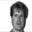

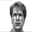

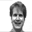

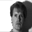

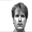

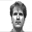

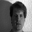

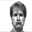

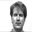

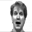

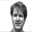

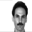

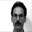

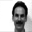

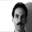

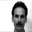

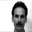

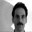

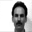

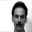

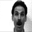

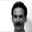

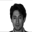

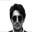

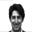

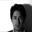

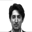

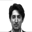

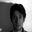

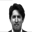

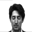

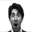

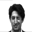

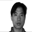

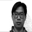

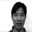

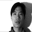

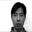

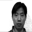

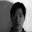

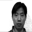

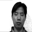

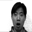

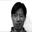

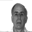

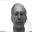

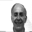

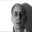

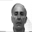

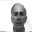

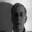

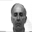

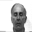

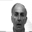

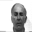

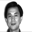

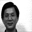

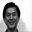

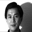

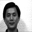

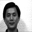

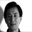

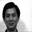

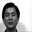

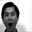

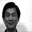

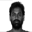

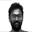

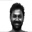

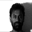

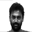

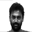

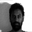

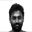

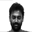

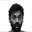

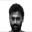

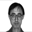

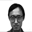

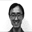

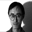

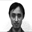

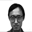

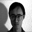

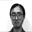

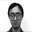

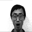

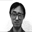

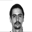

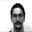

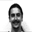

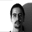

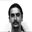

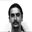

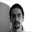

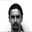

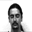

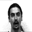

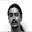

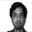

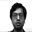

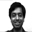

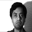

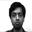

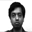

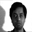

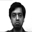

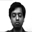

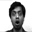

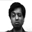

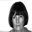

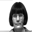

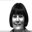

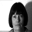

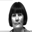

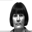

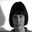

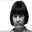

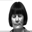

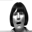

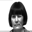

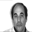

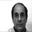

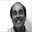

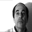

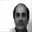

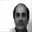

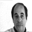

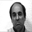

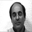

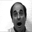

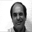

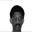

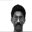

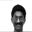

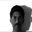

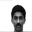

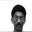

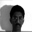

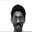

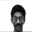

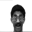

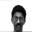

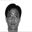

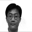

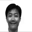

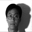

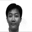

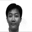

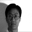

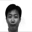

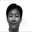

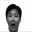

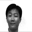

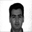

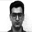

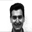

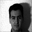

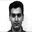

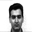

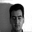

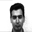

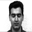

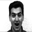

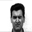

In [52]:
img=[]
for file in file_list:
    if(file=='Readme.txt'):
        continue
    else:
        path=os.path.join(file_dir,file)
        image=Image.open(path)
        image=image.resize((32,32))
        display(image)
        image=np.asarray(image)
        image=image.reshape(-1,)
        img.append(image)

In [53]:
#getting image dimensions as a vector
img[0].shape
# img=scaler.fit_transform(img)

(1024,)

In [54]:
labels=[x.split('.')[1] for x in file_list]
labels.remove('txt')
unique_labels=list(set(labels))
unique_labels

['normal',
 'sad',
 'noglasses',
 'rightlight',
 'happy',
 'wink',
 'glasses',
 'sleepy',
 'centerlight',
 'leftlight',
 'surprised']

In [55]:
len(labels)

165

In [56]:
img=np.array(img)
img.shape

(165, 1024)

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import pandas as pd
import math
from scipy.linalg import eigh
#returns distance between xi and xj
def dist(xi,xj,sigma=1,method='cosine'):
    if(method=='gauss'):
        return math.e**(np.linalg.norm(xi-xj)**2/2*sigma**2)
    if(method=='cosine'):
        return xi@xj/(np.linalg.norm(xi)*np.linalg.norm(xj))
    
#returns W
def build_graph(data,labels,method='LDA'):
    
    W=np.zeros((len(data),len(data)))
    labels=np.array(labels)
    data=np.array(data)
    if(method=='LDA'):
        unique_labels=list(np.unique(labels))
#         print(unique_labels)
#         print(type(unique_labels))
        count_classes={x:0 for x in unique_labels}
#         print(count_classes)
#         print(type(labels))
#         print(labels)
        for i in labels:
#             print(i)
#             print(type(i))
            count_classes[i]+=1
        for i in range(len(data)):
            for j in range(i,len(data)):
                if(labels[i]==labels[j]):
                    W[i,j]=1/count_classes[labels[i]]
                    W[j,i]=W[i,j]
                else:
                    W[i,j]=0
                    W[j,i]=0
    if(method=='LPP'):
        knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean')
        knn.fit(data,labels)
        for i in range(len(data)):
            s=0
            for j in range(i,len(data)):
                kj=knn.kneighbors(data[j].reshape((1,-1)))
                ki=knn.kneighbors(data[i].reshape((1,-1)))
                if(j in ki or i in kj):
                    W[i,j]=dist(data[i],data[j])
                    W[j,i]=W[i,j]
                else:
                    W[i,j]=0
                    W[j,i]=0
# #     sums=[]
#     for i in range(len(data)):
#         s=0
#         for j in range(len(data)):
# #             if(i!=j):
#             s+=W[i,j]
#         sums.append(s)
    D=np.zeros((len(data),len(data)))
    for i in range(len(data)):
        D[i,i]=np.sum(W[i,:])
    return W,D

# def split_train_test(data,labels,tsize=10):
#     x_train=[]
#     y_train=[]
#     x_test=[]
#     y_test=[]
#     labels=np.array(labels)
#     unique=np.unique(labels)
#     indices=[]
# #     print(data.shape)
#     for x in unique:
#         dfilter1=np.where((labels==x))
#         new_x=data[dfilter1]
#         new_y=labels[dfilter1]
#         indices.append(dfilter1)
    
#     y_train=np.array(y_train)
#     y_test=np.array(y_test)
#     x_test=np.array(x_test)
#     x_train=np.array(x_train)
#     y_train=y_train.ravel()
#     y_test=y_test.ravel()
#     print('x_train shape',x_train.shape)
#     print('x_test shape',x_test.shape)
#     print('y_train shape',y_train.shape)
#     print('y_test shape',y_test.shape)
#     x_train=np.reshape(x_train,(-1,x_train.shape[2]))
#     x_test=np.reshape(x_test,(-1,x_test.shape[2]))
# #     print(y_test)
    
#     return x_train,x_test,y_train,y_test


def split_train_test(data, labels,tsize=10):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
#     print(len(labels))
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        labels=np.array(labels)
        indices = np.where(labels == label)[0]
#         print('indices',indices)
        np.random.shuffle(indices)
        selected_indices = indices[:tsize]
        selected_indices_test=indices[tsize:]
        labels=list(labels)
        x_train.append(data[selected_indices])
        arr_test1=[]
        arr_test2=[]
        for i in selected_indices:
            arr_test1.append(labels[i])
        for i in selected_indices_test:
            arr_test2.append(labels[i])
#         print('size of arr_test 1',arr_test1.shape)
        y_train.append(arr_test1)
        x_test.append(data[selected_indices_test])
        y_test.append(arr_test2)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    x_test = np.concatenate(x_test)
    y_test = np.concatenate(y_test)
#     print('x_train shape',x_train.shape)
    return x_train, x_test, y_train,y_test

def algo_choice(X,Y,G_prev,smoothing_term,mu=0.1,choice=None):
    if(choice==1):
        res=X.T@np.linalg.inv(G_prev)@X
        return 1,np.linalg.inv(G_prev)@(X@(np.linalg.inv(res)@Y))
    elif(choice==2):
        res=X.T@np.linalg.inv(G_prev)@X
        shape=np.shape(res)[0]
        res=res+1/(2*mu)*np.identity(shape)
        return 2,np.linalg.inv(G_prev)@(X@(np.linalg.inv(res)@Y))
#         return A=(np.linalg.inv(G_prev)@X)@np.linalg.inv(X.T@np.linalg.inv(G_prev)@X+1/(2*0.01)*np.identity(len(img)))@Y #Algo 2
    print(X.shape)
    print(Y.shape)
    augmented=np.vstack((X,Y))
    r1=np.linalg.matrix_rank(augmented)
    r2=np.linalg.matrix_rank(X)
    n=1
#     G_prev=G_prev+smoothing_term*np.identity(G_prev.shape[0])
    for i in X.shape:
        n=n*i
    if(r1==r2 and r1<n):
        res=X.T@np.linalg.inv(G_prev)@X
        return 1,np.linalg.inv(G_prev)@(X@np.linalg.inv(res)@Y)
    else:
        res=X.T@np.linalg.inv(G_prev)@X
        shape=np.shape(res)[0]
        res=res+1/(2*mu)*np.identity(shape)
        return 2,np.linalg.inv(G_prev)@(X@(np.linalg.inv(res)@Y))

#returns projected data
def preprocessing(img,labels,method='PCA',plot=True,choice=None,tsize=10,mu=0.1):
    if(method=='PCA'):
        from sklearn.decomposition import PCA
        pca=PCA(n_components=min(len(img),img[0].shape[0]))
        new_img=pca.fit_transform(img)
        if(plot==True):
            plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
            plt.title("PCA: Plot to choose number of components")
            plt.xlabel('Number of components')
            plt.ylabel('Variance')
            plt.grid()
            plt.show()
        tol=99
        count=0
        for var in np.cumsum(pca.explained_variance_ratio_*100):
            count+=1
            if(var>=tol):
                break
        pca=PCA(n_components=count)
#         print('With tolerance (of variance, in percentage)=',tol,'\nNumber of components chosen for PCA:',count)
        new_img=pca.fit_transform(img)
        return new_img
    
    if(method=='FSSL_LDA' or method=='FSSL_LPP'):
#         print("entered here")
        #number of components=99=feature space in y
        #algo1
        x_train,x_test,y_train,y_test=split_train_test(img,labels,tsize)
        x_train=np.array(x_train)
        y_train=np.array(y_train)
        x_test=np.array(x_test)
        y_test=np.array(y_test)
#         print('shape of x_train',x_train.shape)
#         print('shape of y_train',y_train.shape)
#         print('shape of y_test',y_test.shape)
        method=method.split('_')[1]
        W,D=build_graph(x_train,y_train,method)
        #continue algo 1 
        Y=eigh(W,D)[1]
        X=x_train.T                                          
        A_prev=np.zeros(X.shape)
        G_prev=np.identity(A_prev.shape[0])
        smoothing_term=0.01
        niter=0
        max_niter=10000
        flag=0
#         check whether X^TA=Y has a solution, infinitely many solutions or no solution
        while(True):
            
#             try:
            choice,A=algo_choice(X,Y,G_prev,smoothing_term,mu,choice) #Algo chooser
#                 A=(np.linalg.inv(G_prev)@X)@np.linalg.inv(X.T@np.linalg.inv(G_prev)@X+1/(2*0.01)*np.identity(len(img)))@Y #Algo 2
#             except:
#                 A=A_prev
#                 break

            G=np.zeros(G_prev.shape)
            niter+=1
            if(niter%10==0):
                smoothing_term=smoothing_term/2
            for i in range(G.shape[0]):
                val=np.linalg.norm(A[i,:])
                if(val==0):
                    G[i,i]=0
                else:
                    G[i,i]=1/val
                    
                G[i,i]+=smoothing_term
            if(np.linalg.norm(A-A_prev)<0.001 or niter>max_niter):
                print("Error", np.linalg.norm(A-A_prev))
                break
            print("Step",niter,"Error", np.linalg.norm(A-A_prev))
            A_prev=A
            G_prev=G
        print("-----END-----")
        print("Model:",method)
        print("Choice:",choice)
        print("")
#         print("Heatmap of projection matrix")
#         sns.heatmap(A)
        return A
        
#returns accuracy and time taken
def baseline(data,labels,tsize,seed,x_train=[],x_test=[],y_train=[],y_test=[]):
    start=time.time()
    if(len(x_train)!=0 and len(x_test)!=0 and len(y_train)!=0 and len(y_test)!=0):
        if(len(x_train)!=len(y_train) or len(x_test)!=len(y_test)):
            print("x_train length",len(x_train))
            print('y_train length',len(y_train))
            print("x_test length",len(x_test))
            print('y_test length',len(y_test))
            raise Exception("Unequal size of x_train and x_test or y_train and y_test.")
    else:
#         print(data.shape)
#         print(labels.shape)
        x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=tsize,random_state=seed)
    
    knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean')
    knn.fit(x_train,y_train)
    pred=knn.predict(x_test)
    end=time.time()
    accuracy=accuracy_score(pred,y_test)
    time_taken=round((end-start)*1000,3)
#     print("Accuracy=",accuracy,time_taken)
    return accuracy,time_taken
#returns accuracy and time taken

def LDA(data,labels,tsize,seed):
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    start=time.time()
    data=preprocessing(data,labels,'PCA',False)
    x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=tsize,random_state=seed)
    lda=LinearDiscriminantAnalysis()
    new_img=lda.fit_transform(data,labels)
    pred=lda.predict(x_test)
    end=time.time()
    accuracy=accuracy_score(pred,y_test)
    time_taken=round((end-start)*1000,3)
#     print("Accuracy=",accuracy,time_taken)
    return new_img,accuracy,time_taken
# def fisher_score(data):
#     nfeatures=len(data[0])
#     nsamples=len(data)
#     for i in range(nfeatures):
#         #comment

In [74]:
def create_table(data,labels,model,choice,train_sizes,extra_time=0,mu=0.1):
#     train_sizes=[10,20,30]
    table={}
    for size in train_sizes:
        accuracies=[]
        times=[]
        a=0
        t=0
        count_unique=len(set(labels))
        for i in range(20):
            new_data=data
            x_train,x_test,y_train,y_test=split_train_test(new_data,labels,size)
            ts=min(len(data)-1,len(x_train))
            if(model is LDA):
                new_data,a, t=LDA(data,labels,ts,i)
            
            if(choice=='FSSL_LDA' or choice=='FSSL_LPP'):
#                 x_train,x_test,y_train,y_test=split_train_test(data,labels,size)
                A=preprocessing(data,labels,choice,False,tsize=size) #projection matrix
#                 img,labels,method='PCA',plot=True,choice=None,tsize=10
#                 print("A",A)
#                 print('New data shape',new_data.shape)
#                 print('A shape',A.shape)
                new_data=new_data@A
#                 print('new_data shape now',new_data.shape)
#                 print('Heatmap of projected image')
#                 sns.heatmap(new_data)
                a,t=baseline(new_data,labels,ts,i,x_train,x_test,y_train,y_test)
                accuracies.append(a)
                times.append(t+extra_time)
                continue
            if(choice=='LDA'):
                accuracies.append(a)
                times.append(t)
                continue

            else:      
                a, t=baseline(new_data,labels,ts,i)
                accuracies.append(a)
                times.append(t+extra_time)
        a=sum(accuracies)/len(accuracies)
        t=str(round(sum(times)/len(times),3))+' ms'
        table[size]=[a,t]
    table=pd.DataFrame(table)
    table=table.rename(index={0:'Accuracy',1:'Time taken'})
    return a,table
    

In [76]:
train_sizes=[5,6,7]
create_table(img,labels,baseline,'base',train_sizes,mu)[1]

,5,6,7
Accuracy,0.168636,0.173737,0.169318
Time taken,2.967 ms,3.17 ms,2.718 ms


In [77]:
create_table(img,labels,LDA,'base',train_sizes)[1]

,5,6,7
Accuracy,0.592273,0.59596,0.597159
Time taken,2.581 ms,3.034 ms,1.548 ms


In [78]:
create_table(img,labels,LDA,'LDA',train_sizes)[1]

,5,6,7
Accuracy,0.792273,0.793434,0.789205
Time taken,21.34 ms,22.079 ms,24.543 ms


In [ ]:
create_table(preprocessing(img,labels),labels,baseline,'base',train_sizes)

In [70]:
# start=time.time()
# fssl_img=preprocessing(img,labels,method='FSSL_LDA')
# end=time.time()
# extra=end-start
mus=[1,0.1,0.01,0.001]
tables={}
for mu in mus:
    tables[mu]=(create_table(img,labels,baseline,'FSSL_LDA',train_sizes,mu)[1])
print('value of mu',1)
tables[1]

(1024, 55)
(55, 55)
Step 1 Error 0.016556075505077816
Step 2 Error 0.0056899364710510094
Step 3 Error 0.003568097120334166
Step 4 Error 0.002430842929434903
Step 5 Error 0.0017617674940481514
Step 6 Error 0.001356046935559805
Step 7 Error 0.001094691721062134
Error 0.0009147893194460463
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.016797144145680662
Step 2 Error 0.005844647678643028
Step 3 Error 0.0029763763624162183
Step 4 Error 0.0021016793820322626
Step 5 Error 0.0015786653200478501
Step 6 Error 0.0012497675216137638
Step 7 Error 0.0010315027658316948
Error 0.0008773772455040187
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016320756822518247
Step 2 Error 0.006110865164820857
Step 3 Error 0.0029179875846212203
Step 4 Error 0.002032094109160857
Step 5 Error 0.0015451163938571316
Step 6 Error 0.001245167730943067
Step 7 Error 0.0010343750117710248
Error 0.0008737695048305068
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step

Step 1 Error 0.02326491080455404
Step 2 Error 0.00893162379143361
Step 3 Error 0.0038782362743167
Step 4 Error 0.0027556222755180013
Step 5 Error 0.0020361987268807348
Step 6 Error 0.0015718857774962393
Step 7 Error 0.0012658017778077253
Step 8 Error 0.0010520590525058863
Error 0.0008947641688781426
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02006261445396489
Step 2 Error 0.006814837249959307
Step 3 Error 0.003381571904023128
Step 4 Error 0.0024125316871142647
Step 5 Error 0.0017850367604825806
Step 6 Error 0.0013833607821092534
Step 7 Error 0.0011228352248137904
Error 0.000945222261821636
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020921607377608436
Step 2 Error 0.006465998929765449
Step 3 Error 0.0033532084743657345
Step 4 Error 0.0024151467225710078
Step 5 Error 0.001831308923545696
Step 6 Error 0.0014383835902183858
Step 7 Error 0.0011626842758550976
Error 0.0009641729221056184
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(6

Step 6 Error 0.0022254199892541306
Step 7 Error 0.0017355886847995545
Step 8 Error 0.0014080186977597344
Step 9 Error 0.0011715752216045503
Error 0.0009941079842382353
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.030611761514366825
Step 2 Error 0.012585878667970314
Step 3 Error 0.0042624762040454605
Step 4 Error 0.002945123515764369
Step 5 Error 0.002207426100955307
Step 6 Error 0.001722082896676932
Step 7 Error 0.0013926095287911668
Step 8 Error 0.0011566795095012852
Error 0.0009793845046053653
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025356295798958144
Step 2 Error 0.007901425474760285
Step 3 Error 0.003870692498172427
Step 4 Error 0.0026046349466988215
Step 5 Error 0.0018679107394785571
Step 6 Error 0.0014268311405307014
Step 7 Error 0.0011476425386851635
Error 0.0009571578358275383
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024232395838681735
Step 2 Error 0.008626678635265703
Step 3 Error 0.00345664

Step 5 Error 0.0017162320211172692
Step 6 Error 0.001334612068867775
Step 7 Error 0.0010894623573302442
Error 0.0009212079085968996
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.016798713798637906
Step 2 Error 0.005701079416321013
Step 3 Error 0.00287845959997311
Step 4 Error 0.0020710385822503012
Step 5 Error 0.0015898946401072213
Step 6 Error 0.001283083625909099
Step 7 Error 0.001070593020886459
Error 0.0009125156115123752
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018105052971466272
Step 2 Error 0.006595820568920856
Step 3 Error 0.0034249349282933473
Step 4 Error 0.002453207362904132
Step 5 Error 0.0018486981307187212
Step 6 Error 0.0014737131202148888
Step 7 Error 0.001217508150261624
Step 8 Error 0.0010325919349612176
Error 0.0008942498728450725
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017029071817058126
Step 2 Error 0.006070034706004859
Step 3 Error 0.0030202253468465815
Step 4 Error 0.00221880442

Step 9 Error 0.001077936045714937
Error 0.0009271291291984621
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.019841250922618018
Step 2 Error 0.00649051565725608
Step 3 Error 0.003240275183819933
Step 4 Error 0.0022568776129758003
Step 5 Error 0.001664902782628726
Step 6 Error 0.0012980666805649753
Step 7 Error 0.001060446023575292
Error 0.0008953246455933208
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019865432100153898
Step 2 Error 0.006284616541619835
Step 3 Error 0.0032336364261230568
Step 4 Error 0.002395014284474634
Step 5 Error 0.001795816329067203
Step 6 Error 0.0013831100402254928
Step 7 Error 0.0011079107380416477
Error 0.0009204211693888541
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.022787359510643417
Step 2 Error 0.007008540768479623
Step 3 Error 0.0034057703485448664
Step 4 Error 0.0024457090077266287
Step 5 Error 0.00185098725216325
Step 6 Error 0.0014616806707056353
Step 7 Error 0.0011962137019

Step 1 Error 0.017541455232511036
Step 2 Error 0.005682201954668127
Step 3 Error 0.0030059183780760715
Step 4 Error 0.002181686540796599
Step 5 Error 0.001686637743503304
Step 6 Error 0.0013605519056362934
Step 7 Error 0.0011284329374348712
Error 0.0009543562024914201
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019472285993054495
Step 2 Error 0.006489022768622447
Step 3 Error 0.004072025076165597
Step 4 Error 0.0028071854409233016
Step 5 Error 0.0020648299742424543
Step 6 Error 0.0016144396731048694
Step 7 Error 0.0013163504477139434
Step 8 Error 0.001101255953443045
Error 0.0009377439787023111
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.018707443888944412
Step 2 Error 0.006509918190676993
Step 3 Error 0.0035070651715534956
Step 4 Error 0.0025691902814960854
Step 5 Error 0.0019078192419139464
Step 6 Error 0.0014731652705332417
Step 7 Error 0.0011818622816604984
Error 0.0009757832169581417
-----END-----
Model: LDA
Choice: 2

(1024, 5

Step 7 Error 0.001139707591294102
Error 0.0009473428478873446
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01865512349474981
Step 2 Error 0.0051702100591897145
Step 3 Error 0.0029274487277165116
Step 4 Error 0.0021293817140448147
Step 5 Error 0.0016364373461826036
Step 6 Error 0.00131055450013598
Step 7 Error 0.0010817171808831677
Error 0.0009135628260833713
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020594324931292467
Step 2 Error 0.006382356801539139
Step 3 Error 0.004017383744731061
Step 4 Error 0.0028151430883171227
Step 5 Error 0.0020916177897690835
Step 6 Error 0.0016279745502487996
Step 7 Error 0.0013094257843955786
Step 8 Error 0.0010785843647870958
Error 0.0009063293037791226
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.018857250967398376
Step 2 Error 0.005888665836130712
Step 3 Error 0.0029458127902811
Step 4 Error 0.002131813891908548
Step 5 Error 0.0016393604881372779
Step 6 Error 0.001320563935

Step 2 Error 0.011604242099278012
Step 3 Error 0.004213380719496742
Step 4 Error 0.0028993293785314345
Step 5 Error 0.002099996154539195
Step 6 Error 0.001588434582590356
Step 7 Error 0.0012619130599194398
Step 8 Error 0.0010415628859522942
Error 0.0008821136210855553
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.030808349834926394
Step 2 Error 0.011785309529005953
Step 3 Error 0.004466104083980424
Step 4 Error 0.003010796285591589
Step 5 Error 0.0021768755451855195
Step 6 Error 0.001663444527377481
Step 7 Error 0.001326620759508729
Step 8 Error 0.001088205140425711
Error 0.0009117833530377213
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027014421882882174
Step 2 Error 0.011200861261792745
Step 3 Error 0.0036130950921078736
Step 4 Error 0.0024544822240538007
Step 5 Error 0.0018108471021006064
Step 6 Error 0.0014030731800569016
Step 7 Error 0.001134284173469483
Error 0.000947278013650601
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(7

Step 4 Error 0.0021618002722362108
Step 5 Error 0.0016632157293562718
Step 6 Error 0.0013339421044588063
Step 7 Error 0.0011080588479890185
Error 0.000942316357820397
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.023225473329109285
Step 2 Error 0.010127388957809992
Step 3 Error 0.0034475034778056464
Step 4 Error 0.002498481594614976
Step 5 Error 0.0019228355922509858
Step 6 Error 0.0015209705526287216
Step 7 Error 0.001243002996477224
Step 8 Error 0.0010415128650889053
Error 0.0008872207284892474
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.021626904104746873
Step 2 Error 0.007858246110071174
Step 3 Error 0.0038238099689154627
Step 4 Error 0.002742903628104209
Step 5 Error 0.002055500578868464
Step 6 Error 0.0015947374911110214
Step 7 Error 0.0012795445917372025
Step 8 Error 0.001055885764367529
Error 0.0008910594203519327
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01737811761384894
Step 2 Error 0.0066233165

Step 1 Error 0.022598334061884464
Step 2 Error 0.007328194852889148
Step 3 Error 0.003644351775204694
Step 4 Error 0.0024771416914026317
Step 5 Error 0.0017882833367536186
Step 6 Error 0.0013773851146448135
Step 7 Error 0.0011174045687124981
Error 0.0009381766787986733
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024520846341049573
Step 2 Error 0.009161108742662134
Step 3 Error 0.00368986701045515
Step 4 Error 0.00256823352743603
Step 5 Error 0.001878297438826994
Step 6 Error 0.0014373662775694206
Step 7 Error 0.0011441157312661082
Error 0.0009390760133631443
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029490697014875562
Step 2 Error 0.011274529869699243
Step 3 Error 0.004105805521607723
Step 4 Error 0.0027182969813263225
Step 5 Error 0.0019996408757900585
Step 6 Error 0.001554416016629487
Step 7 Error 0.0012535435138107689
Step 8 Error 0.0010376529506470678
Error 0.0008768215144337216
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(

,5,6,7
Accuracy,0.172273,0.168687,0.16875
Time taken,3.084 ms,1.937 ms,0.557 ms


In [71]:
print('value of mu=',0.1)
tables[0.1]

,5,6,7
Accuracy,0.173636,0.172727,0.167045
Time taken,4.064 ms,2.772 ms,1.425 ms


In [72]:
print('value of mu=',0.01)
tables[0.01]

,5,6,7
Accuracy,0.174545,0.170202,0.168182
Time taken,2.058 ms,3.348 ms,4.727 ms


In [73]:
print('value of mu=',0.001)
tables[0.001]

,5,6,7
Accuracy,0.167273,0.163131,0.175
Time taken,3.004 ms,3.523 ms,2.34 ms


In [85]:
mus=np.arange(0,1,0.01)
accuracies=[]
for mu in mus:
    accuracies.append(create_table(img,labels,baseline,'FSSL_LDA',train_sizes,mu)[0])
# plt.plot(mus,accuracies)

(1024, 55)
(55, 55)
Step 1 Error 0.017240032156942902
Step 2 Error 0.005848982583048747
Step 3 Error 0.0036517161229718317
Step 4 Error 0.0025234488019834126
Step 5 Error 0.0018545528568432814
Step 6 Error 0.0014357711775907854
Step 7 Error 0.0011565105478394241
Error 0.0009618347690030383
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.022042973289671558
Step 2 Error 0.010003308118564275
Step 3 Error 0.003595419259675726
Step 4 Error 0.0025327147741578872
Step 5 Error 0.0018791055841163918
Step 6 Error 0.0014560559850750028
Step 7 Error 0.0011823102324044698
Error 0.0009932469586417237
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01755873795832075
Step 2 Error 0.006222969225196497
Step 3 Error 0.0038388645442203077
Step 4 Error 0.0025516789427198956
Step 5 Error 0.001822043063109699
Step 6 Error 0.0013894890092095715
Step 7 Error 0.001110163658644337
Error 0.000919855231115379
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step

Step 7 Error 0.0012376045522119522
Step 8 Error 0.0010123482973953832
Error 0.0008528940286845984
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022433840499616643
Step 2 Error 0.007373080608512433
Step 3 Error 0.004534333666664567
Step 4 Error 0.0029964693448260066
Step 5 Error 0.0021790786638034338
Step 6 Error 0.0016935021242166968
Step 7 Error 0.001367383624573316
Step 8 Error 0.0011324168838504518
Error 0.0009557297054284863
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.019949558670751967
Step 2 Error 0.006292438191765237
Step 3 Error 0.003201888181751358
Step 4 Error 0.0022787470944151894
Step 5 Error 0.0017026798713103044
Step 6 Error 0.0013318694485020728
Step 7 Error 0.0010839539656812222
Error 0.000909237398051222
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022071646027927157
Step 2 Error 0.007888850206713021
Step 3 Error 0.0037031048220695075
Step 4 Error 0.002658426829602963
Step 5 Error 0.002014170

Step 3 Error 0.004101184839201148
Step 4 Error 0.0028418612644912486
Step 5 Error 0.002100503818189915
Step 6 Error 0.0016205043572541083
Step 7 Error 0.0012920878636172666
Step 8 Error 0.001059622586888185
Error 0.0008919625680332801
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02825492828580483
Step 2 Error 0.011147222934200401
Step 3 Error 0.004078104261337216
Step 4 Error 0.002898415599424564
Step 5 Error 0.0021494626658016772
Step 6 Error 0.0016314316670919167
Step 7 Error 0.0012778959300149902
Step 8 Error 0.001033604307456879
Error 0.0008601869663558257
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028557470942695562
Step 2 Error 0.011083587651458827
Step 3 Error 0.00438647875192116
Step 4 Error 0.002969340451630434
Step 5 Error 0.0021319336550763624
Step 6 Error 0.0015957935482545087
Step 7 Error 0.0012482996588769532
Step 8 Error 0.0010150423178970863
Error 0.0008506877212464593
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(

Step 5 Error 0.003019403888447572
Step 6 Error 0.0022086942103458854
Step 7 Error 0.001712782710423143
Step 8 Error 0.0013822124499720193
Step 9 Error 0.0011490235614776525
Error 0.0009780898546769658
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.020584652307771654
Step 2 Error 0.007058656669999817
Step 3 Error 0.0034027815000827505
Step 4 Error 0.0025028014204549944
Step 5 Error 0.0019139867304492932
Step 6 Error 0.0015220640092709794
Step 7 Error 0.0012585976808510606
Step 8 Error 0.0010724663616597913
Error 0.0009325116029332389
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.020706316278628272
Step 2 Error 0.00928309388544466
Step 3 Error 0.0036066482089777865
Step 4 Error 0.0026142907741233835
Step 5 Error 0.0019418794866246374
Step 6 Error 0.0014896757942896998
Step 7 Error 0.0011859360903254603
Error 0.0009738260032569123
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.022682175601512717
Step 2 Error 0.010049

Step 7 Error 0.0017230654031945964
Step 8 Error 0.0014190476465014235
Step 9 Error 0.0011979683815877633
Step 10 Error 0.001030711312850694
Error 0.0009007677137138593
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.020809212226954674
Step 2 Error 0.00671484022182359
Step 3 Error 0.0040493134961245205
Step 4 Error 0.0027819704408977835
Step 5 Error 0.0020615579889346567
Step 6 Error 0.0016166720218461752
Step 7 Error 0.0013190831325000261
Step 8 Error 0.0011029977759745766
Error 0.0009364833487977182
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02472678739758406
Step 2 Error 0.010715896959968578
Step 3 Error 0.0036911160835504998
Step 4 Error 0.0025341882554811425
Step 5 Error 0.0018477599459938428
Step 6 Error 0.0013992184666522035
Step 7 Error 0.001108110670887993
Error 0.0009142143094275665
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024202306321199043
Step 2 Error 0.011013145988090776
Step 3 Error 0.0035422

Step 2 Error 0.01013988953806178
Step 3 Error 0.003375983185973681
Step 4 Error 0.0022683550097183174
Step 5 Error 0.0017145275149953502
Step 6 Error 0.0013614433431175937
Step 7 Error 0.0011177807842446578
Error 0.0009427479451763932
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.013924117853319122
Step 2 Error 0.004279218395096324
Step 3 Error 0.002539901867270733
Step 4 Error 0.0018918099116255267
Step 5 Error 0.0014608758132769561
Step 6 Error 0.0011638894131378922
Error 0.0009564213005232926
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01590407623278645
Step 2 Error 0.004991382301435726
Step 3 Error 0.0029663888129528113
Step 4 Error 0.002224527001954773
Step 5 Error 0.0017059825178766966
Step 6 Error 0.001351798482677896
Step 7 Error 0.0011004886045765413
Error 0.0009131091961732462
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01735429697620152
Step 2 Error 0.0058236858622478195
Step 3 Error 0.00303865830

Step 2 Error 0.00708991624739577
Step 3 Error 0.004549767465061392
Step 4 Error 0.003038568172657442
Step 5 Error 0.0021650258399390377
Step 6 Error 0.0016563315041893598
Step 7 Error 0.0013363231858375356
Step 8 Error 0.0011178281006037757
Error 0.000957739750727195
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.023135475530789904
Step 2 Error 0.007651361244361884
Step 3 Error 0.004638761238733406
Step 4 Error 0.003084436483664739
Step 5 Error 0.0022199816431749436
Step 6 Error 0.00172053551374974
Step 7 Error 0.001399073130435584
Step 8 Error 0.0011700642341722783
Error 0.000996584579451932
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.020436633754512292
Step 2 Error 0.006288276013027715
Step 3 Error 0.0033456055573577634
Step 4 Error 0.0023892437315178538
Step 5 Error 0.0017992400567556704
Step 6 Error 0.0014162313224877923
Step 7 Error 0.0011522648299130333
Error 0.0009601998701319465
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(6

Step 3 Error 0.004401125252631268
Step 4 Error 0.0029129064757322603
Step 5 Error 0.0020832218199070113
Step 6 Error 0.0015673409943437275
Step 7 Error 0.001232582904443438
Step 8 Error 0.0010035720732894649
Error 0.0008397762386052446
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.030889383705429468
Step 2 Error 0.012335730192519863
Step 3 Error 0.00426401935131427
Step 4 Error 0.002754845865011292
Step 5 Error 0.0019693552266541324
Step 6 Error 0.0015023072484392087
Step 7 Error 0.0012062765043968956
Step 8 Error 0.0010039417558972594
Error 0.0008562124653721115
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.031005079410702397
Step 2 Error 0.01368339006543459
Step 3 Error 0.004039417968047198
Step 4 Error 0.002667872597374929
Step 5 Error 0.001993892338085566
Step 6 Error 0.001551774127612283
Step 7 Error 0.0012526333797831224
Step 8 Error 0.0010418540491050348
Error 0.0008864704047276845
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(

Error 0.0009131886373625998
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016136095088074173
Step 2 Error 0.00539697678227617
Step 3 Error 0.0033601516639858347
Step 4 Error 0.0023671089354967176
Step 5 Error 0.0017731678293313
Step 6 Error 0.0013949557479915264
Step 7 Error 0.0011410368824149946
Error 0.0009593664834727142
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.0158418415024619
Step 2 Error 0.004955211380501539
Step 3 Error 0.0026262815939083217
Step 4 Error 0.0019358629420203252
Step 5 Error 0.0014889595538510106
Step 6 Error 0.0011917719395996174
Error 0.0009903042929910759
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016270744452028394
Step 2 Error 0.005527434393567236
Step 3 Error 0.002993544513569442
Step 4 Error 0.0022346903474496998
Step 5 Error 0.0017277355583183857
Step 6 Error 0.0013858955579289529
Step 7 Error 0.0011447867041604416
Error 0.0009651409756672366
-----END-----
Model: LDA
Choice: 

Step 3 Error 0.003717975955893482
Step 4 Error 0.0026008090919001406
Step 5 Error 0.0019149467658942775
Step 6 Error 0.001490673008149868
Step 7 Error 0.0012136024782688833
Step 8 Error 0.0010172732609925242
Error 0.0008686658157120354
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.030390193940970332
Step 2 Error 0.01209624588813376
Step 3 Error 0.004345860985173263
Step 4 Error 0.0028888773288433898
Step 5 Error 0.002101221106348182
Step 6 Error 0.001624094626773678
Step 7 Error 0.0013171091363841
Step 8 Error 0.0011054648631768304
Error 0.0009497232278578852
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023895966896081606
Step 2 Error 0.007367023400093954
Step 3 Error 0.0034478577048605743
Step 4 Error 0.0024847337706795708
Step 5 Error 0.0018924342714479805
Step 6 Error 0.0015014851954439155
Step 7 Error 0.0012299080276603105
Step 8 Error 0.0010315508910600736
Error 0.0008811489277999513
-----END-----
Model: LDA
Choice: 2

(1024, 77)


Step 3 Error 0.0038651376140405188
Step 4 Error 0.002682908078873876
Step 5 Error 0.0019513703942605548
Step 6 Error 0.0015095371909413261
Step 7 Error 0.0012290050384093454
Step 8 Error 0.0010371326521671734
Error 0.0008972542131590276
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.02504721975175591
Step 2 Error 0.01086002393746869
Step 3 Error 0.0067459410809505875
Step 4 Error 0.004105458496768478
Step 5 Error 0.002754044309588326
Step 6 Error 0.0020333404764207273
Step 7 Error 0.0015887820308653536
Step 8 Error 0.0012901312195709455
Step 9 Error 0.0010766010220629274
Error 0.0009159989387637289
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.01713529228385805
Step 2 Error 0.00616916939232684
Step 3 Error 0.0030122122835293716
Step 4 Error 0.002122872294892797
Step 5 Error 0.001585827271203559
Step 6 Error 0.001251787533194589
Step 7 Error 0.0010312989476197988
Error 0.0008742069807298171
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(

Step 1 Error 0.02369278075042555
Step 2 Error 0.00782705608742727
Step 3 Error 0.003831703546200042
Step 4 Error 0.0027516496707004575
Step 5 Error 0.0020622467520842363
Step 6 Error 0.001605855864400416
Step 7 Error 0.0012994295784542502
Step 8 Error 0.0010870484263982472
Error 0.0009334299966449171
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026123062552588547
Step 2 Error 0.01120172629045926
Step 3 Error 0.006615250727316596
Step 4 Error 0.003864999503882531
Step 5 Error 0.0024891867357400015
Step 6 Error 0.001791789228885518
Step 7 Error 0.0013958847890671912
Step 8 Error 0.0011438386267244773
Error 0.0009667429440613839
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.025034374115906935
Step 2 Error 0.010950694103575374
Step 3 Error 0.0034087229859999057
Step 4 Error 0.002358302557717827
Step 5 Error 0.0017645586341987563
Step 6 Error 0.0013796777148361527
Step 7 Error 0.0011204618486993206
Error 0.0009365827153422433
-----END-----


Step 1 Error 0.023693320837536582
Step 2 Error 0.006746731554549991
Step 3 Error 0.004110182412405193
Step 4 Error 0.0028127950198525826
Step 5 Error 0.0020556241616224214
Step 6 Error 0.0015950213210595239
Step 7 Error 0.0013008210083447571
Step 8 Error 0.001099530862105426
Error 0.0009522075412490706
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.026822638792581864
Step 2 Error 0.011472004874360566
Step 3 Error 0.0037147881826356368
Step 4 Error 0.0026778036370214615
Step 5 Error 0.0020227291974739938
Step 6 Error 0.0015588071375621402
Step 7 Error 0.0012356817030937438
Step 8 Error 0.0010087872796797422
Error 0.0008445277453200391
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03069642951594472
Step 2 Error 0.012912521656529835
Step 3 Error 0.00421830722718773
Step 4 Error 0.00284613057626718
Step 5 Error 0.002093233070291785
Step 6 Error 0.0016057707981985165
Step 7 Error 0.0012832923462114739
Step 8 Error 0.001060005321813853
Error 0

Step 2 Error 0.009391216981352327
Step 3 Error 0.005341941598122824
Step 4 Error 0.0031792178962467177
Step 5 Error 0.0022236366189160176
Step 6 Error 0.0016907350888975608
Step 7 Error 0.0013476442342703783
Step 8 Error 0.001113746571075792
Error 0.000946185615258164
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.020164485954710116
Step 2 Error 0.007408841477327587
Step 3 Error 0.004686949405061503
Step 4 Error 0.0029590305146806454
Step 5 Error 0.0020840527896815878
Step 6 Error 0.0016065451326886303
Step 7 Error 0.0013000125790847512
Step 8 Error 0.001083544496043338
Error 0.0009205882266937647
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.016927132263564005
Step 2 Error 0.005955020601292615
Step 3 Error 0.0030481076203761528
Step 4 Error 0.0021443967253801225
Step 5 Error 0.0016269787192858434
Step 6 Error 0.0012988575275686752
Step 7 Error 0.0010689801881296316
Error 0.0009007275107160088
-----END-----
Model: LDA
Choice: 2

(1024, 5

Step 6 Error 0.001563656808930297
Step 7 Error 0.0012466590676639235
Step 8 Error 0.0010216038408683208
Error 0.0008581896448948244
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028950542868860236
Step 2 Error 0.011369597941411761
Step 3 Error 0.0045352195260477245
Step 4 Error 0.0030927252423807883
Step 5 Error 0.002178790158926351
Step 6 Error 0.0016130191573082056
Step 7 Error 0.001264421551289717
Step 8 Error 0.0010349977651657259
Error 0.0008720518605132148
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024884573158683417
Step 2 Error 0.009251021493445062
Step 3 Error 0.0037100521751831403
Step 4 Error 0.0025855630401037046
Step 5 Error 0.001899026925215644
Step 6 Error 0.0014550299283789163
Step 7 Error 0.0011602057189172897
Error 0.0009563242596552275
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02755300435063584
Step 2 Error 0.01057033185692705
Step 3 Error 0.0037557428264818394
Step 4 Error 0.0025187672

Step 5 Error 0.001625362205110413
Step 6 Error 0.0012916113993020684
Step 7 Error 0.0010558676187206932
Error 0.0008837805465327025
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.016737008133409267
Step 2 Error 0.005744884268879887
Step 3 Error 0.003564020835196764
Step 4 Error 0.002435988570040327
Step 5 Error 0.0017767479582178048
Step 6 Error 0.0013720875581251493
Step 7 Error 0.0011092612923846589
Error 0.0009284912973506059
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.01516715745999429
Step 2 Error 0.004648046847938315
Step 3 Error 0.0025789529986183155
Step 4 Error 0.0019336412719573623
Step 5 Error 0.001527468451642954
Step 6 Error 0.0012417484147065224
Step 7 Error 0.0010284595857364346
Error 0.0008664968318159797
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017293237067155055
Step 2 Error 0.0058623248813433415
Step 3 Error 0.0030458284078745115
Step 4 Error 0.0022605264590390586
Step 5 Error 0.00171064

Step 2 Error 0.010206429905185836
Step 3 Error 0.0036579081834287853
Step 4 Error 0.002473239408764156
Step 5 Error 0.0018197697180603928
Step 6 Error 0.0014254671109478604
Step 7 Error 0.001172652729241711
Error 0.0009937057533889223
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02739606810735412
Step 2 Error 0.011678333455796632
Step 3 Error 0.006776858225378605
Step 4 Error 0.0040655327407407675
Step 5 Error 0.0027503126256843103
Step 6 Error 0.002051269731271689
Step 7 Error 0.0016209337991081262
Step 8 Error 0.0013243380069567615
Step 9 Error 0.0011039094243561847
Error 0.0009337599135530424
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02204855333263472
Step 2 Error 0.00883547491712349
Step 3 Error 0.003621531351639969
Step 4 Error 0.002589079184826177
Step 5 Error 0.0019052821795829337
Step 6 Error 0.0014606910125329264
Step 7 Error 0.001169323419271424
Error 0.0009692616758446766
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(6

Step 6 Error 0.0013789458298432127
Step 7 Error 0.0011420242902888472
Error 0.0009704493084622979
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027957676179141522
Step 2 Error 0.009142970071690182
Step 3 Error 0.005480184694476299
Step 4 Error 0.0035100512051538225
Step 5 Error 0.002416539087769431
Step 6 Error 0.0017954287927373584
Step 7 Error 0.0014158389769489614
Step 8 Error 0.0011624139421280203
Error 0.0009801074873810724
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.02182413305386734
Step 2 Error 0.006524713263647087
Step 3 Error 0.0033921067463726436
Step 4 Error 0.0023368849422082797
Step 5 Error 0.0017197519631405687
Step 6 Error 0.001350277869391271
Step 7 Error 0.0011111927311802322
Error 0.0009425703378948885
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.020943228430667524
Step 2 Error 0.006377160158328851
Step 3 Error 0.003161301701229964
Step 4 Error 0.002236510784309016
Step 5 Error 0.0016787658

Step 2 Error 0.0051079210488674896
Step 3 Error 0.00275226137849932
Step 4 Error 0.002007289557370875
Step 5 Error 0.0015238412471122193
Step 6 Error 0.0012194000324032056
Step 7 Error 0.001020413331143532
Error 0.0008773895428037362
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.03020996017713721
Step 2 Error 0.012517814770767344
Step 3 Error 0.004493973392461601
Step 4 Error 0.0030865176641688445
Step 5 Error 0.002271947115124302
Step 6 Error 0.001735017475599706
Step 7 Error 0.001378737056545602
Step 8 Error 0.0011327501155254036
Error 0.00095456273320605
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.030039792016753636
Step 2 Error 0.012892372507694873
Step 3 Error 0.004836835449242798
Step 4 Error 0.0032112626700056606
Step 5 Error 0.0022596146109629296
Step 6 Error 0.0016575453496080043
Step 7 Error 0.0012749792425307705
Step 8 Error 0.0010226945306505033
Error 0.0008491500435530365
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66

Step 5 Error 0.0021191990437638693
Step 6 Error 0.0016395668163662201
Step 7 Error 0.0013203970326266246
Step 8 Error 0.0010975935390356683
Error 0.0009334137354341738
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.031123212970273283
Step 2 Error 0.011686667955218897
Step 3 Error 0.004618812672587094
Step 4 Error 0.0031726969382814005
Step 5 Error 0.0022856798072088307
Step 6 Error 0.0017140811769542994
Step 7 Error 0.0013437360435967036
Step 8 Error 0.0010953773252955475
Error 0.0009206138965967025
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03133765914664934
Step 2 Error 0.011505112262237828
Step 3 Error 0.0063624901594402225
Step 4 Error 0.003936183014321283
Step 5 Error 0.0026693579501227208
Step 6 Error 0.001961520237629063
Step 7 Error 0.0015438083710078694
Step 8 Error 0.0012768560068643032
Step 9 Error 0.0010901679906555222
Error 0.0009492141963891331
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.026005

Step 5 Error 0.0018603947868244767
Step 6 Error 0.0014602598944987346
Step 7 Error 0.001183778554257172
Error 0.0009837548408963197
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.02528175962732583
Step 2 Error 0.011380247641358383
Step 3 Error 0.004076789798658089
Step 4 Error 0.0028798775624345875
Step 5 Error 0.0021702496884050564
Step 6 Error 0.001696453344117253
Step 7 Error 0.001376270686425645
Step 8 Error 0.0011518774113569216
Error 0.000986409672116851
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01658677765373451
Step 2 Error 0.0053292877794344174
Step 3 Error 0.0027801287299278263
Step 4 Error 0.0021041033530375757
Step 5 Error 0.0016632754994479833
Step 6 Error 0.0013449199735715192
Step 7 Error 0.001107148862416331
Error 0.0009278628811226406
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01848442537391751
Step 2 Error 0.006904257150135197
Step 3 Error 0.003210712024024501
Step 4 Error 0.0022617790407

Step 7 Error 0.0010410675650987175
Error 0.0008830714918013076
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02632090891244467
Step 2 Error 0.010380837487120782
Step 3 Error 0.0064273038244145545
Step 4 Error 0.003929675315432849
Step 5 Error 0.0025628272240014794
Step 6 Error 0.0018709927593407825
Step 7 Error 0.0014828234123126424
Step 8 Error 0.0012292698335357643
Step 9 Error 0.0010441737168355018
Error 0.000901000472669757
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.021110519905866133
Step 2 Error 0.007611796068015869
Step 3 Error 0.003632110889814144
Step 4 Error 0.002551297329315066
Step 5 Error 0.0018815939856686253
Step 6 Error 0.0014412796786165887
Step 7 Error 0.0011443729027771092
Error 0.0009360820680654947
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01961977819536244
Step 2 Error 0.006589193282391346
Step 3 Error 0.0031394592293730113
Step 4 Error 0.002275840911716924
Step 5 Error 0.00172597110

Step 1 Error 0.027490888469024588
Step 2 Error 0.01129387076675661
Step 3 Error 0.0042012988632613895
Step 4 Error 0.0029063475768430313
Step 5 Error 0.0021182192248139554
Step 6 Error 0.0016101304591496434
Step 7 Error 0.0012803612500646728
Step 8 Error 0.001053192798105237
Error 0.0008864285171767189
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0214628057180818
Step 2 Error 0.006210445036516577
Step 3 Error 0.0033108474684162017
Step 4 Error 0.002359024191600793
Step 5 Error 0.0017684905692214015
Step 6 Error 0.0013937838931540648
Step 7 Error 0.001143552420512763
Error 0.0009658113131544843
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029358712458131243
Step 2 Error 0.011525078844255483
Step 3 Error 0.004520955261795917
Step 4 Error 0.0030148190282490136
Step 5 Error 0.002132647981641645
Step 6 Error 0.0015864132819730086
Step 7 Error 0.0012389556168130413
Step 8 Error 0.0010056147995473124
Error 0.000840183331653522
-----END-----


Step 1 Error 0.026641892175128124
Step 2 Error 0.011606434058141601
Step 3 Error 0.006793756509121913
Step 4 Error 0.0038657918094654772
Step 5 Error 0.0025624478878826552
Step 6 Error 0.0019384362275445717
Step 7 Error 0.001551879503048147
Step 8 Error 0.0012767413446400102
Step 9 Error 0.0010705572587097706
Error 0.000912473027798776
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.019544804160714743
Step 2 Error 0.006708247046683074
Step 3 Error 0.0030272739783003327
Step 4 Error 0.002162235312462494
Step 5 Error 0.0016433705042186132
Step 6 Error 0.0013180836115481232
Step 7 Error 0.0010995404865628531
Error 0.0009394851592162863
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01879814785459423
Step 2 Error 0.006012288323595026
Step 3 Error 0.0030466464118854186
Step 4 Error 0.002172389922147505
Step 5 Error 0.001645123728210083
Step 6 Error 0.0013012227305958279
Step 7 Error 0.001064388209560841
Error 0.0008942739683612598
-----END-----

Step 4 Error 0.0021728073953348917
Step 5 Error 0.0016193153592516298
Step 6 Error 0.001268234955446557
Step 7 Error 0.0010330924597462183
Error 0.0008667336636646834
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02114166601010227
Step 2 Error 0.006124856469042393
Step 3 Error 0.0032209811849889898
Step 4 Error 0.0022237658448317865
Step 5 Error 0.0016228356160781778
Step 6 Error 0.001252717207004649
Step 7 Error 0.0010120757806668758
Error 0.0008445247124162473
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0293452441246093
Step 2 Error 0.012036537607674994
Step 3 Error 0.0040515232180249735
Step 4 Error 0.002535245575415636
Step 5 Error 0.0018516123059836899
Step 6 Error 0.001462330315402539
Step 7 Error 0.0012034795788427176
Step 8 Error 0.0010165833818512144
Error 0.0008749494099245819
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024027816944665718
Step 2 Error 0.007859080066269793
Step 3 Error 0.00366554124

Step 1 Error 0.01995539540999771
Step 2 Error 0.009346616787404394
Step 3 Error 0.005646265228796327
Step 4 Error 0.003248046752418856
Step 5 Error 0.0021734316482215953
Step 6 Error 0.0016560710951851313
Step 7 Error 0.0013350058280733417
Step 8 Error 0.0011021078431611108
Error 0.0009228492148047592
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.022086123264440243
Step 2 Error 0.009570575266476733
Step 3 Error 0.003290269094103836
Step 4 Error 0.00233501573225687
Step 5 Error 0.0017910465554828547
Step 6 Error 0.0014129264359118337
Step 7 Error 0.001146074404840142
Error 0.0009519685545876871
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.013295197601788242
Step 2 Error 0.004066529392805553
Step 3 Error 0.0023201652082712214
Step 4 Error 0.0016872064561711368
Step 5 Error 0.0012969516844188508
Step 6 Error 0.0010452039058996994
Error 0.000871312437196444
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017138509057

Step 2 Error 0.007894876180520103
Step 3 Error 0.0033670813044214963
Step 4 Error 0.002416657711803465
Step 5 Error 0.0018501588918080072
Step 6 Error 0.0014816113067299245
Step 7 Error 0.001225185486443127
Step 8 Error 0.001035608108736486
Error 0.0008897613975272036
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.017532948529386517
Step 2 Error 0.0052089102129440415
Step 3 Error 0.002957657721892735
Step 4 Error 0.002200797255383642
Step 5 Error 0.0016755646402233774
Step 6 Error 0.001312038413028201
Step 7 Error 0.0010614755561744436
Error 0.0008871707973482351
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02827988408705485
Step 2 Error 0.012211552712321164
Step 3 Error 0.004224743313937751
Step 4 Error 0.002777607082678956
Step 5 Error 0.001981976361355939
Step 6 Error 0.0014959667581296793
Step 7 Error 0.0011916353293806746
Error 0.00098738962597746
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02000559306459

Step 5 Error 0.001616460336340494
Step 6 Error 0.0012675718628473312
Step 7 Error 0.0010297330818225126
Error 0.0008608095825372335
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0279498874651296
Step 2 Error 0.01073470953254333
Step 3 Error 0.004131052821908474
Step 4 Error 0.002831717539173422
Step 5 Error 0.0020742006330911286
Step 6 Error 0.00159296420580996
Step 7 Error 0.0012723913420186288
Step 8 Error 0.001045522804885116
Error 0.0008771776536366708
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02967992235309763
Step 2 Error 0.011260817645068923
Step 3 Error 0.004484621062125194
Step 4 Error 0.0030055545776992705
Step 5 Error 0.0021349011784974198
Step 6 Error 0.001593873707152169
Step 7 Error 0.0012516744484077562
Step 8 Error 0.0010263516070896745
Error 0.0008695142288852677
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014840109155252832
Step 2 Error 0.0046033257383381885
Step 3 Error 0.002546056616742

Step 4 Error 0.002591094076614972
Step 5 Error 0.0019049739311024026
Step 6 Error 0.0014851931312626476
Step 7 Error 0.0012005857534684449
Error 0.000995999697298058
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021854118632242955
Step 2 Error 0.007711137648358158
Step 3 Error 0.0034809893948081904
Step 4 Error 0.002402489917797083
Step 5 Error 0.0018054781695688196
Step 6 Error 0.0014396687929810995
Step 7 Error 0.001188432218442949
Step 8 Error 0.001003100778412503
Error 0.0008606177786622728
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.018420725432202818
Step 2 Error 0.005710046883880688
Step 3 Error 0.0032166399703358246
Step 4 Error 0.002304918006552246
Step 5 Error 0.001730692230638021
Step 6 Error 0.0013653381106707473
Step 7 Error 0.0011169176651648612
Error 0.0009391110864344014
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02410416024484861
Step 2 Error 0.009808882912757532
Step 3 Error 0.003737015028

Step 7 Error 0.0012434657005447826
Step 8 Error 0.0010336625050073125
Error 0.0008792963168410184
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025582637605836418
Step 2 Error 0.008190809064345831
Step 3 Error 0.0037473960469645157
Step 4 Error 0.002629109782519362
Step 5 Error 0.0019360701388774684
Step 6 Error 0.001487230761460465
Step 7 Error 0.0011923434363651374
Error 0.000992293648281501
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024387824802122746
Step 2 Error 0.007974297403042528
Step 3 Error 0.0035977818307542176
Step 4 Error 0.002503147951667929
Step 5 Error 0.0018817554337860502
Step 6 Error 0.0014866375266130558
Step 7 Error 0.001214305021123469
Step 8 Error 0.0010169231454603745
Error 0.0008694864726813635
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02802845163830282
Step 2 Error 0.011060294367788489
Step 3 Error 0.0037798735255961165
Step 4 Error 0.0025503161849764148
Step 5 Error 0.0018858174

Step 2 Error 0.003495204618657096
Step 3 Error 0.0021921138017104167
Step 4 Error 0.001678490323830771
Step 5 Error 0.0013360594687799297
Step 6 Error 0.0010925873187198813
Error 0.0009123803463387843
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014898147178001002
Step 2 Error 0.004668173135612105
Step 3 Error 0.0028540652359810128
Step 4 Error 0.0019774366588240417
Step 5 Error 0.0014987319494748274
Step 6 Error 0.001201909757285867
Error 0.0009965907591774205
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.014596295968047042
Step 2 Error 0.0042334341411426136
Step 3 Error 0.0025452250860666945
Step 4 Error 0.0018977530451968453
Step 5 Error 0.001471465701682572
Step 6 Error 0.001182900153968618
Error 0.0009786611868559023
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.020610794239640802
Step 2 Error 0.00726936191715653
Step 3 Error 0.003493663868693376
Step 4 Error 0.0025323826744845573
Step 5 Error 0.0019109690

Step 2 Error 0.006580792841049024
Step 3 Error 0.004234496957905424
Step 4 Error 0.002892466107019366
Step 5 Error 0.002082262519398342
Step 6 Error 0.001583115703184885
Step 7 Error 0.001256760508612303
Step 8 Error 0.0010329953368428788
Error 0.0008727656989579835
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.0274886743883
Step 2 Error 0.011863138221784048
Step 3 Error 0.004148014731071691
Step 4 Error 0.0027845078672138696
Step 5 Error 0.0020132219607087716
Step 6 Error 0.00153800152068368
Step 7 Error 0.001237638182319228
Step 8 Error 0.0010320625792263015
Error 0.0008806941169315845
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02319543151193008
Step 2 Error 0.009231988591474763
Step 3 Error 0.0033496856671950976
Step 4 Error 0.0023275185240595703
Step 5 Error 0.001732844573710949
Step 6 Error 0.0013626060587288201
Step 7 Error 0.0011219159745332484
Error 0.0009529452770116817
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)

Step 1 Error 0.016970970690775113
Step 2 Error 0.006452948192573967
Step 3 Error 0.00330646847500613
Step 4 Error 0.002322430406618731
Step 5 Error 0.0016953370755353147
Step 6 Error 0.0013158909432822107
Step 7 Error 0.0010656311725018139
Error 0.0008865872509409916
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016890049636432754
Step 2 Error 0.00570237217256355
Step 3 Error 0.0035590503970714363
Step 4 Error 0.002414221265404804
Step 5 Error 0.0017493355595214937
Step 6 Error 0.0013533073442394893
Step 7 Error 0.0010985503585864602
Error 0.0009201297320810242
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.018117655941702466
Step 2 Error 0.006637587256013334
Step 3 Error 0.003147591970878069
Step 4 Error 0.0022474085603102372
Step 5 Error 0.0017252231251911846
Step 6 Error 0.0013945675083952673
Step 7 Error 0.0011678184483399964
Step 8 Error 0.0010014827428570978
Error 0.0008728625566744719
-----END-----
Model: LDA
Choice: 2

(1024, 55)

Step 1 Error 0.015718668500020006
Step 2 Error 0.004569080738060448
Step 3 Error 0.0025909559243836476
Step 4 Error 0.0018614097936289005
Step 5 Error 0.0014087879928601206
Step 6 Error 0.0011222228878501551
Error 0.0009295553389094139
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02195282160640018
Step 2 Error 0.009177496554849068
Step 3 Error 0.0036009375681700212
Step 4 Error 0.0026310916130983437
Step 5 Error 0.001995464074958591
Step 6 Error 0.0015557878298846303
Step 7 Error 0.0012504229922235426
Step 8 Error 0.0010320686276386452
Error 0.0008705763135803443
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.030156613155675083
Step 2 Error 0.011749716001730123
Step 3 Error 0.004417054926962278
Step 4 Error 0.003064817726828495
Step 5 Error 0.0022791242345746756
Step 6 Error 0.0017456832478292162
Step 7 Error 0.0013827895334408327
Step 8 Error 0.0011320504080269047
Error 0.0009534591177982525
-----END-----
Model: LDA
Choice: 2

(1024, 6

Step 7 Error 0.0013001795855497255
Step 8 Error 0.0010709386061490498
Error 0.0009015633582511998
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028073887747915624
Step 2 Error 0.011259830924720667
Step 3 Error 0.0042542188776058245
Step 4 Error 0.0028634718531428465
Step 5 Error 0.002077687990264821
Step 6 Error 0.0015867832316857832
Step 7 Error 0.0012645583156043478
Step 8 Error 0.0010401498172174057
Error 0.0008759572882910256
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024791835364118574
Step 2 Error 0.00790586809584056
Step 3 Error 0.003581458725028821
Step 4 Error 0.0024515730469277233
Step 5 Error 0.001810098878308467
Step 6 Error 0.0014171769800371413
Step 7 Error 0.0011564253847925223
Error 0.0009698522622446956
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03303401080875034
Step 2 Error 0.013009493462402596
Step 3 Error 0.004597343121363378
Step 4 Error 0.002977985355478821
Step 5 Error 0.00213127590

Step 3 Error 0.0025347281928835385
Step 4 Error 0.0018935077259533758
Step 5 Error 0.0014692878670420184
Step 6 Error 0.0011873795170200168
Error 0.0009946595438956834
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018499805834432295
Step 2 Error 0.006427772467477329
Step 3 Error 0.0029447088439102554
Step 4 Error 0.00218664396195895
Step 5 Error 0.0016959970991112256
Step 6 Error 0.0013465859805008428
Step 7 Error 0.0010973097346161308
Error 0.000917608977504654
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015270737414283968
Step 2 Error 0.005032408470367573
Step 3 Error 0.0027646605534181307
Step 4 Error 0.002032921735875617
Step 5 Error 0.0015524749798600105
Step 6 Error 0.001227144517561528
Step 7 Error 0.0010029054376563026
Error 0.0008429191159249554
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015895235609359563
Step 2 Error 0.005070802885631398
Step 3 Error 0.0027160306282986747
Step 4 Error 0.001954484

Step 4 Error 0.0020448815319916804
Step 5 Error 0.0015780239875858894
Step 6 Error 0.0012505347354176007
Step 7 Error 0.0010174177426369494
Error 0.0008480932228513933
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.023439931482580972
Step 2 Error 0.008405825167817826
Step 3 Error 0.0039046394660924603
Step 4 Error 0.002714263011379281
Step 5 Error 0.001960433428984018
Step 6 Error 0.0014786710580059685
Step 7 Error 0.0011651277842173143
Error 0.0009521060726202792
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02338839265744612
Step 2 Error 0.007504695315433827
Step 3 Error 0.003413579130659769
Step 4 Error 0.002370969040954024
Step 5 Error 0.0017502235713956725
Step 6 Error 0.00135839541148946
Step 7 Error 0.001098402135454467
Error 0.0009164552317478235
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0251137323370218
Step 2 Error 0.008341266731462023
Step 3 Error 0.0038422967797272097
Step 4 Error 0.00264354097395

Error 0.0009755597753808094
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017523746470179524
Step 2 Error 0.00596407862544364
Step 3 Error 0.0032340022066331743
Step 4 Error 0.002327322582422814
Step 5 Error 0.0017374854816381172
Step 6 Error 0.001373916699734329
Step 7 Error 0.001135950194052877
Error 0.0009674831222348653
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018590430038395403
Step 2 Error 0.006526304297510938
Step 3 Error 0.0032748184281238195
Step 4 Error 0.0024800633390222927
Step 5 Error 0.0018915770224290562
Step 6 Error 0.0014679352363955393
Step 7 Error 0.0011816096186205891
Error 0.000982573626875342
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019887552530173342
Step 2 Error 0.006959602966048054
Step 3 Error 0.00363003360356184
Step 4 Error 0.002669997080367757
Step 5 Error 0.001983548669735384
Step 6 Error 0.0015155797495919707
Step 7 Error 0.0012158445178421932
Step 8 Error 0.0010191570189

Error 0.0008880509765718257
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02469188491205388
Step 2 Error 0.010568509506259923
Step 3 Error 0.00621733955701696
Step 4 Error 0.0034924680306892826
Step 5 Error 0.002252292648223644
Step 6 Error 0.001676979798905646
Step 7 Error 0.0013396370122068756
Step 8 Error 0.0011075455668606727
Error 0.000935194736122722
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02591634853060474
Step 2 Error 0.011255899982000448
Step 3 Error 0.0036911533685229907
Step 4 Error 0.0025661808693325807
Step 5 Error 0.0019381577725748086
Step 6 Error 0.0015068924749704782
Step 7 Error 0.0012055507144056975
Error 0.0009919524194788166
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.028041364587451996
Step 2 Error 0.011864633918229292
Step 3 Error 0.003981600516346022
Step 4 Error 0.002688447629543615
Step 5 Error 0.0020493294888672903
Step 6 Error 0.0016215954106180654
Step 7 Error 0.0013166757655

Step 6 Error 0.001527129560603972
Step 7 Error 0.001187845483377062
Error 0.0009626050290080441
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0289015592429555
Step 2 Error 0.010235458819638601
Step 3 Error 0.005919107788177021
Step 4 Error 0.0037130424361932735
Step 5 Error 0.0025808157137648283
Step 6 Error 0.0019481253468002302
Step 7 Error 0.0015529001601038571
Step 8 Error 0.0012807084101883297
Step 9 Error 0.0010803173372160126
Error 0.0009265478708948727
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.026878921753677974
Step 2 Error 0.010626470718906489
Step 3 Error 0.0040659076650082105
Step 4 Error 0.0026602631659118636
Step 5 Error 0.001896877172228486
Step 6 Error 0.00144420704033226
Step 7 Error 0.0011556606805498294
Error 0.0009582775183191384
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.030816324827667888
Step 2 Error 0.012223342349033996
Step 3 Error 0.004437421035494578
Step 4 Error 0.0030164888928

Step 5 Error 0.0017422446961358929
Step 6 Error 0.001378666281472489
Step 7 Error 0.0011242338699152424
Error 0.0009382581247945903
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019261454731571648
Step 2 Error 0.00797453554933314
Step 3 Error 0.0032787993412174395
Step 4 Error 0.0022639975662999165
Step 5 Error 0.001684292768375902
Step 6 Error 0.0013355535092198663
Step 7 Error 0.001102112998034192
Error 0.0009291719803814211
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01264342371776143
Step 2 Error 0.0035512011643728763
Step 3 Error 0.0022080297391966364
Step 4 Error 0.0016401264926289608
Step 5 Error 0.0012515771926251168
Error 0.000995388664976972
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01884104055400099
Step 2 Error 0.006364632213370571
Step 3 Error 0.004046579989827668
Step 4 Error 0.0027984202594943082
Step 5 Error 0.0020841170697311765
Step 6 Error 0.0016514747482596884
Step 7 Error 0.00135836927

Step 4 Error 0.002194946706686441
Step 5 Error 0.0016563523110164618
Step 6 Error 0.0013175497126079966
Step 7 Error 0.0010930424491647744
Error 0.0009325702423728488
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021569022019688217
Step 2 Error 0.007382904234666735
Step 3 Error 0.003364143080480073
Step 4 Error 0.0023960507223096212
Step 5 Error 0.001815441462023739
Step 6 Error 0.001434843988301115
Step 7 Error 0.001171633378349412
Error 0.0009821875284559494
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029995857772044117
Step 2 Error 0.012203787889411725
Step 3 Error 0.004241476260502313
Step 4 Error 0.0029755803175200756
Step 5 Error 0.002222448347313057
Step 6 Error 0.0017165489158555954
Step 7 Error 0.0013743667977458639
Step 8 Error 0.0011356927176058942
Error 0.0009626438879588766
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026149775584949953
Step 2 Error 0.008774808269729541
Step 3 Error 0.00404752614

Step 1 Error 0.01775076964622794
Step 2 Error 0.007293953077746425
Step 3 Error 0.002943413382327527
Step 4 Error 0.00212315197608076
Step 5 Error 0.0016312064981665046
Step 6 Error 0.0013155491883527085
Step 7 Error 0.001097382742547675
Error 0.0009355065881309218
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019929353697916
Step 2 Error 0.006620821663871883
Step 3 Error 0.004141907438787166
Step 4 Error 0.0028826556029146046
Step 5 Error 0.002134041831877211
Step 6 Error 0.0016643680622981602
Step 7 Error 0.0013474397112407984
Step 8 Error 0.0011217804280062062
Error 0.0009567198714877819
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.015266992777416138
Step 2 Error 0.00518382552494342
Step 3 Error 0.003077732588260451
Step 4 Error 0.002268393696331344
Step 5 Error 0.001711437812359421
Step 6 Error 0.0013481299902030489
Step 7 Error 0.0011035276690276434
Error 0.0009278563474977378
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55

Step 4 Error 0.002356307186647192
Step 5 Error 0.0017365676813388797
Step 6 Error 0.0013337547443807124
Step 7 Error 0.001064799690868799
Error 0.0008759155824029076
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024230722733261656
Step 2 Error 0.0077531735566677236
Step 3 Error 0.0037968747650073465
Step 4 Error 0.002740791791200444
Step 5 Error 0.0020547071155194766
Step 6 Error 0.0015986636438430103
Step 7 Error 0.0012924114794406884
Step 8 Error 0.0010777204282346655
Error 0.0009193633593653455
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019518449796505796
Step 2 Error 0.006661517545920247
Step 3 Error 0.003299954969739687
Step 4 Error 0.0023394354045170895
Step 5 Error 0.001764046271321991
Step 6 Error 0.0013978513288464111
Step 7 Error 0.0011493965907069695
Error 0.0009706616949966236
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02151551896765987
Step 2 Error 0.00746633268323518
Step 3 Error 0.0034406749

Step 7 Error 0.001339309330932657
Step 8 Error 0.0011025997595884578
Error 0.0009343736580035885
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025338765838373824
Step 2 Error 0.007863591511844521
Step 3 Error 0.004796892580258899
Step 4 Error 0.0031746842247771046
Step 5 Error 0.0022487234666635535
Step 6 Error 0.0016944972937400207
Step 7 Error 0.001342205225787628
Step 8 Error 0.001104788696845413
Error 0.0009364127997075446
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.028837584792939342
Step 2 Error 0.012371785188675015
Step 3 Error 0.004234220397115278
Step 4 Error 0.0027824893249659287
Step 5 Error 0.001980451030946649
Step 6 Error 0.0014938070878353234
Step 7 Error 0.001187169474889077
Error 0.0009811522115389206
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027907134036163093
Step 2 Error 0.010226108457993372
Step 3 Error 0.004247081806501624
Step 4 Error 0.0028675604034911558
Step 5 Error 0.002037328719

Step 4 Error 0.002234922567244799
Step 5 Error 0.001705728643401025
Step 6 Error 0.0013505004961213683
Step 7 Error 0.0011032227652198819
Error 0.0009242747777474194
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017844064072790645
Step 2 Error 0.00610316857833413
Step 3 Error 0.003141723477391328
Step 4 Error 0.002221047537476657
Step 5 Error 0.0016587262109231868
Step 6 Error 0.001308906369910516
Step 7 Error 0.0010739314641863861
Error 0.0009029486310892216
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018612852475596835
Step 2 Error 0.0067032352875727105
Step 3 Error 0.003139762143600392
Step 4 Error 0.0022233214278044506
Step 5 Error 0.0016510805165686974
Step 6 Error 0.0012823092242634326
Step 7 Error 0.0010419023529851918
Error 0.0008771474602929315
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01912011009587106
Step 2 Error 0.007091096661126597
Step 3 Error 0.0033438160747998884
Step 4 Error 0.00240413841

Step 2 Error 0.011295420324761694
Step 3 Error 0.003939598426131033
Step 4 Error 0.002672448094237104
Step 5 Error 0.0019519362605025206
Step 6 Error 0.0014959001834536204
Step 7 Error 0.0011956379824575466
Error 0.0009871535541341918
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025732885055061903
Step 2 Error 0.008602148503049203
Step 3 Error 0.005015118122089684
Step 4 Error 0.003178662764867264
Step 5 Error 0.002238207745313037
Step 6 Error 0.0017121090228834441
Step 7 Error 0.0013783346215989938
Step 8 Error 0.001149309429335379
Error 0.0009833068622456967
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.02399067114614497
Step 2 Error 0.007569578187103304
Step 3 Error 0.0038102428332557237
Step 4 Error 0.0026379036253743977
Step 5 Error 0.0019401899849435394
Step 6 Error 0.0015167158920660877
Step 7 Error 0.0012369640525994427
Step 8 Error 0.0010359785090230443
Error 0.0008833364030758181
-----END-----
Model: LDA
Choice: 2

(1024, 77)

Step 1 Error 0.016191861792920974
Step 2 Error 0.005501386372429247
Step 3 Error 0.0035269008564548913
Step 4 Error 0.0024029872461544858
Step 5 Error 0.0017378256720724627
Step 6 Error 0.0013588046566986557
Step 7 Error 0.0011279740463817833
Error 0.0009682452947372792
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.017813842453093337
Step 2 Error 0.005869603995327372
Step 3 Error 0.0031107461535671214
Step 4 Error 0.0022783140141564608
Step 5 Error 0.0017212154558002642
Step 6 Error 0.0013452993123787777
Step 7 Error 0.0010898939647632105
Error 0.0009106799515429868
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02371892965727666
Step 2 Error 0.01115422544370861
Step 3 Error 0.003896063300556522
Step 4 Error 0.0026121896544328248
Step 5 Error 0.001930938635779303
Step 6 Error 0.0015038200285779038
Step 7 Error 0.0012138571156972261
Step 8 Error 0.0010040930124505625
Error 0.0008473402442411425
-----END-----
Model: LDA
Choice: 2

(1024, 5

Step 2 Error 0.009977255271119442
Step 3 Error 0.0033179919355525683
Step 4 Error 0.002284851950349364
Step 5 Error 0.0017164268573178845
Step 6 Error 0.0013565020707317454
Step 7 Error 0.0011140947092219524
Error 0.0009402914628985819
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02510167305211597
Step 2 Error 0.011439570261793059
Step 3 Error 0.0038548898856990313
Step 4 Error 0.002595406713782372
Step 5 Error 0.0018602849342600502
Step 6 Error 0.0013981663738567899
Step 7 Error 0.0011049534605291065
Error 0.000909933798949419
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02661365256157942
Step 2 Error 0.01122666849946308
Step 3 Error 0.004182989199055512
Step 4 Error 0.0026984619500601595
Step 5 Error 0.0018989727914006003
Step 6 Error 0.0014425842101329876
Step 7 Error 0.001166198102488492
Error 0.0009811010603673384
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024972034779920143
Step 2 Error 0.008083875292

Step 8 Error 0.0010183062611874303
Error 0.0008675601064675996
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.031617341350719336
Step 2 Error 0.013654022200980758
Step 3 Error 0.004467750970145519
Step 4 Error 0.0028990426024570444
Step 5 Error 0.0020549219869377923
Step 6 Error 0.0015308029703273334
Step 7 Error 0.0011990049095085228
Error 0.000977403608804087
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029740540951558828
Step 2 Error 0.010873470983045527
Step 3 Error 0.006073872996723322
Step 4 Error 0.0038123784144060797
Step 5 Error 0.002651272379712637
Step 6 Error 0.001984866352197587
Step 7 Error 0.001560519450452003
Step 8 Error 0.0012696858742067788
Step 9 Error 0.0010601347688331654
Error 0.0009034934550512742
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.0231095439128859
Step 2 Error 0.008645054158006878
Step 3 Error 0.003492550883824096
Step 4 Error 0.0025345392690021063
Step 5 Error 0.0018900794126

Step 7 Error 0.0015658152864441966
Step 8 Error 0.0012899543882044155
Step 9 Error 0.0010886716338933706
Error 0.0009337607294623216
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.020269666113431478
Step 2 Error 0.007476354487529013
Step 3 Error 0.0035211149235097284
Step 4 Error 0.0024788081297273602
Step 5 Error 0.0018370136147151188
Step 6 Error 0.0014354029714901413
Step 7 Error 0.0011710702987861624
Error 0.0009841274194353688
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018587694947141443
Step 2 Error 0.00699827479235507
Step 3 Error 0.003268551046672163
Step 4 Error 0.0022949342705589366
Step 5 Error 0.0017420853875658737
Step 6 Error 0.0013790732996013804
Step 7 Error 0.0011254264824341101
Error 0.0009424452395709385
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0227538042074773
Step 2 Error 0.007739818498224395
Step 3 Error 0.003436767589513203
Step 4 Error 0.0023879673673021587
Step 5 Error 0.001806970

Step 5 Error 0.002090075273924244
Step 6 Error 0.0015963208636103072
Step 7 Error 0.001280884504164894
Step 8 Error 0.001066232360389364
Error 0.0009114725409335148
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025948870971405344
Step 2 Error 0.009043149753032378
Step 3 Error 0.004048921774685649
Step 4 Error 0.002745564644867416
Step 5 Error 0.001985630336505938
Step 6 Error 0.0015282795519806372
Step 7 Error 0.001235443671988558
Step 8 Error 0.0010316366642451728
Error 0.0008804667513003221
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027480698443871243
Step 2 Error 0.010740801869964577
Step 3 Error 0.006428956784954284
Step 4 Error 0.0036803978828125654
Step 5 Error 0.0023926622250324105
Step 6 Error 0.0017642660454073708
Step 7 Error 0.0013933711142184002
Step 8 Error 0.0011450669512863539
Error 0.0009663987515272133
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.022962582337354983
Step 2 Error 0.00779678869

Error 0.000970609732822686
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016136584280293846
Step 2 Error 0.006413142618700855
Step 3 Error 0.0027862872970298978
Step 4 Error 0.0019591363920774384
Step 5 Error 0.0014552215641400969
Step 6 Error 0.0011362388028073693
Error 0.0009261278509015198
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019352017744392554
Step 2 Error 0.007461191990993838
Step 3 Error 0.0045820960758564825
Step 4 Error 0.0029607605122472114
Step 5 Error 0.002046919581797372
Step 6 Error 0.0015268490980264201
Step 7 Error 0.0012150181620636889
Step 8 Error 0.0010122909941788353
Error 0.000869000899795582
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.02016615220084013
Step 2 Error 0.008936922020096886
Step 3 Error 0.0030801843864277103
Step 4 Error 0.00218687165244344
Step 5 Error 0.001666805971514905
Step 6 Error 0.0013237651244411325
Step 7 Error 0.0010929320583970992
Error 0.000928170853445731

Step 4 Error 0.002461756560074129
Step 5 Error 0.0018042813319516658
Step 6 Error 0.0013983542313368309
Step 7 Error 0.0011329116077463787
Error 0.0009469410079833285
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01705701039589007
Step 2 Error 0.0051242424576814355
Step 3 Error 0.002844836145159536
Step 4 Error 0.002083836858635112
Step 5 Error 0.001589474194127617
Step 6 Error 0.0012645229381016813
Step 7 Error 0.0010421376874805114
Error 0.0008807534180467122
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021652321316908415
Step 2 Error 0.006906896267915266
Step 3 Error 0.004181746814716684
Step 4 Error 0.0027512506977395304
Step 5 Error 0.001950962048559413
Step 6 Error 0.0014920250409886334
Step 7 Error 0.001206527712065167
Step 8 Error 0.0010125198949197346
Error 0.0008712503676744889
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.024167430980190686
Step 2 Error 0.010029553728430141
Step 3 Error 0.00381190165

Step 3 Error 0.003955656797791966
Step 4 Error 0.0026560053195096504
Step 5 Error 0.0019245088446457647
Step 6 Error 0.0014956824422104986
Step 7 Error 0.0012173894322609939
Step 8 Error 0.0010193563849183337
Error 0.0008702206562227069
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.021398503912154625
Step 2 Error 0.006214720451478254
Step 3 Error 0.0032488093518739485
Step 4 Error 0.0023047312977457217
Step 5 Error 0.001729045930093325
Step 6 Error 0.0013559358242791484
Step 7 Error 0.001102294663826987
Error 0.0009220148057832587
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02719189986469039
Step 2 Error 0.011030865865234524
Step 3 Error 0.0036139738900946385
Step 4 Error 0.002474489573304422
Step 5 Error 0.0018542654742818325
Step 6 Error 0.0014563410959746404
Step 7 Error 0.0011871809613515495
Error 0.0009947195311114144
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027881924489257647
Step 2 Error 0.01178450

Step 6 Error 0.0016677516043522834
Step 7 Error 0.0013486547030465877
Step 8 Error 0.0011417607124661194
Error 0.0009904354549457159
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.015192190687568956
Step 2 Error 0.004621833774550037
Step 3 Error 0.003159693514686954
Step 4 Error 0.0023076362319072647
Step 5 Error 0.0017508197554094937
Step 6 Error 0.0014046644950306655
Step 7 Error 0.00117535999004997
Step 8 Error 0.0010070608960041857
Error 0.0008747635122839127
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.024967026606057048
Step 2 Error 0.01030545846041822
Step 3 Error 0.00350745963937135
Step 4 Error 0.0022336880049329275
Step 5 Error 0.0016379163661479612
Step 6 Error 0.0012950595753499052
Step 7 Error 0.0010650052368386296
Error 0.0008946934470979045
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022167448495279848
Step 2 Error 0.007691573561069586
Step 3 Error 0.0036514441523273996
Step 4 Error 0.0025616711

Error 0.0008544871503704102
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02507698363522226
Step 2 Error 0.01009689087438648
Step 3 Error 0.0035979790191678226
Step 4 Error 0.00252601849946281
Step 5 Error 0.001883567502433775
Step 6 Error 0.0014578218525676447
Step 7 Error 0.0011674575279226936
Error 0.0009623343325485122
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027147843834877783
Step 2 Error 0.009362398199701834
Step 3 Error 0.004038700649516895
Step 4 Error 0.0027307992167186707
Step 5 Error 0.00198243002098772
Step 6 Error 0.0015331626688646377
Step 7 Error 0.0012435196482639265
Step 8 Error 0.0010389474694550576
Error 0.0008845688617788979
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.030063945593141458
Step 2 Error 0.012361005906384776
Step 3 Error 0.004273961899529514
Step 4 Error 0.0027685184148085054
Step 5 Error 0.002002612123419533
Step 6 Error 0.001539476657255861
Step 7 Error 0.001241639991428

Step 6 Error 0.0015148303535814263
Step 7 Error 0.0011944678271393902
Error 0.0009870642839505612
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016960008866308544
Step 2 Error 0.006237197054124503
Step 3 Error 0.002890047545246512
Step 4 Error 0.0020023938950192804
Step 5 Error 0.0014864660940666775
Step 6 Error 0.0011638753674982627
Error 0.0009460081289222809
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.013308654214578209
Step 2 Error 0.0039909779466358805
Step 3 Error 0.0026362639599149134
Step 4 Error 0.001929707140339117
Step 5 Error 0.0014943773568168622
Step 6 Error 0.001213088575326335
Step 7 Error 0.001015354563518704
Error 0.0008653137311042153
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.015913623500787486
Step 2 Error 0.0053622310085924075
Step 3 Error 0.0026899242293487824
Step 4 Error 0.0018946084222364855
Step 5 Error 0.0014549947586155988
Step 6 Error 0.0011812063133486259
Error 0.0009850080140

Step 7 Error 0.0011240971477517704
Error 0.0009415762386199904
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020997933038059514
Step 2 Error 0.00673890157714661
Step 3 Error 0.003358197257809879
Step 4 Error 0.002316320842330188
Step 5 Error 0.0016758080944155578
Step 6 Error 0.0012830070153879792
Step 7 Error 0.001035340881371256
Error 0.0008687830086176213
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024079803016130188
Step 2 Error 0.008793199799530445
Step 3 Error 0.00387615777902642
Step 4 Error 0.0026507704215824137
Step 5 Error 0.0019408304602107395
Step 6 Error 0.0015022975420811375
Step 7 Error 0.0012095573651961188
Step 8 Error 0.0010017801951505733
Error 0.0008484832682464839
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.017137059246381734
Step 2 Error 0.004913831592742178
Step 3 Error 0.003048537520254563
Step 4 Error 0.002082295529438568
Step 5 Error 0.0015189828471134867
Step 6 Error 0.001186332447

Step 2 Error 0.009149568775079686
Step 3 Error 0.003748173802503147
Step 4 Error 0.002526114416648253
Step 5 Error 0.0018425903031694078
Step 6 Error 0.0014388258312170693
Step 7 Error 0.0011775545747124284
Error 0.0009920179753535089
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02360835724126872
Step 2 Error 0.007328326273039672
Step 3 Error 0.00366810633862646
Step 4 Error 0.00252045691525883
Step 5 Error 0.0018372022347299924
Step 6 Error 0.00142176684292263
Step 7 Error 0.0011513956782192535
Error 0.0009608993700483881
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03113883072505025
Step 2 Error 0.011881474162038715
Step 3 Error 0.0046391547159717016
Step 4 Error 0.003172699106500639
Step 5 Error 0.0022966832321720675
Step 6 Error 0.0017408020379612854
Step 7 Error 0.0013815853378049813
Step 8 Error 0.0011353851029861045
Error 0.0009560228258215279
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02245894078169

Step 1 Error 0.02294407972523043
Step 2 Error 0.009935249314289456
Step 3 Error 0.0036295196221163475
Step 4 Error 0.0026035931613934593
Step 5 Error 0.0019363725490599956
Step 6 Error 0.0014776841625871494
Step 7 Error 0.0011649796516505972
Error 0.0009487780555998492
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022731537213108617
Step 2 Error 0.007628039288643871
Step 3 Error 0.00494703681010099
Step 4 Error 0.003351098137288527
Step 5 Error 0.0023732036955097626
Step 6 Error 0.0017895946598300496
Step 7 Error 0.0014244835048124614
Step 8 Error 0.001181533563026845
Step 9 Error 0.0010100823928794762
Error 0.0008816629283599735
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.025095935857121967
Step 2 Error 0.010459426989108135
Step 3 Error 0.0037568750421450954
Step 4 Error 0.002601116568704775
Step 5 Error 0.001942670956840069
Step 6 Error 0.0015157746578609657
Step 7 Error 0.001224053854142415
Step 8 Error 0.001014805748490433
Error 0

Step 8 Error 0.0010622061270827816
Error 0.0008956018076753145
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.022752897585131437
Step 2 Error 0.0077077137424754
Step 3 Error 0.0034543965587004897
Step 4 Error 0.0023582531823990475
Step 5 Error 0.0017162208576555406
Step 6 Error 0.0013242278811001454
Step 7 Error 0.0010755869552418445
Error 0.0009074592041757644
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026242425096147066
Step 2 Error 0.008907684076832997
Step 3 Error 0.003985402138139599
Step 4 Error 0.002727885194162633
Step 5 Error 0.001998313409714811
Step 6 Error 0.0015453706303342088
Step 7 Error 0.0012458615170818765
Step 8 Error 0.0010359332128521113
Error 0.000881938699359022
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025904701273916152
Step 2 Error 0.008276605293179633
Step 3 Error 0.0038843286724978476
Step 4 Error 0.0026564570952217325
Step 5 Error 0.0019111493577092628
Step 6 Error 0.0014588335

Step 1 Error 0.01649708889600864
Step 2 Error 0.005649091354136159
Step 3 Error 0.0036199844495174737
Step 4 Error 0.002527570489909976
Step 5 Error 0.0018863946476078588
Step 6 Error 0.0014892620866020813
Step 7 Error 0.0012248561388335548
Step 8 Error 0.0010359197312981689
Error 0.0008930630406639069
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.01710053852920762
Step 2 Error 0.005798904311929889
Step 3 Error 0.003014062613845148
Step 4 Error 0.0021827389880498
Step 5 Error 0.0016371532195112051
Step 6 Error 0.001277923219582434
Step 7 Error 0.0010389650026023487
Error 0.0008742463184384535
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017924214088692585
Step 2 Error 0.005954703506391816
Step 3 Error 0.0031584396510238367
Step 4 Error 0.0023052548979129854
Step 5 Error 0.0017348789232688685
Step 6 Error 0.0013591389373165848
Step 7 Error 0.0011092449990973093
Error 0.0009361160204512599
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(

Step 5 Error 0.0020726748717535344
Step 6 Error 0.0016160831187940388
Step 7 Error 0.0013023899538487688
Step 8 Error 0.0010786222333118635
Error 0.0009139283532102429
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022588448006761783
Step 2 Error 0.009244333724710539
Step 3 Error 0.002999662144036515
Step 4 Error 0.0020727259417766567
Step 5 Error 0.001579095399854439
Step 6 Error 0.0012631125420091316
Step 7 Error 0.001045958175365999
Error 0.0008873024870245497
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021480788882828557
Step 2 Error 0.007309490120928459
Step 3 Error 0.003562382785731867
Step 4 Error 0.0025026681940065365
Step 5 Error 0.0018384433576068132
Step 6 Error 0.0014115476149628174
Step 7 Error 0.0011292065051991115
Error 0.0009344251786092986
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020203800025325288
Step 2 Error 0.006582159836876117
Step 3 Error 0.0032773112907155573
Step 4 Error 0.00229636

Step 1 Error 0.01920569438368715
Step 2 Error 0.006537275622819737
Step 3 Error 0.004164901076440632
Step 4 Error 0.002941274924855635
Step 5 Error 0.0021897103676580864
Step 6 Error 0.0017018114954751565
Step 7 Error 0.001367307738042433
Step 8 Error 0.0011267460489667455
Error 0.0009480798846526983
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.01729071654525104
Step 2 Error 0.0057263171127191915
Step 3 Error 0.0035071161897070983
Step 4 Error 0.002384274636360914
Step 5 Error 0.0017751027468508732
Step 6 Error 0.0014129642088111158
Step 7 Error 0.0011718019587289668
Error 0.0009974470732511374
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.021917462488652256
Step 2 Error 0.010123235500143152
Step 3 Error 0.006143261043911458
Step 4 Error 0.003600653405834495
Step 5 Error 0.002450412047168988
Step 6 Error 0.0018774110713188445
Step 7 Error 0.0015163134447918366
Step 8 Error 0.0012579286092875438
Step 9 Error 0.0010625695723962857
Error 

Step 8 Error 0.001048801347662119
Error 0.0008849237546626847
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02282237361827771
Step 2 Error 0.008296886259347089
Step 3 Error 0.0036015630440246957
Step 4 Error 0.002451571833952968
Step 5 Error 0.001776796821128381
Step 6 Error 0.0013624731928636136
Step 7 Error 0.001095255806105326
Error 0.0009116683228561242
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.025095824145600642
Step 2 Error 0.01134295034582772
Step 3 Error 0.006620655041217635
Step 4 Error 0.0037686191869858525
Step 5 Error 0.0024744885459115633
Step 6 Error 0.0018280354983879507
Step 7 Error 0.0014458506566522077
Step 8 Error 0.00118899997825787
Step 9 Error 0.0010016181161004022
Error 0.0008583728640804442
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.018996081579825776
Step 2 Error 0.0053791371559827545
Step 3 Error 0.0033902970298012158
Step 4 Error 0.002426122251242559
Step 5 Error 0.0018527200278

Step 7 Error 0.0012213260555157695
Step 8 Error 0.0010191118216816006
Error 0.0008671132672533802
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023108477390846115
Step 2 Error 0.007682853602612649
Step 3 Error 0.003347498736924565
Step 4 Error 0.002363180955107086
Step 5 Error 0.001782223839989281
Step 6 Error 0.001408671135851368
Step 7 Error 0.0011543640933055425
Error 0.0009713518343037363
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.031169239311420217
Step 2 Error 0.013101211307241135
Step 3 Error 0.004376982670722857
Step 4 Error 0.0028245463350900623
Step 5 Error 0.002017285724177301
Step 6 Error 0.0015241988288212983
Step 7 Error 0.0012102161265674916
Step 8 Error 0.0010002716007481915
Error 0.0008533501989585468
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02302786684808314
Step 2 Error 0.007126757254647122
Step 3 Error 0.003699245647092492
Step 4 Error 0.002579922339326009
Step 5 Error 0.0018716377884

Step 1 Error 0.024055974519398744
Step 2 Error 0.01018517883963789
Step 3 Error 0.006254139708871656
Step 4 Error 0.0038318890717215603
Step 5 Error 0.0025280768373106173
Step 6 Error 0.0018834551743004738
Step 7 Error 0.0014962978061946188
Step 8 Error 0.0012265924777771784
Step 9 Error 0.0010273769369180928
Error 0.0008762374167313384
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.021596417297717607
Step 2 Error 0.008855671803584387
Step 3 Error 0.0048882172134611076
Step 4 Error 0.0030305209383319777
Step 5 Error 0.0021334490866265227
Step 6 Error 0.0016202497612532749
Step 7 Error 0.0012945603213106785
Step 8 Error 0.0010731845685927732
Error 0.0009145832710477299
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.017220675850483192
Step 2 Error 0.005619213791186089
Step 3 Error 0.003167889648585364
Step 4 Error 0.002381736830689338
Step 5 Error 0.0017893441568572715
Step 6 Error 0.0013814006274217036
Step 7 Error 0.0011120986582852362
Er

Step 2 Error 0.011416945271079348
Step 3 Error 0.004111095413803856
Step 4 Error 0.002857777432609088
Step 5 Error 0.002089237405494228
Step 6 Error 0.0016004595748575887
Step 7 Error 0.0012830994509237007
Step 8 Error 0.0010628921289695503
Error 0.000901457251926299
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021096216583732973
Step 2 Error 0.007746427768447484
Step 3 Error 0.003558388054136281
Step 4 Error 0.0024611976387521354
Step 5 Error 0.0017814589465577624
Step 6 Error 0.0013693208151330531
Step 7 Error 0.0011102473081843196
Error 0.0009317507355948267
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.025270826967224828
Step 2 Error 0.010550688888030154
Step 3 Error 0.004175837212261164
Step 4 Error 0.0028569671390883556
Step 5 Error 0.002054085840849512
Step 6 Error 0.001559705046795766
Step 7 Error 0.001247244073851029
Step 8 Error 0.0010333836673861927
Error 0.0008757238875337213
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(

Step 6 Error 0.0016997263681422128
Step 7 Error 0.0013516159007520366
Step 8 Error 0.001107364294485711
Error 0.0009315150860649343
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.018724733679100523
Step 2 Error 0.006457226296439857
Step 3 Error 0.0033337220055663502
Step 4 Error 0.002491970802430574
Step 5 Error 0.0018873725060404192
Step 6 Error 0.001465006410169227
Step 7 Error 0.0011760909041056468
Error 0.0009753444395193742
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01835715653578737
Step 2 Error 0.006402580734995795
Step 3 Error 0.0032022812695581457
Step 4 Error 0.002345997977498175
Step 5 Error 0.001767856335177863
Step 6 Error 0.001387612529070123
Step 7 Error 0.0011287543720402986
Error 0.0009431661731892653
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.024579596547256114
Step 2 Error 0.01129176170250345
Step 3 Error 0.0039424059695216986
Step 4 Error 0.0028021996535533274
Step 5 Error 0.002094311649

Step 1 Error 0.023013890620430882
Step 2 Error 0.00785528153169828
Step 3 Error 0.00361414919870442
Step 4 Error 0.0026310269258804446
Step 5 Error 0.002039383376147462
Step 6 Error 0.0016298176219335428
Step 7 Error 0.0013282028259472963
Step 8 Error 0.0011012033328388386
Error 0.0009285794951975898
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02649725827111758
Step 2 Error 0.01012373265328054
Step 3 Error 0.005566359702589743
Step 4 Error 0.003494132844666233
Step 5 Error 0.002486034542701123
Step 6 Error 0.001889797579444041
Step 7 Error 0.0015037639808744708
Step 8 Error 0.0012404914942630231
Step 9 Error 0.0010505502980710127
Error 0.0009062924599539042
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.019274202907048545
Step 2 Error 0.0060230863063339656
Step 3 Error 0.00396445910434693
Step 4 Error 0.002732630943381846
Step 5 Error 0.0020044248304538757
Step 6 Error 0.0015805787261201605
Step 7 Error 0.0012938139368733172
Step 8 Err

Step 7 Error 0.0010833668222210097
Error 0.0009139583767935911
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024178584278762145
Step 2 Error 0.008843349573725926
Step 3 Error 0.0036141621512635266
Step 4 Error 0.0024615875386179396
Step 5 Error 0.0017854591442337032
Step 6 Error 0.0013651591343859981
Step 7 Error 0.0010910811332643002
Error 0.0009033469895616788
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023036781817353705
Step 2 Error 0.006700466668536558
Step 3 Error 0.0034323952167591466
Step 4 Error 0.002459635732205167
Step 5 Error 0.0018469584957431652
Step 6 Error 0.0014403787498306819
Step 7 Error 0.0011633261197938978
Error 0.0009694191288688379
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024011141423298757
Step 2 Error 0.009422238322365665
Step 3 Error 0.0036084332146009332
Step 4 Error 0.002481942036588723
Step 5 Error 0.001824947870009326
Step 6 Error 0.0014267561408460455
Step 7 Error 0.0011664

Step 7 Error 0.0012094816864477902
Step 8 Error 0.0010072523868854945
Error 0.0008546017522695645
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019504654817016468
Step 2 Error 0.008529522448002954
Step 3 Error 0.0028396406535450476
Step 4 Error 0.0019530420137245886
Step 5 Error 0.0014898425785423181
Step 6 Error 0.0011919167434699524
Error 0.0009824714560419867
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.022957767185214736
Step 2 Error 0.009387958007327222
Step 3 Error 0.005068406022148305
Step 4 Error 0.0031927845834621403
Step 5 Error 0.0022950955860434183
Step 6 Error 0.0017581552671929856
Step 7 Error 0.0014125705620663192
Step 8 Error 0.0011802400917717358
Step 9 Error 0.001014784873830293
Error 0.000889435938122553
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.025248219087781586
Step 2 Error 0.011631518591926255
Step 3 Error 0.004193577755208328
Step 4 Error 0.0028083597969293704
Step 5 Error 0.00199607

Step 4 Error 0.002255021549331148
Step 5 Error 0.0016889577045330897
Step 6 Error 0.0013198108721378817
Step 7 Error 0.001070497266899705
Error 0.0008943082497650973
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02748748661958297
Step 2 Error 0.00936919991595825
Step 3 Error 0.004109043953503133
Step 4 Error 0.002819406442871196
Step 5 Error 0.0020389824274400026
Step 6 Error 0.0015500982549857929
Step 7 Error 0.001234137129729655
Step 8 Error 0.0010172426730895648
Error 0.0008594213412507247
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025185602724406564
Step 2 Error 0.009859408283431783
Step 3 Error 0.003475835913916005
Step 4 Error 0.0023757056353466174
Step 5 Error 0.0017622216088717265
Step 6 Error 0.0013721461841364876
Step 7 Error 0.0011097986199404316
Error 0.0009253353499518389
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024846491965278206
Step 2 Error 0.010132240512737036
Step 3 Error 0.003323107070

Step 2 Error 0.006819740027280509
Step 3 Error 0.0031742386199729348
Step 4 Error 0.0022656288356523494
Step 5 Error 0.0017353227082321824
Step 6 Error 0.0013905420987130692
Step 7 Error 0.0011496410536756905
Error 0.0009733644422099763
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017402809017667224
Step 2 Error 0.006219948190286008
Step 3 Error 0.0030371667680159824
Step 4 Error 0.002106285270665869
Step 5 Error 0.0015540696582114434
Step 6 Error 0.0012152468596670675
Error 0.0009968042375291467
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016158046115719537
Step 2 Error 0.005388784436880248
Step 3 Error 0.002917857083694174
Step 4 Error 0.0020662892525606168
Step 5 Error 0.0015546452471234054
Step 6 Error 0.0012415896567087835
Step 7 Error 0.0010276971781259727
Error 0.000867355395707255
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016444706143697
Step 2 Error 0.00530630223880136
Step 3 Error 0.002767724359

Step 2 Error 0.012031407475082814
Step 3 Error 0.004113437752805584
Step 4 Error 0.0027455161471215987
Step 5 Error 0.001998415430654856
Step 6 Error 0.00153699305119023
Step 7 Error 0.001240908872300802
Step 8 Error 0.0010365634756510005
Error 0.000885383273711736
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01865294609757195
Step 2 Error 0.005498146893371323
Step 3 Error 0.002897063790978767
Step 4 Error 0.0021184095836379135
Step 5 Error 0.001617846019878049
Step 6 Error 0.001286482630505
Step 7 Error 0.0010580743070419004
Error 0.0008919856286134599
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.025828036691027356
Step 2 Error 0.010295196802633688
Step 3 Error 0.00391074877042386
Step 4 Error 0.0026483569354756793
Step 5 Error 0.0019579244075192234
Step 6 Error 0.001537500672204564
Step 7 Error 0.0012542397133656468
Step 8 Error 0.0010488044775634172
Error 0.0008942494995366801
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)

Step 7 Error 0.0011741843509920726
Error 0.0009523733921935852
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02863410877833728
Step 2 Error 0.011495247095342892
Step 3 Error 0.004136665948134295
Step 4 Error 0.0028082383751441824
Step 5 Error 0.002032084916823922
Step 6 Error 0.0015451456460774515
Step 7 Error 0.0012323846744105294
Step 8 Error 0.0010199517428586915
Error 0.0008674756827732711
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029354587303468314
Step 2 Error 0.011950850794934959
Step 3 Error 0.003965287269876651
Step 4 Error 0.0026724930566297085
Step 5 Error 0.0019653563552504455
Step 6 Error 0.0015184700236694564
Step 7 Error 0.0012236763772219752
Step 8 Error 0.00101854349165301
Error 0.0008690556713753377
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028083808518238423
Step 2 Error 0.010490733556818673
Step 3 Error 0.004308957031438078
Step 4 Error 0.002878831558536124
Step 5 Error 0.002073987721

Step 6 Error 0.0014314928701083245
Step 7 Error 0.00116793894177437
Error 0.0009752795485732941
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018541024491697762
Step 2 Error 0.007110120153534699
Step 3 Error 0.004171521748448371
Step 4 Error 0.002685532086369296
Step 5 Error 0.001953875191979416
Step 6 Error 0.0015308483751740455
Step 7 Error 0.0012540741392281717
Step 8 Error 0.0010561934190929738
Error 0.0009057102591233931
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.015445779954982333
Step 2 Error 0.00501862305176388
Step 3 Error 0.003106138775472154
Step 4 Error 0.0021185341312994215
Step 5 Error 0.0015531202834267724
Step 6 Error 0.001214742623933224
Error 0.0009989785477000233
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.01758041380458828
Step 2 Error 0.005652754699831082
Step 3 Error 0.002960783658194993
Step 4 Error 0.0020999560269976845
Step 5 Error 0.0015866677522748125
Step 6 Error 0.00126080459928

Step 2 Error 0.01138018672264646
Step 3 Error 0.004075718172028771
Step 4 Error 0.002814178027876486
Step 5 Error 0.002057551720419108
Step 6 Error 0.001578369973433762
Step 7 Error 0.0012666286514099795
Step 8 Error 0.0010500397122698434
Error 0.0008903648293962354
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02481422625234472
Step 2 Error 0.008231318044596233
Step 3 Error 0.003950903783273029
Step 4 Error 0.0026290844641395075
Step 5 Error 0.0018696726911768965
Step 6 Error 0.0014271993306824368
Step 7 Error 0.0011490279672213325
Error 0.0009560820457168226
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0246833042656826
Step 2 Error 0.008019509557556566
Step 3 Error 0.0038192675371578055
Step 4 Error 0.0025633622444856748
Step 5 Error 0.0018261310629563642
Step 6 Error 0.0013825988689289863
Step 7 Error 0.0011006644925916286
Error 0.0009084481288802769
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.031313163364

Step 4 Error 0.0021011536678436117
Step 5 Error 0.0016220295852287883
Step 6 Error 0.0013073419473313844
Step 7 Error 0.0010883986801012522
Error 0.00092469999823166
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017496211166644158
Step 2 Error 0.00605772913321066
Step 3 Error 0.0032986735818392684
Step 4 Error 0.0024184387316996425
Step 5 Error 0.0017991036364943553
Step 6 Error 0.001389354053959088
Step 7 Error 0.0011273013726886623
Error 0.0009531484323706242
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02193570210964579
Step 2 Error 0.010333673997848417
Step 3 Error 0.003452707646793317
Step 4 Error 0.002490407769937631
Step 5 Error 0.001922055694634272
Step 6 Error 0.0015120965338274396
Step 7 Error 0.001217515710275497
Step 8 Error 0.001002498641775087
Error 0.0008427668583180026
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017196745917022763
Step 2 Error 0.005921587629943806
Step 3 Error 0.00378256413288

Step 2 Error 0.007740482711748375
Step 3 Error 0.0031155979877413756
Step 4 Error 0.002178157922827077
Step 5 Error 0.0016294672478135998
Step 6 Error 0.0012926909213440128
Step 7 Error 0.001069600073252535
Error 0.0009067886248016678
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020834783509637324
Step 2 Error 0.009030235862942926
Step 3 Error 0.0033621633359835674
Step 4 Error 0.0023524641887845013
Step 5 Error 0.0017456996065209585
Step 6 Error 0.0013643482718059077
Step 7 Error 0.0011102201379581745
Error 0.0009287149462226965
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01948466662875799
Step 2 Error 0.0062782052673268154
Step 3 Error 0.0032129087228779
Step 4 Error 0.002300411577398152
Step 5 Error 0.0017301302990510878
Step 6 Error 0.001365365115955909
Step 7 Error 0.0011166204567100197
Error 0.000935704186814173
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0212766230209728
Step 2 Error 0.00724041274808

Step 7 Error 0.0011548103982681648
Error 0.0009720162418565586
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02486556918718603
Step 2 Error 0.008482581863029881
Step 3 Error 0.003769080401535271
Step 4 Error 0.0025731944965655166
Step 5 Error 0.001864894624144392
Step 6 Error 0.0014199867599274407
Step 7 Error 0.0011341307603897294
Error 0.0009419688264429448
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025166889397524372
Step 2 Error 0.008471399814220654
Step 3 Error 0.0038542590907928945
Step 4 Error 0.0025754437437363756
Step 5 Error 0.001841685065572078
Step 6 Error 0.0013993416816634088
Step 7 Error 0.0011176646459708783
Error 0.0009264653702749735
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026469930815574153
Step 2 Error 0.010546383515775096
Step 3 Error 0.0037671967372185414
Step 4 Error 0.0026219402474792564
Step 5 Error 0.0019307048662397623
Step 6 Error 0.0014901264675694942
Step 7 Error 0.00120411

Step 3 Error 0.0028397387442348682
Step 4 Error 0.0020435592538967417
Step 5 Error 0.0015761988607175413
Step 6 Error 0.0012717745297951498
Step 7 Error 0.0010501641652779744
Error 0.0008817858048525205
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020831616515320537
Step 2 Error 0.007047585428260033
Step 3 Error 0.0035456498446874945
Step 4 Error 0.0024321359636130502
Step 5 Error 0.0017555237189466142
Step 6 Error 0.0013555799233690771
Step 7 Error 0.001101281881749659
Error 0.000924622464405891
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.028545447880545034
Step 2 Error 0.012646622917261345
Step 3 Error 0.004040192629535945
Step 4 Error 0.0027540371745665257
Step 5 Error 0.002080224547344996
Step 6 Error 0.0016227971870371955
Step 7 Error 0.001304994783293805
Step 8 Error 0.0010764503135045926
Error 0.0009063302087275388
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.029741294137966605
Step 2 Error 0.01311984

Step 5 Error 0.0018381454818481825
Step 6 Error 0.0013953195384763775
Step 7 Error 0.001102788359710964
Error 0.0009025129661837809
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.022709215492385824
Step 2 Error 0.007893955362429367
Step 3 Error 0.003706042892478834
Step 4 Error 0.002571904544352755
Step 5 Error 0.0018802504112978118
Step 6 Error 0.0014567693948818424
Step 7 Error 0.001182045015950536
Error 0.000988999416365187
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025948126834555697
Step 2 Error 0.008464681861160011
Step 3 Error 0.003929925468702949
Step 4 Error 0.0027393103170805155
Step 5 Error 0.0020115128885947017
Step 6 Error 0.0015386552552133321
Step 7 Error 0.0012234950857177565
Step 8 Error 0.0010048186146402619
Error 0.0008464817227754111
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024962855573433414
Step 2 Error 0.008247333259223319
Step 3 Error 0.003643794715552077
Step 4 Error 0.00258230239

Error 0.000863906103498616
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.021051059698915225
Step 2 Error 0.010732143235344497
Step 3 Error 0.0037495799980135254
Step 4 Error 0.002549774740916914
Step 5 Error 0.00182968651216743
Step 6 Error 0.0013905709042237038
Step 7 Error 0.00110738139220336
Error 0.0009136469796137705
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014474859925016187
Step 2 Error 0.0040447283695150115
Step 3 Error 0.0024690887987985186
Step 4 Error 0.0019043403123588478
Step 5 Error 0.00152092065469395
Step 6 Error 0.0012368160424714872
Step 7 Error 0.0010231636502151193
Error 0.0008628482551678485
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018608058222809955
Step 2 Error 0.006741453979419716
Step 3 Error 0.003133871029743648
Step 4 Error 0.0023393463211572323
Step 5 Error 0.001785447461079475
Step 6 Error 0.0014129963759402398
Step 7 Error 0.0011620935855228979
Error 0.0009806595399447008


Step 4 Error 0.0021956039832735767
Step 5 Error 0.0016610962366517617
Step 6 Error 0.0012983673633245227
Step 7 Error 0.0010504361994421137
Error 0.0008772739607480639
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02604562596674314
Step 2 Error 0.01156544677453227
Step 3 Error 0.004076549566800846
Step 4 Error 0.002922642753358486
Step 5 Error 0.002207664150279316
Step 6 Error 0.0017023910386580689
Step 7 Error 0.0013451118611956614
Step 8 Error 0.001091194369727871
Error 0.0009081927302490733
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.025113466814413912
Step 2 Error 0.0104368297132068
Step 3 Error 0.0037925377234342655
Step 4 Error 0.002688531663655416
Step 5 Error 0.002027293946329129
Step 6 Error 0.001585505396173234
Step 7 Error 0.0012763153401829023
Step 8 Error 0.0010497344291401792
Error 0.0008788189066436063
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021140475866678218
Step 2 Error 0.00725491694943

Step 3 Error 0.005408698492078863
Step 4 Error 0.003300808497736411
Step 5 Error 0.0022520225287990803
Step 6 Error 0.0016901757287647544
Step 7 Error 0.0013432654138397192
Step 8 Error 0.0011081802357708896
Error 0.0009386242429948646
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.025756448577454946
Step 2 Error 0.01011519650722389
Step 3 Error 0.0038320095243218593
Step 4 Error 0.0025847071970048286
Step 5 Error 0.0018635451570547074
Step 6 Error 0.0014260921575384936
Step 7 Error 0.0011489593815341642
Error 0.0009592130428421266
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017565764284420412
Step 2 Error 0.005555514672458168
Step 3 Error 0.003222627928479929
Step 4 Error 0.002424098738954873
Step 5 Error 0.0018387207965524888
Step 6 Error 0.001459931290314489
Step 7 Error 0.0012164278561876615
Step 8 Error 0.0010427025680223318
Error 0.0009058011851328841
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01742173

Step 2 Error 0.011576539458750241
Step 3 Error 0.0042123984369064164
Step 4 Error 0.0028551645781148363
Step 5 Error 0.002059067583375868
Step 6 Error 0.0015648242075119948
Step 7 Error 0.00125359013368013
Step 8 Error 0.0010435951165242811
Error 0.0008912546399012127
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02400435178838583
Step 2 Error 0.010305039304949672
Step 3 Error 0.0034584970456996546
Step 4 Error 0.002313119550631921
Step 5 Error 0.0017003925699441227
Step 6 Error 0.0013240647742177485
Step 7 Error 0.0010808418069618282
Error 0.0009117434921446769
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02033576794248569
Step 2 Error 0.007120622114838311
Step 3 Error 0.004088274470540113
Step 4 Error 0.0026163812494156614
Step 5 Error 0.0018598376384177844
Step 6 Error 0.0014215928542591102
Step 7 Error 0.00114030114060083
Error 0.0009454169439102742
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.027890425859

Step 2 Error 0.012351797202022478
Step 3 Error 0.004102280600359769
Step 4 Error 0.00269133905653537
Step 5 Error 0.001914852435486841
Step 6 Error 0.0014465410101094042
Step 7 Error 0.0011530371071514528
Error 0.0009544437846601859
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.022323931058877783
Step 2 Error 0.0067422225964982145
Step 3 Error 0.003370335549600287
Step 4 Error 0.0023234820949225516
Step 5 Error 0.0016875315860185307
Step 6 Error 0.0012974466749076387
Step 7 Error 0.001051524419914486
Error 0.0008860488388499593
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026668136845103826
Step 2 Error 0.010274127861900096
Step 3 Error 0.0038590323368414606
Step 4 Error 0.0027134033213413507
Step 5 Error 0.002023155705036397
Step 6 Error 0.0015671206183892642
Step 7 Error 0.0012561715795351347
Step 8 Error 0.001036384063299898
Error 0.0008752397027456154
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0268353587

Step 1 Error 0.01598783204855377
Step 2 Error 0.005942347289210176
Step 3 Error 0.002924129612228256
Step 4 Error 0.0020214479499128988
Step 5 Error 0.001500557512198861
Step 6 Error 0.0011891079603075006
Error 0.0009810955313319953
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015611594290904165
Step 2 Error 0.004295406915626989
Step 3 Error 0.0024976080607937924
Step 4 Error 0.0018849937642005387
Step 5 Error 0.0014859253184980354
Step 6 Error 0.001209836754021177
Step 7 Error 0.001011408373886845
Error 0.0008630148765695371
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016896023473795464
Step 2 Error 0.00582639517955545
Step 3 Error 0.0031107270760545418
Step 4 Error 0.0022545772784180883
Step 5 Error 0.001719606250935468
Step 6 Error 0.001371510049277816
Step 7 Error 0.0011292308598381178
Error 0.0009509348732685403
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.022427475324579605
Step 2 Error 0.0094036834781

Step 4 Error 0.002453500884157226
Step 5 Error 0.001856949347632484
Step 6 Error 0.0014602621287033637
Step 7 Error 0.0011861238435205332
Error 0.0009882414028491986
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024074431536891868
Step 2 Error 0.009049294601597186
Step 3 Error 0.005441550965502623
Step 4 Error 0.003491515495269401
Step 5 Error 0.0024451685512433172
Step 6 Error 0.0018673735471362658
Step 7 Error 0.0014967896261235821
Step 8 Error 0.001233295995976426
Step 9 Error 0.0010374914139001142
Error 0.0008880940324249805
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.022969311124869194
Step 2 Error 0.007776776086501048
Step 3 Error 0.0038797345643307567
Step 4 Error 0.0027628572365923326
Step 5 Error 0.0020142777371172614
Step 6 Error 0.001519178179237976
Step 7 Error 0.0011965061784016313
Error 0.0009803549236610625
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022051676386155388
Step 2 Error 0.007702039

Step 6 Error 0.001243592542653507
Step 7 Error 0.0010343548090672734
Error 0.0008791953068326118
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01815235369165939
Step 2 Error 0.006402610486213701
Step 3 Error 0.0036682250267401433
Step 4 Error 0.0024853336406036814
Step 5 Error 0.0018761518588807033
Step 6 Error 0.0015004746726297016
Step 7 Error 0.0012422395137395889
Step 8 Error 0.0010534865078518825
Error 0.0009094933843885189
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.021490795731117587
Step 2 Error 0.008125073669363846
Step 3 Error 0.0038486999893393254
Step 4 Error 0.002738729460624631
Step 5 Error 0.0020233046159387146
Step 6 Error 0.0015476012935563127
Step 7 Error 0.0012277459408717064
Step 8 Error 0.0010055338022746105
Error 0.0008454692114038395
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014222794556264764
Step 2 Error 0.0043199001367276
Step 3 Error 0.0025812493006610853
Step 4 Error 0.001939589

Step 5 Error 0.00241613458731538
Step 6 Error 0.0018453993125607433
Step 7 Error 0.001463743737352306
Step 8 Error 0.0011976712264011337
Step 9 Error 0.0010063381378369117
Error 0.0008636446470446662
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.021235454293201228
Step 2 Error 0.006549390731041385
Step 3 Error 0.003341374528984255
Step 4 Error 0.0023559285675404176
Step 5 Error 0.0017617750481866516
Step 6 Error 0.001390826897618628
Step 7 Error 0.0011428211644653587
Error 0.0009624742352796167
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.025570837019845524
Step 2 Error 0.011051894469167135
Step 3 Error 0.003793585473834546
Step 4 Error 0.0025840007319496015
Step 5 Error 0.0019239523710994385
Step 6 Error 0.0015032040958032102
Step 7 Error 0.0012175202107479071
Step 8 Error 0.0010102645803912109
Error 0.0008525871963384243
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.017210392582963176
Step 2 Error 0.004996745

Step 5 Error 0.001890484384000134
Step 6 Error 0.0014571241484272314
Step 7 Error 0.0011834276416107022
Error 0.0009914172285770807
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028527602757819293
Step 2 Error 0.012028151519397352
Step 3 Error 0.003990747197358731
Step 4 Error 0.0027662813758610513
Step 5 Error 0.0020286406795666265
Step 6 Error 0.0015574888069389652
Step 7 Error 0.0012518156631766263
Step 8 Error 0.0010422582607923373
Error 0.000889320015875312
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.019730313023677032
Step 2 Error 0.005512706707703014
Step 3 Error 0.003020147339070948
Step 4 Error 0.002089906492376998
Step 5 Error 0.0015444427844485983
Step 6 Error 0.0012214948494615196
Step 7 Error 0.001013361610859627
Error 0.0008657367072584458
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024727284156721006
Step 2 Error 0.008306733142426857
Step 3 Error 0.0039310760864844346
Step 4 Error 0.0025916408

Error 0.0008774148366415552
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.018427337277121248
Step 2 Error 0.006095907713165615
Step 3 Error 0.003929302751966802
Step 4 Error 0.0026938274251806747
Step 5 Error 0.00195573358341558
Step 6 Error 0.0015204193349266253
Step 7 Error 0.0012437633105708494
Step 8 Error 0.0010499751424510283
Error 0.0009042075178294803
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.02171928359688906
Step 2 Error 0.01075648713619071
Step 3 Error 0.0036688016938757804
Step 4 Error 0.0025341578352223123
Step 5 Error 0.0018228816118755805
Step 6 Error 0.0013587030520059097
Step 7 Error 0.0010646415659230808
Error 0.0008743340195406825
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01901902640621569
Step 2 Error 0.007033929966701424
Step 3 Error 0.004534358332801097
Step 4 Error 0.0029930473022803236
Step 5 Error 0.0021508560117486147
Step 6 Error 0.0016820298440410391
Step 7 Error 0.00137186822

Error 0.000865421472384807
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02291910811423093
Step 2 Error 0.007861449131762102
Step 3 Error 0.0037487144570143285
Step 4 Error 0.0026461494966178983
Step 5 Error 0.0019120369841557983
Step 6 Error 0.0014371518008544789
Step 7 Error 0.001137511941391911
Error 0.0009407578927136601
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021401394578165155
Step 2 Error 0.00810848175272284
Step 3 Error 0.003295450065712149
Step 4 Error 0.0022671286464082305
Step 5 Error 0.0016710685286096122
Step 6 Error 0.0012944784304388744
Step 7 Error 0.0010463128340627691
Error 0.0008757314544678189
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02055969102798523
Step 2 Error 0.006767797820027459
Step 3 Error 0.0034495427248150993
Step 4 Error 0.0024142543031766286
Step 5 Error 0.001795617586102314
Step 6 Error 0.001404511611463232
Step 7 Error 0.0011457406039266222
Error 0.0009643910774414182

Step 7 Error 0.0013386245268924945
Step 8 Error 0.0011140993489373928
Error 0.0009496420229799434
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014606083085160874
Step 2 Error 0.0049020413540708995
Step 3 Error 0.0025023894633868743
Step 4 Error 0.0018545111110455136
Step 5 Error 0.0014525937375129891
Step 6 Error 0.0011804959449139127
Error 0.0009853289266825872
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01840855112930225
Step 2 Error 0.00705511393787365
Step 3 Error 0.0031847605325039515
Step 4 Error 0.0021705676178328495
Step 5 Error 0.0015868797717897604
Step 6 Error 0.001234970011894683
Step 7 Error 0.0010083983846286317
Error 0.0008530719381206709
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01531309361504765
Step 2 Error 0.004771871620947459
Step 3 Error 0.0030789112832788363
Step 4 Error 0.0022410015801022022
Step 5 Error 0.0017039310953188365
Step 6 Error 0.0013343449746515536
Step 7 Error 0.0010771

Step 1 Error 0.020300257924657648
Step 2 Error 0.006398361434950105
Step 3 Error 0.004083581496218626
Step 4 Error 0.0028537395599571628
Step 5 Error 0.0020925711166073957
Step 6 Error 0.0015946211103638633
Step 7 Error 0.001258646079222623
Step 8 Error 0.0010274274455165067
Error 0.0008642817563659221
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.020731977629558414
Step 2 Error 0.006619241701519148
Step 3 Error 0.003479773846168237
Step 4 Error 0.0024485151990369814
Step 5 Error 0.001810638797603266
Step 6 Error 0.0014107727741752727
Step 7 Error 0.0011432083260558877
Error 0.0009508173317959613
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02123078474791515
Step 2 Error 0.007000210310789057
Step 3 Error 0.0033121040923864194
Step 4 Error 0.002334307281006925
Step 5 Error 0.0017471466245958915
Step 6 Error 0.0013712570373963335
Step 7 Error 0.0011179045174569248
Error 0.0009366650275377688
-----END-----
Model: LDA
Choice: 2

(1024, 66)

Error 0.000877593989950719
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03250624427479505
Step 2 Error 0.012964906864783238
Step 3 Error 0.004884261510952064
Step 4 Error 0.0033459592540142093
Step 5 Error 0.0024292537212735727
Step 6 Error 0.0018307189037227696
Step 7 Error 0.0014353372961011144
Step 8 Error 0.0011657539967220747
Error 0.0009738115172061704
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029718405401396746
Step 2 Error 0.012026987096695427
Step 3 Error 0.004073472438367823
Step 4 Error 0.002762899902529157
Step 5 Error 0.0020556840327022544
Step 6 Error 0.0016086743292356464
Step 7 Error 0.0013082465308776729
Step 8 Error 0.0010948322798748065
Error 0.0009356224513455317
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02980480821098391
Step 2 Error 0.011482723452810546
Step 3 Error 0.0041782149465626394
Step 4 Error 0.002909256438543943
Step 5 Error 0.0021588264914394113
Step 6 Error 0.00164932334

Step 7 Error 0.0011663460206795737
Error 0.0009875561248602921
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02245422939877454
Step 2 Error 0.00843060690771174
Step 3 Error 0.003949472331096181
Step 4 Error 0.0029072779261973864
Step 5 Error 0.0021882816261727433
Step 6 Error 0.0016873981469293226
Step 7 Error 0.0013464053224201585
Step 8 Error 0.0011069148459032212
Error 0.0009313673138929693
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.022760767823167456
Step 2 Error 0.008917691150232986
Step 3 Error 0.005406186356272986
Step 4 Error 0.0036878936873117516
Step 5 Error 0.0026960310836142746
Step 6 Error 0.0020749916516158455
Step 7 Error 0.0016671634711145976
Step 8 Error 0.0013821999045145366
Step 9 Error 0.0011707053155122459
Step 10 Error 0.0010063521583845844
Error 0.0008747632140943838
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.020144589195787738
Step 2 Error 0.00840444271147802
Step 3 Error 0.00323338

Step 5 Error 0.0020004566166249484
Step 6 Error 0.0015552374554693698
Step 7 Error 0.0012685184520055848
Step 8 Error 0.0010669682878093243
Error 0.0009157735990073559
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025610059715659866
Step 2 Error 0.008634580118955472
Step 3 Error 0.0038370763703152295
Step 4 Error 0.0026322409997641774
Step 5 Error 0.00191834226079333
Step 6 Error 0.0014702335677360897
Step 7 Error 0.001177691579083286
Error 0.0009750738508819152
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025746559337730547
Step 2 Error 0.010455722766094246
Step 3 Error 0.003497910762031383
Step 4 Error 0.0023124710484142626
Step 5 Error 0.0016900799263231544
Step 6 Error 0.0013063029609023079
Step 7 Error 0.0010493281319568727
Error 0.0008693035777571625
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028364974465777446
Step 2 Error 0.010904874661762936
Step 3 Error 0.003985225540747275
Step 4 Error 0.002715600

Step 2 Error 0.010917577257316256
Step 3 Error 0.004394313084380309
Step 4 Error 0.0030270362142971775
Step 5 Error 0.002239629903338613
Step 6 Error 0.0017373409642516488
Step 7 Error 0.0014078873357388727
Step 8 Error 0.0011812404719022784
Step 9 Error 0.0010174298558198232
Error 0.0008934064712139823
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02009239086896189
Step 2 Error 0.0068770692994875714
Step 3 Error 0.004560006986089434
Step 4 Error 0.003285369694613512
Step 5 Error 0.0024371126711969626
Step 6 Error 0.0018532906605840933
Step 7 Error 0.0014501636270264529
Step 8 Error 0.001170774475441679
Error 0.000974042911429328
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.018626472718153434
Step 2 Error 0.006225068784713788
Step 3 Error 0.003219981107921167
Step 4 Error 0.0023591527396360046
Step 5 Error 0.0018040851036413418
Step 6 Error 0.0014343489044066722
Step 7 Error 0.0011787451535138168
Error 0.000993834179330994
-----END----

Error 0.0009749657191883956
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026072096797669118
Step 2 Error 0.010836741978110052
Step 3 Error 0.006311015009613443
Step 4 Error 0.0037079231867806436
Step 5 Error 0.002473894129421351
Step 6 Error 0.0018360855168413203
Step 7 Error 0.0014457803557949957
Step 8 Error 0.0011844242709191316
Error 0.0009989647915927403
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.019894380036760553
Step 2 Error 0.006459384652691891
Step 3 Error 0.003941797331819549
Step 4 Error 0.0025768491504125192
Step 5 Error 0.0018198341224329542
Step 6 Error 0.0013918397446983563
Step 7 Error 0.0011269258576403114
Error 0.0009460335446855532
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.022368744772464012
Step 2 Error 0.007941018436312819
Step 3 Error 0.003647961260684759
Step 4 Error 0.002443768003185434
Step 5 Error 0.001785598799111575
Step 6 Error 0.0013928753964781062
Step 7 Error 0.0011308090

Step 1 Error 0.02649506622409463
Step 2 Error 0.010356726891149875
Step 3 Error 0.004025147351404895
Step 4 Error 0.0027428740848098733
Step 5 Error 0.0019633684865497177
Step 6 Error 0.0014727268521675988
Step 7 Error 0.0011620533026122865
Error 0.0009535469788089504
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029218362753494043
Step 2 Error 0.011660549251525924
Step 3 Error 0.0043029122805629755
Step 4 Error 0.0028994142948062765
Step 5 Error 0.0020523121402273477
Step 6 Error 0.0015294196214500257
Step 7 Error 0.0012090717576547108
Step 8 Error 0.001003306847923255
Error 0.0008617856185659538
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.021724678560618504
Step 2 Error 0.007244906448102801
Step 3 Error 0.0034579075703467504
Step 4 Error 0.0023780798265386114
Step 5 Error 0.0017402390706226195
Step 6 Error 0.0013259358273779692
Step 7 Error 0.00104816949211341
Error 0.0008611906167935754
-----END-----
Model: LDA
Choice: 2

(1024, 77

Step 1 Error 0.01770125629431235
Step 2 Error 0.00623750239083152
Step 3 Error 0.0031659023484342814
Step 4 Error 0.002169648121468089
Step 5 Error 0.0015811543467503621
Step 6 Error 0.0012546637177707335
Step 7 Error 0.0010435228232173039
Error 0.0008896138845532706
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015600233397148403
Step 2 Error 0.005482432727988878
Step 3 Error 0.002538212153833511
Step 4 Error 0.001934330399187958
Step 5 Error 0.001547101560517931
Step 6 Error 0.0012622678621831424
Step 7 Error 0.0010483825762390223
Error 0.0008865536973717257
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020075476439491174
Step 2 Error 0.006462076384130432
Step 3 Error 0.003236947047561986
Step 4 Error 0.0023217453219778372
Step 5 Error 0.0017811035224964788
Step 6 Error 0.0014201192679121856
Step 7 Error 0.0011588168127258883
Error 0.0009633898289228377
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02397477097

Step 1 Error 0.024034293193857935
Step 2 Error 0.007374691675099833
Step 3 Error 0.003663784305503066
Step 4 Error 0.0025879271241943114
Step 5 Error 0.001934278666392038
Step 6 Error 0.001502692860831249
Step 7 Error 0.001202377243096283
Error 0.000987319464077647
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026001907161087433
Step 2 Error 0.010286505507509331
Step 3 Error 0.0037377571830702365
Step 4 Error 0.0025404490175854333
Step 5 Error 0.00185181594862162
Step 6 Error 0.001429470190557699
Step 7 Error 0.0011575144841969977
Error 0.0009705407029950147
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029097477082601426
Step 2 Error 0.010553170839803401
Step 3 Error 0.004550585585979179
Step 4 Error 0.0030781788587704102
Step 5 Error 0.0021926577436038193
Step 6 Error 0.0016458405696046458
Step 7 Error 0.0012976722636196944
Step 8 Error 0.0010613627108126127
Error 0.0008920511965550006
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(7

Step 5 Error 0.0022589418863615154
Step 6 Error 0.0017155751770861786
Step 7 Error 0.0013686452721060037
Step 8 Error 0.0011303300782464947
Error 0.0009586201729428664
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.015182786116244169
Step 2 Error 0.005096276170556643
Step 3 Error 0.002706171940423591
Step 4 Error 0.0019232119960364443
Step 5 Error 0.001442499169601664
Step 6 Error 0.0011445956279907447
Error 0.0009463070252229291
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015633599541205325
Step 2 Error 0.004953301936076844
Step 3 Error 0.0027174325116537754
Step 4 Error 0.0019903911425604034
Step 5 Error 0.001507123772006046
Step 6 Error 0.0011892785292097262
Error 0.0009763740368409148
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01756573001153333
Step 2 Error 0.006532898488912201
Step 3 Error 0.003285910110807915
Step 4 Error 0.0022239964571629054
Step 5 Error 0.001577342858843119
Step 6 Error 0.0012096052

Step 3 Error 0.003637381016105288
Step 4 Error 0.002415502107640317
Step 5 Error 0.001761167955637921
Step 6 Error 0.001388897166140467
Step 7 Error 0.0011465505074640667
Error 0.0009739020390528218
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019528203672758735
Step 2 Error 0.005959052191193254
Step 3 Error 0.0036108107047319623
Step 4 Error 0.0025108296516353117
Step 5 Error 0.0018807709555038797
Step 6 Error 0.001479367246020129
Step 7 Error 0.0012075822853895894
Step 8 Error 0.0010135960128194847
Error 0.0008680591538557024
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02356949305170987
Step 2 Error 0.009818256884434124
Step 3 Error 0.003436162746084421
Step 4 Error 0.002360730132524282
Step 5 Error 0.0017740509505587876
Step 6 Error 0.0014081963189428663
Step 7 Error 0.0011599889667083822
Error 0.0009815454108691982
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019039182581823966
Step 2 Error 0.00663599517

Error 0.0008550343774990748
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02483059318672619
Step 2 Error 0.00997298759996684
Step 3 Error 0.0035066658294745172
Step 4 Error 0.002409247707939705
Step 5 Error 0.001763911121457245
Step 6 Error 0.0013547425501818458
Step 7 Error 0.001086238977340473
Error 0.0009004794156685539
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.030073158443733223
Step 2 Error 0.012272079567090047
Step 3 Error 0.004312810498674629
Step 4 Error 0.002907970103045262
Step 5 Error 0.002107694118193359
Step 6 Error 0.0016051435513632654
Step 7 Error 0.0012767323723159682
Step 8 Error 0.001049225617262543
Error 0.0008832187718926421
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02260904148314009
Step 2 Error 0.007059843358944905
Step 3 Error 0.0035398193854657162
Step 4 Error 0.002425346582153635
Step 5 Error 0.0017682489681811687
Step 6 Error 0.0013708646713968872
Step 7 Error 0.001112530181820

Step 1 Error 0.026562345856177307
Step 2 Error 0.010631470849272408
Step 3 Error 0.0044228804617119566
Step 4 Error 0.002997539961883363
Step 5 Error 0.002132450650945786
Step 6 Error 0.0016151076127899932
Step 7 Error 0.001286445205294487
Step 8 Error 0.0010588925697977405
Error 0.0008922753227335157
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02233409099730966
Step 2 Error 0.008429194557064658
Step 3 Error 0.003676608165439196
Step 4 Error 0.0025034539584271953
Step 5 Error 0.0018198478517070834
Step 6 Error 0.0014138973420130868
Step 7 Error 0.001155438584234376
Error 0.0009754122233274893
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019955965990935017
Step 2 Error 0.0062401129741374295
Step 3 Error 0.003366722619052556
Step 4 Error 0.0024357952510058365
Step 5 Error 0.0018325751125497672
Step 6 Error 0.0014353091035028984
Step 7 Error 0.0011645299284846102
Error 0.0009717876944582312
-----END-----
Model: LDA
Choice: 2

(1024, 66)

Step 3 Error 0.0038096996623979648
Step 4 Error 0.002559075694768912
Step 5 Error 0.001867227801598864
Step 6 Error 0.0014418377512971279
Step 7 Error 0.0011618474719943307
Error 0.0009646953527300768
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025272206321484747
Step 2 Error 0.00995072650466894
Step 3 Error 0.003785115590029642
Step 4 Error 0.0026546216620508593
Step 5 Error 0.0019416453114829678
Step 6 Error 0.0014698726263915952
Step 7 Error 0.0011584029785408157
Error 0.000948659745446512
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027701353509287634
Step 2 Error 0.010751925614277461
Step 3 Error 0.0039002358402006427
Step 4 Error 0.0026069245032097487
Step 5 Error 0.001907055682949556
Step 6 Error 0.00148947846042891
Step 7 Error 0.0012147064705606851
Step 8 Error 0.0010172164982124364
Error 0.0008680009515360154
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023544480281616285
Step 2 Error 0.00760351547

Step 7 Error 0.001138365571896661
Error 0.0009774321284070067
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014743124210616262
Step 2 Error 0.004757793574278267
Step 3 Error 0.002753804537147578
Step 4 Error 0.002025870117094848
Step 5 Error 0.0015350094458521724
Step 6 Error 0.0012136957139541186
Error 0.0009976382620849333
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018891589549546107
Step 2 Error 0.007521427193879505
Step 3 Error 0.004570001546128172
Step 4 Error 0.0028524527544731707
Step 5 Error 0.001979264060221136
Step 6 Error 0.001503357244494069
Step 7 Error 0.001211990609993436
Step 8 Error 0.0010130785637678969
Error 0.0008666917989332072
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.023827117125514347
Step 2 Error 0.011171410651859769
Step 3 Error 0.004078634474473481
Step 4 Error 0.00277138664762719
Step 5 Error 0.001973792115445899
Step 6 Error 0.001466586289457171
Step 7 Error 0.0011428290555192

(1024, 66)
(66, 66)
Step 1 Error 0.023606240886171
Step 2 Error 0.008792501206352554
Step 3 Error 0.003911701478979067
Step 4 Error 0.0025789778545094837
Step 5 Error 0.0018749804434519245
Step 6 Error 0.0014592622112157426
Step 7 Error 0.0011883432924363984
Error 0.00099877220696243
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.025793113564812904
Step 2 Error 0.01043897665487649
Step 3 Error 0.004112982002189167
Step 4 Error 0.0029133594656539892
Step 5 Error 0.0021390686073792845
Step 6 Error 0.0016337105529982512
Step 7 Error 0.0013025734282451334
Step 8 Error 0.0010712738264799294
Error 0.0008994575034794965
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.018945581199457495
Step 2 Error 0.006106785433618136
Step 3 Error 0.0031674045366244046
Step 4 Error 0.00222937964927222
Step 5 Error 0.0016482707185231352
Step 6 Error 0.0012901443105896087
Step 7 Error 0.0010574497846126698
Error 0.0008954420930414157
-----END-----
Model: LDA
Choic

Step 8 Error 0.0010481419081860006
Error 0.0008823789715556444
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01826003542658074
Step 2 Error 0.006589170020002099
Step 3 Error 0.0032415174306872243
Step 4 Error 0.002166030949176275
Step 5 Error 0.0015323176871423934
Step 6 Error 0.001167818033234456
Error 0.0009459481276723577
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019436375691201498
Step 2 Error 0.0070718111469732494
Step 3 Error 0.0034947233156147526
Step 4 Error 0.0024597732294625745
Step 5 Error 0.0018484874346850568
Step 6 Error 0.0014654527411249116
Step 7 Error 0.0012028299431947659
Step 8 Error 0.0010101483152898788
Error 0.0008635329398006062
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015107462519850378
Step 2 Error 0.004489452546901093
Step 3 Error 0.0029326337276030733
Step 4 Error 0.002138168983136126
Step 5 Error 0.0016445190561642008
Step 6 Error 0.0013166404691775
Step 7 Error 0.0010865005

Step 2 Error 0.007270250442191891
Step 3 Error 0.0033963354439162895
Step 4 Error 0.0024097168157046103
Step 5 Error 0.0017998120709373814
Step 6 Error 0.0014022368482182392
Step 7 Error 0.001131049419853256
Error 0.0009376961173542911
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0166258679794688
Step 2 Error 0.004849017564371567
Step 3 Error 0.002854308979717116
Step 4 Error 0.002077102150619432
Step 5 Error 0.001566186625302917
Step 6 Error 0.0012215299228142886
Error 0.0009861254298985012
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021800244852886043
Step 2 Error 0.009013425428961889
Step 3 Error 0.0032710867825325326
Step 4 Error 0.0023698081379264313
Step 5 Error 0.0017990537940738018
Step 6 Error 0.001412368300141927
Step 7 Error 0.001145865478254883
Error 0.0009571561499167621
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.023836495779108752
Step 2 Error 0.010037908949443626
Step 3 Error 0.0035524466342

Step 5 Error 0.0018964041497418385
Step 6 Error 0.0014470738672424182
Step 7 Error 0.00115449656488039
Error 0.0009535716884220281
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03181701431689267
Step 2 Error 0.01421933749307098
Step 3 Error 0.004192788468985473
Step 4 Error 0.0027524913014815157
Step 5 Error 0.002035085107693651
Step 6 Error 0.0015761087420524476
Step 7 Error 0.0012701774933308405
Step 8 Error 0.0010543701491753429
Error 0.000894257024770075
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026232809058144672
Step 2 Error 0.008360897278024755
Step 3 Error 0.004101237041269884
Step 4 Error 0.0028139590334834443
Step 5 Error 0.0020223064281325847
Step 6 Error 0.0015375552173872078
Step 7 Error 0.0012327432526775225
Step 8 Error 0.0010273479936826434
Error 0.0008790161415399669
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02072294916427479
Step 2 Error 0.006206708040019694
Step 3 Error 0.0031610792628

Step 7 Error 0.001084936049208784
Error 0.0009190635123069118
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01993603356916836
Step 2 Error 0.007794811327154609
Step 3 Error 0.0032765398660429116
Step 4 Error 0.0023860413654046807
Step 5 Error 0.0018410765520111498
Step 6 Error 0.0014685479438095285
Step 7 Error 0.0012027036180363865
Step 8 Error 0.0010072765265886285
Error 0.0008595686546133712
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01953903443313015
Step 2 Error 0.00663423100752068
Step 3 Error 0.0034592000868474237
Step 4 Error 0.0024785210147608067
Step 5 Error 0.0018428002823502661
Step 6 Error 0.0014318606186014883
Step 7 Error 0.0011550654302278159
Error 0.0009587595672121262
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015027135065825517
Step 2 Error 0.004637107373734731
Step 3 Error 0.0027013600297149105
Step 4 Error 0.002007266928281496
Step 5 Error 0.0015446122645651037
Step 6 Error 0.001232211

Error 0.0009537122432462746
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026245228327683785
Step 2 Error 0.01192727709577964
Step 3 Error 0.003821556237785019
Step 4 Error 0.0026800983276547537
Step 5 Error 0.0020368946318894935
Step 6 Error 0.0015998636313339593
Step 7 Error 0.0012985891801455807
Step 8 Error 0.0010810748810638371
Error 0.0009166507608082207
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.017327465321639
Step 2 Error 0.004940152160404737
Step 3 Error 0.0027375564735946847
Step 4 Error 0.0020079894559702775
Step 5 Error 0.0015565213714556843
Step 6 Error 0.0012511723675821705
Step 7 Error 0.0010331660529445663
Error 0.0008722054392406353
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.023493315346326194
Step 2 Error 0.007857714894540829
Step 3 Error 0.004916548253501646
Step 4 Error 0.0031867978685234497
Step 5 Error 0.00220721790117521
Step 6 Error 0.0016619368561884655
Step 7 Error 0.001335097403

Step 2 Error 0.01118274544922654
Step 3 Error 0.004431226941184731
Step 4 Error 0.003046963679498638
Step 5 Error 0.0022905537582704923
Step 6 Error 0.0018107771967356395
Step 7 Error 0.0014698465539523778
Step 8 Error 0.001218726142436204
Step 9 Error 0.0010304609325211315
Error 0.0008859297457899919
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014083369403961928
Step 2 Error 0.00418669801571218
Step 3 Error 0.0025394033733331
Step 4 Error 0.0018967350039830336
Step 5 Error 0.0014642713230616049
Step 6 Error 0.0011721316294453724
Error 0.0009668945938291628
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018790265218415255
Step 2 Error 0.00690726711147713
Step 3 Error 0.003306906694142061
Step 4 Error 0.002257881785697247
Step 5 Error 0.0016505974617674753
Step 6 Error 0.0012790751698525677
Step 7 Error 0.0010370774431886875
Error 0.0008683072541691479
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01922861168303

Error 0.000847500181070313
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021417339061454516
Step 2 Error 0.007379043595568935
Step 3 Error 0.0032404717548862303
Step 4 Error 0.0022559509516829708
Step 5 Error 0.0017042185522690423
Step 6 Error 0.0013484616024578115
Step 7 Error 0.0011053434304296617
Error 0.0009312687032828526
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019884164487196272
Step 2 Error 0.006920457181264118
Step 3 Error 0.0032851383364406275
Step 4 Error 0.002304119469624619
Step 5 Error 0.0017324323689579442
Step 6 Error 0.0013649134324468023
Step 7 Error 0.001114481866545521
Error 0.000934369109989425
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.027094076928506666
Step 2 Error 0.011393037478837926
Step 3 Error 0.004558941268570284
Step 4 Error 0.003025122744456074
Step 5 Error 0.0020722442153522087
Step 6 Error 0.0015177314707163245
Step 7 Error 0.001194665189162133
Error 0.000992473401279055

Error 0.0009471579227261007
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027694904723014814
Step 2 Error 0.009946574797265507
Step 3 Error 0.004168922780707543
Step 4 Error 0.0028346786579249842
Step 5 Error 0.0020330534552365615
Step 6 Error 0.0015410642135799675
Step 7 Error 0.0012353385519057204
Step 8 Error 0.0010343721544421407
Error 0.0008927563869659905
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027672203927509482
Step 2 Error 0.010923056086182046
Step 3 Error 0.003946686169255789
Step 4 Error 0.002660192077442622
Step 5 Error 0.0019330301395994582
Step 6 Error 0.0014922222566158834
Step 7 Error 0.0012048437189194489
Step 8 Error 0.0010011447095414278
Error 0.0008485644905345523
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025593826331411187
Step 2 Error 0.008353046987377799
Step 3 Error 0.003971188900916955
Step 4 Error 0.00275895883741595
Step 5 Error 0.0020221391404526487
Step 6 Error 0.0015548529

Step 3 Error 0.002878222574215078
Step 4 Error 0.002160785676087924
Step 5 Error 0.001673943732945927
Step 6 Error 0.0013279420903854987
Step 7 Error 0.0010812684882368685
Error 0.0009023297508320178
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017488249356095914
Step 2 Error 0.0061343583839447826
Step 3 Error 0.0034099056540667027
Step 4 Error 0.0022856775509227842
Step 5 Error 0.0017167845976392728
Step 6 Error 0.0013806511933525062
Step 7 Error 0.0011537307075486685
Error 0.0009863459784595061
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.020635887459595152
Step 2 Error 0.010454473615548947
Step 3 Error 0.003212749315811521
Step 4 Error 0.0022835359636831183
Step 5 Error 0.0017393119963194073
Step 6 Error 0.0013571775152183038
Step 7 Error 0.001089045760447792
Error 0.0008971393417463901
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014880403199711347
Step 2 Error 0.004565322032669257
Step 3 Error 0.00258102

Step 4 Error 0.002279763992584977
Step 5 Error 0.0016999683794650844
Step 6 Error 0.0013232541333105048
Step 7 Error 0.0010742612000416072
Error 0.0009029552220889545
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025437645492876807
Step 2 Error 0.008264383240536723
Step 3 Error 0.004984664122957185
Step 4 Error 0.003208921876603104
Step 5 Error 0.0022084385505699304
Step 6 Error 0.0016395119157999857
Step 7 Error 0.0012953240826236118
Step 8 Error 0.0010703349309548224
Error 0.0009124071443005772
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.02822417010568604
Step 2 Error 0.011236381652449345
Step 3 Error 0.004115467105889966
Step 4 Error 0.0026839055015265524
Step 5 Error 0.0019045107414671094
Step 6 Error 0.001445366465460525
Step 7 Error 0.001157588790879699
Error 0.0009618577474479723
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02488274845640309
Step 2 Error 0.008215826660668278
Step 3 Error 0.003784835711

Error 0.0009205576816353879
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.02123809383725134
Step 2 Error 0.009234843051232294
Step 3 Error 0.0030371407804185104
Step 4 Error 0.002173918857570563
Step 5 Error 0.001706978707835699
Step 6 Error 0.0013934577533335705
Step 7 Error 0.001175058380412512
Step 8 Error 0.0010147766732568838
Error 0.0008900116851186108
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015401875508972096
Step 2 Error 0.004699366978540155
Step 3 Error 0.0027384583310495494
Step 4 Error 0.002053124343732115
Step 5 Error 0.001587945248712515
Step 6 Error 0.0012926161264967446
Step 7 Error 0.0010905211431751732
Error 0.0009367959134433986
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01435769199702406
Step 2 Error 0.0045554278097896025
Step 3 Error 0.0025278083298493946
Step 4 Error 0.0018814900638233444
Step 5 Error 0.0014673428226424689
Step 6 Error 0.0011870278107316814
Error 0.00098532220095376

Step 6 Error 0.0013560416935053889
Step 7 Error 0.0011184854536102783
Error 0.000952212252646372
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022404208939318944
Step 2 Error 0.007872994308396027
Step 3 Error 0.00352111905028018
Step 4 Error 0.002427302754561378
Step 5 Error 0.0017866724557564276
Step 6 Error 0.0013901927037519774
Step 7 Error 0.0011351867077446305
Error 0.000958507960363352
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01914242955922969
Step 2 Error 0.006386084545272342
Step 3 Error 0.003112708018973772
Step 4 Error 0.002287342833832466
Step 5 Error 0.0017180332636028066
Step 6 Error 0.0013258459616307318
Step 7 Error 0.0010581072244808345
Error 0.0008721688632287323
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022027457986026455
Step 2 Error 0.007561348162208538
Step 3 Error 0.0035879202241532277
Step 4 Error 0.0025727470073463664
Step 5 Error 0.0019370625832587495
Step 6 Error 0.001515956134

Step 4 Error 0.0025841904307608654
Step 5 Error 0.0019185837796581351
Step 6 Error 0.0014722168357684236
Step 7 Error 0.0011702588073816337
Error 0.000960747484717103
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03210557278621635
Step 2 Error 0.013144416338317649
Step 3 Error 0.007244106671492594
Step 4 Error 0.004203220140814793
Step 5 Error 0.002818779036844378
Step 6 Error 0.002093495322725215
Step 7 Error 0.0016336860133566594
Step 8 Error 0.0013151833313868927
Step 9 Error 0.0010857188426975453
Error 0.0009157807191737168
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.023571165251710227
Step 2 Error 0.007428549200462164
Step 3 Error 0.0035849967566535437
Step 4 Error 0.0025197640150114793
Step 5 Error 0.0018557084584449838
Step 6 Error 0.0014321520938563597
Step 7 Error 0.0011538319893776214
Error 0.0009623147422960476
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026576152471092976
Step 2 Error 0.008994856

Step 2 Error 0.005646488479356837
Step 3 Error 0.0028536223190373886
Step 4 Error 0.0020632490927033707
Step 5 Error 0.001565670927877331
Step 6 Error 0.0012373818653505615
Step 7 Error 0.0010148431481949033
Error 0.0008579976058112105
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019315180708409017
Step 2 Error 0.006428706613927848
Step 3 Error 0.0031622720959761357
Step 4 Error 0.0022927456545890714
Step 5 Error 0.0017766509809510251
Step 6 Error 0.0014411994344471627
Step 7 Error 0.0012074162021304094
Step 8 Error 0.0010341339993456549
Error 0.0008991150661905779
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.031124903376404226
Step 2 Error 0.01364915612684766
Step 3 Error 0.004603857011522953
Step 4 Error 0.00300503630588018
Step 5 Error 0.0021614508070267207
Step 6 Error 0.0016390984349391124
Step 7 Error 0.0013036337082697194
Step 8 Error 0.0010747261618148732
Error 0.0009091830992927773
-----END-----
Model: LDA
Choice: 2

(1024, 6

Step 6 Error 0.0014112374766542702
Step 7 Error 0.0011328317609911802
Error 0.0009436191111894478
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027065254797959723
Step 2 Error 0.010288369145145755
Step 3 Error 0.0037522971601411793
Step 4 Error 0.0024585426910619067
Step 5 Error 0.0017809817493296383
Step 6 Error 0.0013745215115500782
Step 7 Error 0.0011088146867629903
Error 0.0009237077274598219
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023085132247095397
Step 2 Error 0.007017513077581867
Step 3 Error 0.003566588108420037
Step 4 Error 0.002431182349979808
Step 5 Error 0.0017581727320513034
Step 6 Error 0.001354365970705355
Step 7 Error 0.0010996911237696355
Error 0.0009264353386472886
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028534569286660833
Step 2 Error 0.011579388392522982
Step 3 Error 0.003970055831136932
Step 4 Error 0.002611487220970329
Step 5 Error 0.0018633862899404164
Step 6 Error 0.001412344

Step 7 Error 0.001191883456069499
Error 0.000998598709203773
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.01617514711149625
Step 2 Error 0.005301024149392813
Step 3 Error 0.0028431842509631417
Step 4 Error 0.002139362498399092
Step 5 Error 0.0016672878587105835
Step 6 Error 0.0013398940355916053
Step 7 Error 0.0011073347018706909
Error 0.0009351855755017854
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01624279455818263
Step 2 Error 0.005529622298037007
Step 3 Error 0.0027008048384551857
Step 4 Error 0.001981091588851885
Step 5 Error 0.001553762672565683
Step 6 Error 0.0012698964454263305
Step 7 Error 0.001065100568513041
Error 0.0009088972851118326
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.024046422417454194
Step 2 Error 0.010137296782535433
Step 3 Error 0.003694278289499507
Step 4 Error 0.0025996732652558913
Step 5 Error 0.0019945981505197284
Step 6 Error 0.0015854217926204567
Step 7 Error 0.0012995840063

Step 2 Error 0.006462353274938158
Step 3 Error 0.003155346192526536
Step 4 Error 0.0022488653407136067
Step 5 Error 0.001668259496963335
Step 6 Error 0.0012891437878150272
Step 7 Error 0.0010376619943091184
Error 0.0008651696282783942
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022008642609372752
Step 2 Error 0.008195395701654621
Step 3 Error 0.0034563768181646486
Step 4 Error 0.0024645483989557335
Step 5 Error 0.001852943735446001
Step 6 Error 0.0014509063899620243
Step 7 Error 0.0011784659509998983
Error 0.0009856981511904544
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0204117131353233
Step 2 Error 0.006656800835744928
Step 3 Error 0.003536466942352997
Step 4 Error 0.0024230642226507506
Step 5 Error 0.0017192074090575018
Step 6 Error 0.001301208139492135
Step 7 Error 0.0010414521137541767
Error 0.0008662760911989463
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02562995600166294
Step 2 Error 0.009382976283

Step 6 Error 0.0019481065131684969
Step 7 Error 0.0015764100967054267
Step 8 Error 0.0013138995872708822
Step 9 Error 0.0011173691964483426
Error 0.0009647972505995714
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.030038137732224003
Step 2 Error 0.012192272322663428
Step 3 Error 0.003849594862420716
Step 4 Error 0.0025791470053586145
Step 5 Error 0.0019138084306753198
Step 6 Error 0.0015052631576713148
Step 7 Error 0.0012338590580724884
Step 8 Error 0.0010392231990912974
Error 0.0008914968802993908
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02326877014509219
Step 2 Error 0.007516225063167951
Step 3 Error 0.0032658289799174464
Step 4 Error 0.002320196711236838
Step 5 Error 0.0017427626453211534
Step 6 Error 0.001371173328924364
Step 7 Error 0.001121290993753609
Error 0.000944716342440427
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024659503263203836
Step 2 Error 0.007692856337112099
Step 3 Error 0.0036888214

Step 5 Error 0.0017279649406574337
Step 6 Error 0.0013649898256570144
Step 7 Error 0.00112512181077969
Error 0.0009525275007154555
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024657531070744358
Step 2 Error 0.008655703635056137
Step 3 Error 0.005211451068681834
Step 4 Error 0.0034331747227686307
Step 5 Error 0.0024592234612316848
Step 6 Error 0.0018695070419602884
Step 7 Error 0.001496613296403452
Step 8 Error 0.001247968691387126
Step 9 Error 0.001068503445250229
Error 0.0009290382296792977
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.026116606640810166
Step 2 Error 0.011182749259272508
Step 3 Error 0.0036281813876333784
Step 4 Error 0.0024639069532708825
Step 5 Error 0.0018426657480370365
Step 6 Error 0.0014508644777723192
Step 7 Error 0.001190791217423409
Step 8 Error 0.0010050697789806945
Error 0.0008642754209655788
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022055095877458398
Step 2 Error 0.0096189720

Step 4 Error 0.0029762664998415718
Step 5 Error 0.0021488688110846313
Step 6 Error 0.0016447103838105237
Step 7 Error 0.0013175261965014664
Step 8 Error 0.0010910560592055144
Error 0.0009258733212856971
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027890572737569466
Step 2 Error 0.011052608580304765
Step 3 Error 0.004027146285432944
Step 4 Error 0.002716289603009803
Step 5 Error 0.0019593200350038593
Step 6 Error 0.001489022578079531
Step 7 Error 0.0011888736109812495
Error 0.0009860499316591707
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02951766463910122
Step 2 Error 0.012587535792123265
Step 3 Error 0.0044841564991809696
Step 4 Error 0.0029127106084253594
Step 5 Error 0.002032158365661121
Step 6 Error 0.0015250397714585357
Step 7 Error 0.0012151782442517856
Step 8 Error 0.0010059819156707699
Error 0.0008533608427075113
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.022453193960963642
Step 2 Error 0.00674898

Step 6 Error 0.0016224926439934555
Step 7 Error 0.001318179407049647
Step 8 Error 0.0010991486988739625
Error 0.000934000712532089
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.021846992169091823
Step 2 Error 0.009684911688561325
Step 3 Error 0.0036034421410100254
Step 4 Error 0.0026730693108429483
Step 5 Error 0.002084229544972919
Step 6 Error 0.0016514432593526351
Step 7 Error 0.0013384642516919248
Step 8 Error 0.001111660089931827
Error 0.0009441770704961411
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015658945136864215
Step 2 Error 0.005098425393133406
Step 3 Error 0.0027565261661801443
Step 4 Error 0.0019699618608916823
Step 5 Error 0.001475818095796492
Step 6 Error 0.0011639206254491798
Error 0.0009573881404297558
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017931552755322648
Step 2 Error 0.006163816641473239
Step 3 Error 0.002966955557664311
Step 4 Error 0.0022715731326892336
Step 5 Error 0.0017990408

Error 0.000894590703240894
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02663879511264665
Step 2 Error 0.011278082292578068
Step 3 Error 0.0041128241030026795
Step 4 Error 0.002687145070484492
Step 5 Error 0.0019006506892700662
Step 6 Error 0.0014261472618139995
Step 7 Error 0.0011337918171046794
Error 0.0009425182331389441
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020415721056069286
Step 2 Error 0.006911285784407651
Step 3 Error 0.003427208341870276
Step 4 Error 0.0023172439828820697
Step 5 Error 0.0016780849704709307
Step 6 Error 0.0013030785483590637
Step 7 Error 0.0010608826968945004
Error 0.0008931699501111851
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024658476034460294
Step 2 Error 0.010383839448580286
Step 3 Error 0.003706386260430827
Step 4 Error 0.002531276251200376
Step 5 Error 0.0018389992564870402
Step 6 Error 0.001409911507228686
Step 7 Error 0.0011289091746312097
Error 0.000935117001047397

Step 4 Error 0.0028433639614670386
Step 5 Error 0.0020245773633436152
Step 6 Error 0.0015491118760434439
Step 7 Error 0.0012599707144950415
Step 8 Error 0.0010637558910655694
Error 0.0009168746162254174
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023274291296463516
Step 2 Error 0.006996777897100394
Step 3 Error 0.00365133289585453
Step 4 Error 0.0024797559024685445
Step 5 Error 0.0017831527056061673
Step 6 Error 0.0013576995734056174
Step 7 Error 0.0010826352408791564
Error 0.0008937983428627774
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0276925723314078
Step 2 Error 0.01066421990329482
Step 3 Error 0.004046853576879244
Step 4 Error 0.0027731930600571773
Step 5 Error 0.0020242645833697306
Step 6 Error 0.0015417589600791395
Step 7 Error 0.0012212930540313354
Step 8 Error 0.0010001643558615924
Error 0.0008413027054116685
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01995068695995049
Step 2 Error 0.0082094325

Step 3 Error 0.0029751430650416526
Step 4 Error 0.0021966783324037916
Step 5 Error 0.0016857760991552096
Step 6 Error 0.0013424791146382515
Step 7 Error 0.0011057854768306502
Error 0.0009349172552833782
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01820619919611594
Step 2 Error 0.005741639929566393
Step 3 Error 0.0030850604143957297
Step 4 Error 0.002268408734723155
Step 5 Error 0.0017467206139650554
Step 6 Error 0.0014024562502448841
Step 7 Error 0.0011609072166424734
Error 0.0009803601511186983
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.023727214955417256
Step 2 Error 0.010768292375239623
Step 3 Error 0.0034730223615755244
Step 4 Error 0.0025004718740381875
Step 5 Error 0.001897342901111267
Step 6 Error 0.0014735619606066205
Step 7 Error 0.0011822510977197995
Error 0.0009789485678042909
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026668955484740877
Step 2 Error 0.010324170296553947
Step 3 Error 0.0042895

Step 5 Error 0.002083453835688716
Step 6 Error 0.001594729140841971
Step 7 Error 0.0012758061276735232
Step 8 Error 0.0010539238839733806
Error 0.0008916645003065141
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026009147647905715
Step 2 Error 0.008995907842022059
Step 3 Error 0.004059165683119231
Step 4 Error 0.0026838662964553863
Step 5 Error 0.0019296214199899448
Step 6 Error 0.0014850222819840302
Step 7 Error 0.0011955372434058692
Error 0.0009902031371333561
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023428945162125625
Step 2 Error 0.007726562086528201
Step 3 Error 0.003729814068609128
Step 4 Error 0.0025300844269837567
Step 5 Error 0.001835279239861776
Step 6 Error 0.0014116025653220414
Step 7 Error 0.0011343582371291193
Error 0.0009403574087271197
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029669783243489945
Step 2 Error 0.011290327903032938
Step 3 Error 0.004319860274487446
Step 4 Error 0.0028577071

Step 2 Error 0.0048303726246541135
Step 3 Error 0.0025376803070802645
Step 4 Error 0.0018773584040014098
Step 5 Error 0.0014589592285022576
Step 6 Error 0.0011729698815522278
Error 0.0009709972877743029
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01566741281294067
Step 2 Error 0.004772906277670523
Step 3 Error 0.002559534760124508
Step 4 Error 0.0019325978870712757
Step 5 Error 0.0015309629928656288
Step 6 Error 0.001256137524449451
Step 7 Error 0.0010615424497580914
Error 0.0009171212267935202
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01628418984222518
Step 2 Error 0.005084355308287493
Step 3 Error 0.002767142346654056
Step 4 Error 0.002019742796610352
Step 5 Error 0.0015457695896942787
Step 6 Error 0.0012330402785611135
Step 7 Error 0.0010196189201322609
Error 0.0008667669693964498
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.0164631894327984
Step 2 Error 0.0061149501490399315
Step 3 Error 0.00289936042

Step 7 Error 0.0011551337089312469
Error 0.0009672583230160315
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02060742646200115
Step 2 Error 0.0065394754331931735
Step 3 Error 0.003379245189352177
Step 4 Error 0.002422864223700171
Step 5 Error 0.001780815279851943
Step 6 Error 0.001360377857744056
Step 7 Error 0.0010836097618660188
Error 0.0008948743551882437
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.031274233045291554
Step 2 Error 0.013031631329006092
Step 3 Error 0.004834340501046148
Step 4 Error 0.0033127598933574438
Step 5 Error 0.0024195687714752925
Step 6 Error 0.0018244111116745747
Step 7 Error 0.0014318656744881169
Step 8 Error 0.001163288956569289
Error 0.000969710817351612
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.023067339104315035
Step 2 Error 0.009570630675080056
Step 3 Error 0.003666770296767266
Step 4 Error 0.0025992143208114892
Step 5 Error 0.0019181614615610316
Step 6 Error 0.001476605120

(1024, 55)
(55, 55)
Step 1 Error 0.016519467950707127
Step 2 Error 0.005283681489466526
Step 3 Error 0.003441732864110922
Step 4 Error 0.002380434889912763
Step 5 Error 0.0017231822366956747
Step 6 Error 0.0013260657769314608
Step 7 Error 0.0010746447652639798
Error 0.0009033982880191651
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.015398210765244641
Step 2 Error 0.004999967065395296
Step 3 Error 0.002651442380604105
Step 4 Error 0.0020130805353893327
Step 5 Error 0.0015749502915495875
Step 6 Error 0.0012593299874082303
Step 7 Error 0.0010332113826008237
Error 0.0008712242340346802
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014649103689696267
Step 2 Error 0.004443779838813115
Step 3 Error 0.0024529546211687265
Step 4 Error 0.001790638827701821
Step 5 Error 0.0013919722464772256
Step 6 Error 0.0011365557465802527
Error 0.0009589504465927943
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.020479264766623716
Step

Step 6 Error 0.0014821293016709207
Step 7 Error 0.001212802409651922
Step 8 Error 0.001021342655803481
Error 0.0008766032295594367
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02162783156896483
Step 2 Error 0.007355559460826802
Step 3 Error 0.003476269038521061
Step 4 Error 0.002424137538133883
Step 5 Error 0.0018102278062567276
Step 6 Error 0.0014350256124597061
Step 7 Error 0.0011894260651090854
Step 8 Error 0.0010136343618376187
Error 0.0008789278443848304
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01975736010604527
Step 2 Error 0.006786258989675631
Step 3 Error 0.00309924099583542
Step 4 Error 0.0021638642723709
Step 5 Error 0.001633563828487072
Step 6 Error 0.00129509953564944
Step 7 Error 0.0010639774741275378
Error 0.0008983027583249308
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024113401690132368
Step 2 Error 0.009408738711004661
Step 3 Error 0.0035364663301257915
Step 4 Error 0.0024205481868275
S

(1024, 77)
(77, 77)
Step 1 Error 0.03294315786326676
Step 2 Error 0.014238534600266972
Step 3 Error 0.004595927443734877
Step 4 Error 0.0028959948161160166
Step 5 Error 0.0020616788300218155
Step 6 Error 0.001569412006568225
Step 7 Error 0.0012530195529948725
Step 8 Error 0.0010340663208703127
Error 0.0008742074744274554
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02843122268078815
Step 2 Error 0.011151886594840614
Step 3 Error 0.0038463577672388912
Step 4 Error 0.002533785419089059
Step 5 Error 0.0018484451180383597
Step 6 Error 0.00144880015292551
Step 7 Error 0.001192684394591406
Step 8 Error 0.0010125846280781307
Error 0.0008765928087058781
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.032373629024044934
Step 2 Error 0.013444164463707269
Step 3 Error 0.0048239252713906415
Step 4 Error 0.0031523159334224146
Step 5 Error 0.002224335125766435
Step 6 Error 0.0016682955085352083
Step 7 Error 0.0013160751004856247
Step 8 Error 0.0010771

Step 1 Error 0.017124842733179765
Step 2 Error 0.005719495983351876
Step 3 Error 0.002949235247243705
Step 4 Error 0.0021689944252648793
Step 5 Error 0.001666962977171376
Step 6 Error 0.0013274157019883426
Step 7 Error 0.0010899533370442697
Error 0.0009179127654646405
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01458995774446358
Step 2 Error 0.004461143904893162
Step 3 Error 0.002600530059525995
Step 4 Error 0.001982502497858533
Step 5 Error 0.0015469130597490258
Step 6 Error 0.0012516433504027704
Step 7 Error 0.0010404168973414626
Error 0.0008789675168855192
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.0173015155591048
Step 2 Error 0.005508161504324258
Step 3 Error 0.0030775757055519744
Step 4 Error 0.0023252131271033296
Step 5 Error 0.0017951464361694986
Step 6 Error 0.001423711343088377
Step 7 Error 0.0011661183454815462
Error 0.000981311798234262
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.0147077814072

Error 0.000909619264188857
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.023333403758080913
Step 2 Error 0.009434586984720628
Step 3 Error 0.003640436219375155
Step 4 Error 0.0025417039009059026
Step 5 Error 0.0018729799575604117
Step 6 Error 0.0014409965942920877
Step 7 Error 0.0011536549339680405
Error 0.0009545187827085843
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021765036645870817
Step 2 Error 0.007341039131050167
Step 3 Error 0.0036139275620996124
Step 4 Error 0.0025252190236432544
Step 5 Error 0.00184927727269019
Step 6 Error 0.001414479892451329
Step 7 Error 0.001124749230261453
Error 0.0009234585464845708
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024911367652899016
Step 2 Error 0.009179766273179972
Step 3 Error 0.0035967808751057387
Step 4 Error 0.0024854532756157692
Step 5 Error 0.001832210144102346
Step 6 Error 0.0014192686333681977
Step 7 Error 0.0011450520098853546
Error 0.000951227381455784

Error 0.0009868672956840547
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.01832202116354796
Step 2 Error 0.008014007973288323
Step 3 Error 0.0027683858139498276
Step 4 Error 0.00198280900057117
Step 5 Error 0.001527838881855481
Step 6 Error 0.0012332549007053756
Step 7 Error 0.00103246380318636
Error 0.0008852220175149757
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014460610944414585
Step 2 Error 0.004395498320507892
Step 3 Error 0.002496163274667615
Step 4 Error 0.0018118249706278581
Step 5 Error 0.0013840066492870286
Step 6 Error 0.001105539479218745
Error 0.0009135733484727462
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016168839182349876
Step 2 Error 0.005285931569805899
Step 3 Error 0.0027617195715521816
Step 4 Error 0.0019750707386284477
Step 5 Error 0.0014930008694519973
Step 6 Error 0.0011797505502324393
Error 0.0009673589636813845
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 

Step 3 Error 0.004123822869132093
Step 4 Error 0.0026870012500757293
Step 5 Error 0.0019595736848020814
Step 6 Error 0.0015034518716778098
Step 7 Error 0.0012085082344362853
Step 8 Error 0.0010086191995980892
Error 0.0008643263625658879
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02304086569750698
Step 2 Error 0.01038906376193243
Step 3 Error 0.003283510983319592
Step 4 Error 0.0022584785033966997
Step 5 Error 0.0017124762968598517
Step 6 Error 0.0013650151903559693
Step 7 Error 0.0011309364937832711
Error 0.0009626249646572044
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024681781082979855
Step 2 Error 0.009703959997248676
Step 3 Error 0.004139129440950296
Step 4 Error 0.0028811537402584422
Step 5 Error 0.002088038278606538
Step 6 Error 0.0015724017577821935
Step 7 Error 0.0012374780101503799
Step 8 Error 0.0010135010158450065
Error 0.00085666436654657
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0204233173

Step 2 Error 0.0132318842889051
Step 3 Error 0.005200380081268646
Step 4 Error 0.0035737590693172374
Step 5 Error 0.0025647161661972546
Step 6 Error 0.0019114864877188013
Step 7 Error 0.0014842973069586394
Step 8 Error 0.0011931917492152553
Error 0.0009860091674128485
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02931933749439574
Step 2 Error 0.011671517550001816
Step 3 Error 0.006682349486461274
Step 4 Error 0.003861851235313316
Step 5 Error 0.0026129080853797963
Step 6 Error 0.0019845263282460496
Step 7 Error 0.0015979150358264671
Step 8 Error 0.0013273069958753003
Step 9 Error 0.0011228436613302274
Error 0.0009616406459607758
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.033827550339655676
Step 2 Error 0.01470512899179162
Step 3 Error 0.0045238061443474056
Step 4 Error 0.0029626086759782667
Step 5 Error 0.0021820626607218347
Step 6 Error 0.0016761901906769264
Step 7 Error 0.0013384143485688114
Step 8 Error 0.001104208949919727
Error

Step 1 Error 0.015135233263366873
Step 2 Error 0.0047283359275806704
Step 3 Error 0.0026563876291865675
Step 4 Error 0.0020519878003903264
Step 5 Error 0.0016192716347011285
Step 6 Error 0.001296496064297694
Step 7 Error 0.0010583660391339862
Error 0.0008827654410475241
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.025213362200969328
Step 2 Error 0.011146017307601076
Step 3 Error 0.004579639880008314
Step 4 Error 0.0033985882976222117
Step 5 Error 0.0025453230501728354
Step 6 Error 0.0019221796878763004
Step 7 Error 0.0014976895878555671
Step 8 Error 0.0012054502544345089
Error 0.0009967715314458119
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.0176816915701053
Step 2 Error 0.005924365064061104
Step 3 Error 0.0032171339577382638
Step 4 Error 0.002311451135913699
Step 5 Error 0.0017301045663515096
Step 6 Error 0.0013488496072172806
Step 7 Error 0.0010899317364667833
Error 0.0009054739504595626
-----END-----
Model: LDA
Choice: 2

(1024, 5

Step 3 Error 0.0045639925846844625
Step 4 Error 0.003015876246609233
Step 5 Error 0.0021293649813554486
Step 6 Error 0.0016200200706753115
Step 7 Error 0.0013078906831787357
Step 8 Error 0.0010980203761423416
Error 0.0009450943127800361
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027965989023055336
Step 2 Error 0.011883101566227216
Step 3 Error 0.003917646451387467
Step 4 Error 0.0026533563655335747
Step 5 Error 0.001929261314610107
Step 6 Error 0.0014699662273769398
Step 7 Error 0.001170224469417851
Error 0.00096594906445505
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.031011068409973194
Step 2 Error 0.0123564130346564
Step 3 Error 0.007143289710597899
Step 4 Error 0.004090157768398455
Step 5 Error 0.0026801749745265033
Step 6 Error 0.0019777305636772724
Step 7 Error 0.0015553059656605176
Step 8 Error 0.0012690395195992937
Step 9 Error 0.0010637899966486185
Error 0.0009114819830893899
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(

Step 4 Error 0.002594319737674275
Step 5 Error 0.0019967005257345385
Step 6 Error 0.0015704535747163304
Step 7 Error 0.0012716135536687523
Step 8 Error 0.0010606862140791727
Error 0.0009054634618618655
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.014450781320724743
Step 2 Error 0.00446734417866552
Step 3 Error 0.002431401181836802
Step 4 Error 0.0017585667820436744
Step 5 Error 0.0013499607836237255
Step 6 Error 0.0010884026561253325
Error 0.0009104729501010526
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017808148159355233
Step 2 Error 0.006964192894556343
Step 3 Error 0.0030536381239669483
Step 4 Error 0.002142861065787805
Step 5 Error 0.001586588240258273
Step 6 Error 0.001228577982576549
Error 0.000991362181588956
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017767603835035832
Step 2 Error 0.006170633467387591
Step 3 Error 0.003258765267102096
Step 4 Error 0.00234820392206354
Step 5 Error 0.00175995097549

Step 1 Error 0.024305358219684287
Step 2 Error 0.00842094407395562
Step 3 Error 0.004116568525192584
Step 4 Error 0.0029392573038888657
Step 5 Error 0.002190081284948824
Step 6 Error 0.001696020094023946
Step 7 Error 0.0013628798222022572
Step 8 Error 0.0011270857928323292
Error 0.0009528055228524656
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.023043205445739408
Step 2 Error 0.00830279668883165
Step 3 Error 0.0034152465997116972
Step 4 Error 0.0023499429416491144
Step 5 Error 0.0017274903706517328
Step 6 Error 0.001338303524354373
Step 7 Error 0.0010840950092853522
Error 0.0009068404698521264
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.025327712108026895
Step 2 Error 0.010088971732665368
Step 3 Error 0.003897385141512943
Step 4 Error 0.002796317198816977
Step 5 Error 0.0021115343702114158
Step 6 Error 0.0016591369519257189
Step 7 Error 0.0013531031973876928
Step 8 Error 0.0011335603226441465
Error 0.0009677288507432374
-----END-----

Step 1 Error 0.02295989444159444
Step 2 Error 0.00717143745584054
Step 3 Error 0.0035940492966588774
Step 4 Error 0.0024686144950471956
Step 5 Error 0.001769776130499615
Step 6 Error 0.0013375642163067313
Step 7 Error 0.0010657940753135368
Error 0.0008847169240130864
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.020156362612112146
Step 2 Error 0.005951610401821673
Step 3 Error 0.0030199590785678497
Step 4 Error 0.002121576524189049
Step 5 Error 0.0015837026093759668
Step 6 Error 0.0012447098126939088
Step 7 Error 0.001019563723104471
Error 0.0008609323350375658
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023055143125504614
Step 2 Error 0.00739618548218447
Step 3 Error 0.0033789417598754728
Step 4 Error 0.0023979549630552565
Step 5 Error 0.0018075016725865997
Step 6 Error 0.0014254678173945632
Step 7 Error 0.0011683471150700823
Error 0.0009881295279868124
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0237772711

Step 1 Error 0.02153023857773764
Step 2 Error 0.008469954028060646
Step 3 Error 0.0038140628380872762
Step 4 Error 0.002697309378225333
Step 5 Error 0.0019604029547684388
Step 6 Error 0.0014920301125145368
Step 7 Error 0.0011948538670899472
Error 0.0009931732212692082
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01984102270274295
Step 2 Error 0.008898877461548337
Step 3 Error 0.002770478024648592
Step 4 Error 0.0019908381008658903
Step 5 Error 0.0015606875320366195
Step 6 Error 0.0012618163082473988
Step 7 Error 0.0010432582799823427
Error 0.0008793856574335398
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.020267840687835176
Step 2 Error 0.008871190374104946
Step 3 Error 0.003082279422506737
Step 4 Error 0.002165436319020694
Step 5 Error 0.0016693135753661362
Step 6 Error 0.0013467372517012742
Step 7 Error 0.0011172680558584642
Error 0.0009442202413059215
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0250819278

Step 3 Error 0.0036389704038387156
Step 4 Error 0.002516713602799098
Step 5 Error 0.0018195397974691222
Step 6 Error 0.001383148417313434
Step 7 Error 0.0011049366097524932
Error 0.0009186029069688509
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024058878398212562
Step 2 Error 0.008027578162784446
Step 3 Error 0.0035751358080404663
Step 4 Error 0.0024290600089985374
Step 5 Error 0.0017741157922432967
Step 6 Error 0.0013683265732248348
Step 7 Error 0.0011000308935710864
Error 0.000912081630897246
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02278351296216892
Step 2 Error 0.00719406230738468
Step 3 Error 0.003447682885982924
Step 4 Error 0.0023290466805405475
Step 5 Error 0.0016991203358741804
Step 6 Error 0.0013255912183123414
Step 7 Error 0.0010826272959983659
Error 0.0009121245606673988
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028791823280681486
Step 2 Error 0.011344031908010274
Step 3 Error 0.0042062386

Step 5 Error 0.0017378596020296486
Step 6 Error 0.0013720370845226597
Step 7 Error 0.0011260461918173952
Error 0.0009451155171302086
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.020897757097500115
Step 2 Error 0.007821642360734779
Step 3 Error 0.003439701269960781
Step 4 Error 0.002511359162458598
Step 5 Error 0.0019225772915649358
Step 6 Error 0.0015304144702548155
Step 7 Error 0.0012626292661446017
Step 8 Error 0.0010695619701090557
Error 0.0009222163630071299
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019126861525219693
Step 2 Error 0.007474556835677455
Step 3 Error 0.004778194899519026
Step 4 Error 0.003098511526590867
Step 5 Error 0.0021697569487955717
Step 6 Error 0.0016498904077856032
Step 7 Error 0.0013191032930151452
Step 8 Error 0.0010856408691543513
Error 0.0009111372243164085
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.018024213572001922
Step 2 Error 0.0066400879297047214
Step 3 Error 0.0031179

Step 2 Error 0.010321317170426017
Step 3 Error 0.0037203102768961923
Step 4 Error 0.0025597231802497807
Step 5 Error 0.0018951693168288665
Step 6 Error 0.001463020760031703
Step 7 Error 0.0011715638485468095
Error 0.0009639249703519143
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026525087789750112
Step 2 Error 0.011610436050865225
Step 3 Error 0.006129902882878565
Step 4 Error 0.003460008852785657
Step 5 Error 0.0023622734992677138
Step 6 Error 0.0017848927065512493
Step 7 Error 0.0014217683308812392
Step 8 Error 0.0011689883633118352
Error 0.0009807998984696148
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.028819315313582502
Step 2 Error 0.01352444595413622
Step 3 Error 0.004368766987052474
Step 4 Error 0.0029071691802429233
Step 5 Error 0.002104693794733596
Step 6 Error 0.0015666382662817683
Step 7 Error 0.001216495602780584
Error 0.0009849799195025108
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0173659964

Step 3 Error 0.004467871934729535
Step 4 Error 0.0028992219151704034
Step 5 Error 0.0020618429496907695
Step 6 Error 0.0015603868119227877
Step 7 Error 0.0012456504867956965
Step 8 Error 0.0010328564674218967
Error 0.0008791109089465823
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024934537066071384
Step 2 Error 0.008244430809529461
Step 3 Error 0.0039286104136741894
Step 4 Error 0.002742060243536796
Step 5 Error 0.002011798045289459
Step 6 Error 0.0015482914744649346
Step 7 Error 0.0012470812141647915
Step 8 Error 0.0010406544627798108
Error 0.0008898716148927076
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027408266626344095
Step 2 Error 0.0109202463644913
Step 3 Error 0.004045172902906893
Step 4 Error 0.002667980489466556
Step 5 Error 0.001907166259051461
Step 6 Error 0.0014419201848990505
Step 7 Error 0.001143437597826659
Error 0.0009384677829565194
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02338089287

(1024, 55)
(55, 55)
Step 1 Error 0.023249331687101086
Step 2 Error 0.008984158147288215
Step 3 Error 0.0037930192474561484
Step 4 Error 0.0026979342518822593
Step 5 Error 0.002025353667282438
Step 6 Error 0.0015895881989393644
Step 7 Error 0.0012969849487355358
Step 8 Error 0.0010877231253198186
Error 0.0009299082757095142
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026643290346452617
Step 2 Error 0.009881627562646086
Step 3 Error 0.006050936080705396
Step 4 Error 0.003948035137522286
Step 5 Error 0.0027335455150152553
Step 6 Error 0.0020210245827831244
Step 7 Error 0.0015817095657681395
Step 8 Error 0.0012902253403496006
Step 9 Error 0.001082781166939178
Error 0.0009272606303249251
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.024287853767472556
Step 2 Error 0.010528027677053811
Step 3 Error 0.0035643657657849063
Step 4 Error 0.0023585425720852767
Step 5 Error 0.0017136347066781293
Step 6 Error 0.0013069655920736696
Step 7 Error 0.00

Step 3 Error 0.003555853854229824
Step 4 Error 0.002431612506436283
Step 5 Error 0.001800531352180183
Step 6 Error 0.0014150190930759484
Step 7 Error 0.0011505096807492433
Error 0.0009564472151853675
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025954510271177168
Step 2 Error 0.010042262518563907
Step 3 Error 0.003946363759322152
Step 4 Error 0.0027351883923296735
Step 5 Error 0.0019937558119441597
Step 6 Error 0.0015220675431266194
Step 7 Error 0.0012124063535842232
Error 0.0009987052444072188
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025290246272554013
Step 2 Error 0.008962550623739548
Step 3 Error 0.0036080407034643366
Step 4 Error 0.0023654662910769066
Step 5 Error 0.0016995987009513114
Step 6 Error 0.0013078409419004225
Step 7 Error 0.0010591167142436676
Error 0.0008891193141741396
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023279614930105864
Step 2 Error 0.007389814091917101
Step 3 Error 0.00354814

Step 1 Error 0.017674988542791426
Step 2 Error 0.006368901254962874
Step 3 Error 0.003927830239141401
Step 4 Error 0.0025984291509247885
Step 5 Error 0.0018762328738359015
Step 6 Error 0.001449843229194995
Step 7 Error 0.0011662283159422613
Error 0.0009661010656493481
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.022581193174139688
Step 2 Error 0.009272664940022447
Step 3 Error 0.005492545411694676
Step 4 Error 0.00347124703623199
Step 5 Error 0.0024115091995639965
Step 6 Error 0.0018186663145337515
Step 7 Error 0.0014440066008538463
Step 8 Error 0.0011839287823836942
Error 0.0009930586483268128
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.0229632172779511
Step 2 Error 0.010023241169280016
Step 3 Error 0.003944752056526569
Step 4 Error 0.0026702768613557997
Step 5 Error 0.0018808723705721743
Step 6 Error 0.0014123029788927321
Step 7 Error 0.0011291289839608432
Error 0.0009375623164042513
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(

Step 4 Error 0.0027458575517506066
Step 5 Error 0.00200220905809818
Step 6 Error 0.0015607621148190443
Step 7 Error 0.0012649926707411295
Step 8 Error 0.001054078862471085
Error 0.0008979006589208987
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.0238655692671099
Step 2 Error 0.008767544937295924
Step 3 Error 0.003824262424776834
Step 4 Error 0.0026888968001552243
Step 5 Error 0.002019551811042527
Step 6 Error 0.0015891106112402153
Step 7 Error 0.0012945592594451867
Step 8 Error 0.0010820069750467752
Error 0.0009218030628187953
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02522462901439462
Step 2 Error 0.008804013215374534
Step 3 Error 0.003991049336978112
Step 4 Error 0.002709186113275207
Step 5 Error 0.0019992845285061083
Step 6 Error 0.001569118637051245
Step 7 Error 0.0012831411400324128
Step 8 Error 0.0010788504126465924
Error 0.0009253251484295372
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0265532922580

Step 6 Error 0.001447816415784203
Step 7 Error 0.0011573405420643684
Error 0.0009520826409482236
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02800103131365037
Step 2 Error 0.00936809675271808
Step 3 Error 0.004278008327051344
Step 4 Error 0.002877661354230683
Step 5 Error 0.0020753549433145642
Step 6 Error 0.001593562528107905
Step 7 Error 0.0012822406600686998
Step 8 Error 0.001065323850643326
Error 0.000906088017781623
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02536658905107038
Step 2 Error 0.009185853240508723
Step 3 Error 0.003831800906970674
Step 4 Error 0.0025283919442399827
Step 5 Error 0.001817364452285677
Step 6 Error 0.0014013384648348644
Step 7 Error 0.0011356456295784864
Error 0.0009509884502205634
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023442552422597723
Step 2 Error 0.007872466076207906
Step 3 Error 0.0036539010813045588
Step 4 Error 0.0024345337852478884
Step 5 Error 0.001771602224823

Step 2 Error 0.0072938154274594606
Step 3 Error 0.003510857280804962
Step 4 Error 0.0025035706644399424
Step 5 Error 0.0018844999597626018
Step 6 Error 0.0014728109914685255
Step 7 Error 0.0011856719022476506
Error 0.0009782691579635324
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020821907913503114
Step 2 Error 0.007347301321124656
Step 3 Error 0.0033573437700568963
Step 4 Error 0.0023452507746097384
Step 5 Error 0.0017650499647780945
Step 6 Error 0.0013976489922666272
Step 7 Error 0.001141767608482755
Error 0.0009507173495055653
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01885468893939605
Step 2 Error 0.005546297326750026
Step 3 Error 0.0030488971416648566
Step 4 Error 0.002200402078086525
Step 5 Error 0.0016673435685673115
Step 6 Error 0.001319049338712026
Step 7 Error 0.0010808122325620167
Error 0.0009085783339410948
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.015978466756885586
Step 2 Error 0.00443571

Step 4 Error 0.0025637102290834
Step 5 Error 0.001809505323840777
Step 6 Error 0.0013621983588644755
Step 7 Error 0.0010857515744641816
Error 0.0009038235577908447
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027104370229924037
Step 2 Error 0.008743341706444604
Step 3 Error 0.005300927647226054
Step 4 Error 0.0033741129592599144
Step 5 Error 0.0023690035801500735
Step 6 Error 0.0017975756921418287
Step 7 Error 0.001435014045746877
Step 8 Error 0.0011853003309443694
Step 9 Error 0.0010038425796447315
Error 0.0008668088225114447
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.028170611207265835
Step 2 Error 0.011839322915932858
Step 3 Error 0.003904640746170636
Step 4 Error 0.002737307600708723
Step 5 Error 0.002029594874935105
Step 6 Error 0.0015749312176913065
Step 7 Error 0.0012746177617568865
Step 8 Error 0.001063789250134553
Error 0.0009081675909043166
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028109088445

Step 2 Error 0.008045259245456956
Step 3 Error 0.0029271181179522324
Step 4 Error 0.002099520315809056
Step 5 Error 0.0016388624536954571
Step 6 Error 0.0013331613322928857
Step 7 Error 0.0011138432263843152
Error 0.0009482312273593862
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015768710845736358
Step 2 Error 0.005014570623363475
Step 3 Error 0.0028013202280788687
Step 4 Error 0.002069490098767841
Step 5 Error 0.0015922430678546394
Step 6 Error 0.0012720555446019753
Step 7 Error 0.0010469483436447663
Error 0.0008807649852020899
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01768753560647338
Step 2 Error 0.006203193249347372
Step 3 Error 0.0038036487252483277
Step 4 Error 0.0025825946898402393
Step 5 Error 0.0018785170013310372
Step 6 Error 0.0014405781111364437
Step 7 Error 0.0011558444433784438
Error 0.000960776935276062
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.015796206315763714
Step 2 Error 0.00480663

Step 9 Error 0.0010264865383756946
Error 0.000888599486836039
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02151172636269376
Step 2 Error 0.007003717684297465
Step 3 Error 0.004237326012067318
Step 4 Error 0.0028721259162447907
Step 5 Error 0.0021058524106386876
Step 6 Error 0.0016295209351301283
Step 7 Error 0.0013122374198622324
Step 8 Error 0.0010899930357313194
Error 0.0009261589028319911
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02430499807313201
Step 2 Error 0.0100382077755491
Step 3 Error 0.0038327191110300654
Step 4 Error 0.002736947513512079
Step 5 Error 0.0020343318743440797
Step 6 Error 0.001550457353000092
Step 7 Error 0.0012267950434366607
Step 8 Error 0.0010080309123175438
Error 0.0008538967886384897
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01886674645146791
Step 2 Error 0.006210521709250687
Step 3 Error 0.00279441972992941
Step 4 Error 0.0020159441301971504
Step 5 Error 0.001564098121362

Step 1 Error 0.025867305028207187
Step 2 Error 0.010470479033393888
Step 3 Error 0.0038014274394684833
Step 4 Error 0.002699496193550346
Step 5 Error 0.0020165348987952747
Step 6 Error 0.0015610183058299
Step 7 Error 0.001252507165637049
Step 8 Error 0.0010362921691680572
Error 0.000878484005560578
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02520306171853508
Step 2 Error 0.010089857879924466
Step 3 Error 0.0038542339086994324
Step 4 Error 0.0027186017777362436
Step 5 Error 0.0020205792112467967
Step 6 Error 0.0015547470233308026
Step 7 Error 0.0012370976594634434
Step 8 Error 0.0010130838012408897
Error 0.0008489787907938654
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018082864296126783
Step 2 Error 0.0064492239136860535
Step 3 Error 0.003330345948229917
Step 4 Error 0.002380234245623577
Step 5 Error 0.0017585414699770076
Step 6 Error 0.0013642752771448048
Step 7 Error 0.0011073887550483092
Error 0.0009284361308143655
-----END-----

Step 4 Error 0.0024538496345578053
Step 5 Error 0.0018166398752889842
Step 6 Error 0.0014156919037917246
Step 7 Error 0.0011445277830818678
Error 0.0009512288333233586
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019101196800980384
Step 2 Error 0.006133261577925582
Step 3 Error 0.00302837061116627
Step 4 Error 0.002054505321830567
Step 5 Error 0.0015325652898212382
Step 6 Error 0.0012202410629575263
Step 7 Error 0.0010122924659573815
Error 0.0008638714906005886
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02311545675622706
Step 2 Error 0.007626386818624153
Step 3 Error 0.004743890670817982
Step 4 Error 0.0031555296254016725
Step 5 Error 0.0022219099029855177
Step 6 Error 0.001692197800498522
Step 7 Error 0.0013726137605329892
Step 8 Error 0.001156214212748574
Error 0.0009957000429548662
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02168439671089926
Step 2 Error 0.007392115775374758
Step 3 Error 0.003716124230

Step 6 Error 0.001420104348346683
Step 7 Error 0.001142232831483364
Error 0.000955353014738442
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024003800115492777
Step 2 Error 0.007775737416035424
Step 3 Error 0.003535056202715779
Step 4 Error 0.002398103799943249
Step 5 Error 0.001747183722011457
Step 6 Error 0.001346312276645745
Step 7 Error 0.001085886705825617
Error 0.0009061695034521255
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029828671668899
Step 2 Error 0.011573534130213134
Step 3 Error 0.004365059203977996
Step 4 Error 0.002889122006495237
Step 5 Error 0.0021133826426688726
Step 6 Error 0.0016583018515977492
Step 7 Error 0.0013579358289897605
Step 8 Error 0.0011410450351681182
Error 0.0009759611727468822
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.01977563044254353
Step 2 Error 0.005928505783776573
Step 3 Error 0.003132633732672398
Step 4 Error 0.0022262610160212978
Step 5 Error 0.0016527501659984766

Step 2 Error 0.010462717078750428
Step 3 Error 0.004136483066004789
Step 4 Error 0.0028278370200261
Step 5 Error 0.002025332523335561
Step 6 Error 0.0015145231016932019
Step 7 Error 0.0011978089745401602
Error 0.0009937974147127234
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02024373795886627
Step 2 Error 0.007292378515108321
Step 3 Error 0.004424150062673604
Step 4 Error 0.0029697239374044883
Step 5 Error 0.002168368943200896
Step 6 Error 0.0016758276988229378
Step 7 Error 0.0013444063081592497
Step 8 Error 0.0011121010887029067
Error 0.0009438836973308154
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.021335874550278754
Step 2 Error 0.010479528875820985
Step 3 Error 0.0037761082861158504
Step 4 Error 0.002682263066524781
Step 5 Error 0.0019530774098644743
Step 6 Error 0.0014664485798095354
Step 7 Error 0.0011554214084882905
Error 0.0009499216590564819
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017706905883

Step 5 Error 0.0018882417947894922
Step 6 Error 0.0014568642194857525
Step 7 Error 0.0011740756577542622
Error 0.0009730505846931331
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.022094356189069228
Step 2 Error 0.008083798399194098
Step 3 Error 0.003552398175644211
Step 4 Error 0.0026001745003922275
Step 5 Error 0.0019443656913183125
Step 6 Error 0.0014991389332538062
Step 7 Error 0.001201978919971173
Error 0.0009959230858641406
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021561203341776348
Step 2 Error 0.0075308004269015105
Step 3 Error 0.0035358205765266084
Step 4 Error 0.002463824741921
Step 5 Error 0.0018323047533602152
Step 6 Error 0.0014323443963151583
Step 7 Error 0.0011602525954438935
Error 0.0009656634569330686
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02658210587552651
Step 2 Error 0.01152882678105187
Step 3 Error 0.003962822701052523
Step 4 Error 0.0026134338375229274
Step 5 Error 0.001906247320

Step 8 Error 0.0010076007559899271
Error 0.0008657400553940572
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017012296389379403
Step 2 Error 0.005479018651726372
Step 3 Error 0.0035399095637950496
Step 4 Error 0.002496033743118981
Step 5 Error 0.0018972420303332346
Step 6 Error 0.0015338798681164998
Step 7 Error 0.0012828746531745195
Step 8 Error 0.0010931441909050575
Error 0.0009437895517246328
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.021545919947875244
Step 2 Error 0.009741189038632797
Step 3 Error 0.006589547894544612
Step 4 Error 0.003923636673534581
Step 5 Error 0.0024459563458344726
Step 6 Error 0.0017616634451136299
Step 7 Error 0.0013919908410411034
Step 8 Error 0.0011569304286998777
Error 0.0009919018105372655
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.024447150542059384
Step 2 Error 0.01123267896308219
Step 3 Error 0.0067033772408947555
Step 4 Error 0.0038680873433303855
Step 5 Error 0.00257339

Step 7 Error 0.0011196414635141164
Error 0.0009041012044145135
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022741282749198805
Step 2 Error 0.00815922866817451
Step 3 Error 0.004884439298307569
Step 4 Error 0.0031313192679398028
Step 5 Error 0.00219713622140456
Step 6 Error 0.0016784989922918466
Step 7 Error 0.00135441462588203
Step 8 Error 0.0011293423204607228
Error 0.0009622626173178471
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.026990509681476205
Step 2 Error 0.01189183923316205
Step 3 Error 0.004184041430235413
Step 4 Error 0.00291244646573723
Step 5 Error 0.002174647526376904
Step 6 Error 0.001693751336575904
Step 7 Error 0.0013688874707208601
Step 8 Error 0.0011370858983572134
Error 0.0009637252888749602
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02513422024941245
Step 2 Error 0.011420003757436624
Step 3 Error 0.0037593252430175228
Step 4 Error 0.002576817891436986
Step 5 Error 0.001870895444493289

Step 1 Error 0.02439101842711407
Step 2 Error 0.008117014740837173
Step 3 Error 0.0037430179555518563
Step 4 Error 0.0025337522801700514
Step 5 Error 0.0018217129350644188
Step 6 Error 0.0013924810983711247
Step 7 Error 0.0011190804886090067
Error 0.0009325954727875553
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023519786349896765
Step 2 Error 0.007977313000401486
Step 3 Error 0.003339187367915065
Step 4 Error 0.0023045932597177883
Step 5 Error 0.0017171893820040953
Step 6 Error 0.0013501316712436606
Step 7 Error 0.00110626353997993
Error 0.0009336937835585158
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.030518344338370192
Step 2 Error 0.011588919662177082
Step 3 Error 0.0045080953770408995
Step 4 Error 0.0030564618261412313
Step 5 Error 0.0021866894100184076
Step 6 Error 0.0016523721420000762
Step 7 Error 0.0013212973551165615
Step 8 Error 0.0011036576232863042
Error 0.0009496072625531737
-----END-----
Model: LDA
Choice: 2

(1024, 7

Step 3 Error 0.0038789310490192417
Step 4 Error 0.0025695484270586064
Step 5 Error 0.0018402815527189416
Step 6 Error 0.001408560419284719
Step 7 Error 0.0011297359299219688
Error 0.0009383643919027572
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.01774106333902161
Step 2 Error 0.00648018330558424
Step 3 Error 0.0029851501453725428
Step 4 Error 0.0021267402592611583
Step 5 Error 0.0016333047838618313
Step 6 Error 0.0013095030441348165
Step 7 Error 0.0010790926455337168
Error 0.0009085387908416858
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01559492307520239
Step 2 Error 0.005813016586173997
Step 3 Error 0.0025665703464530527
Step 4 Error 0.001858789571227416
Step 5 Error 0.0014056295387883673
Step 6 Error 0.0011087796883500196
Error 0.0009124489123703061
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02001263447227457
Step 2 Error 0.007425033765104746
Step 3 Error 0.003398764267094039
Step 4 Error 0.00239293356

Step 1 Error 0.024414119805686522
Step 2 Error 0.01142199143371521
Step 3 Error 0.003368241115106452
Step 4 Error 0.0022727892199471194
Step 5 Error 0.001698565858267644
Step 6 Error 0.0013362017470728764
Step 7 Error 0.0010930634988023727
Error 0.0009197643131878524
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019357052179292976
Step 2 Error 0.005821283095071417
Step 3 Error 0.0031571002155049207
Step 4 Error 0.002304199655681979
Step 5 Error 0.0017539843447871213
Step 6 Error 0.001387639296584224
Step 7 Error 0.0011361618365024351
Error 0.0009553344795149376
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02106317670435697
Step 2 Error 0.006931366460063256
Step 3 Error 0.0033443768646785666
Step 4 Error 0.002364923998893817
Step 5 Error 0.0017560931829608455
Step 6 Error 0.0013879438591557153
Step 7 Error 0.0011511763102933807
Error 0.0009816466410862183
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02624856379

Step 6 Error 0.0014156397601141303
Step 7 Error 0.0011465020130257343
Error 0.0009549816367155562
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018966042268323803
Step 2 Error 0.007166399876059095
Step 3 Error 0.003521596859505028
Step 4 Error 0.002513364688754397
Step 5 Error 0.001854823953091035
Step 6 Error 0.001431981194176153
Step 7 Error 0.0011518239613387657
Error 0.0009544881188003437
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018244482568013455
Step 2 Error 0.006382379384857003
Step 3 Error 0.00346316558195244
Step 4 Error 0.002476690453636835
Step 5 Error 0.0017974921158599112
Step 6 Error 0.001359458452669474
Step 7 Error 0.0010851124833779623
Error 0.0009063697062377792
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015471481735197502
Step 2 Error 0.0049053370020055425
Step 3 Error 0.0025934756774739585
Step 4 Error 0.0018774228272936161
Step 5 Error 0.0014315349262558241
Step 6 Error 0.00114490359

Step 5 Error 0.001592946076554063
Step 6 Error 0.001323430117814184
Step 7 Error 0.0011261027171853063
Error 0.0009714830431363315
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019782423154338806
Step 2 Error 0.005817958053660512
Step 3 Error 0.0032845265810213333
Step 4 Error 0.002421925435428466
Step 5 Error 0.0018568671702987591
Step 6 Error 0.0014788084817515743
Step 7 Error 0.0012094800253576012
Step 8 Error 0.0010075296956823913
Error 0.000853134414158033
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0238722306447751
Step 2 Error 0.008143306742051161
Step 3 Error 0.00388851417228379
Step 4 Error 0.002722059352254874
Step 5 Error 0.0020290180984797444
Step 6 Error 0.001586609305994563
Step 7 Error 0.0012848853742608774
Step 8 Error 0.0010679420460882928
Error 0.0009067432945998057
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02608260905096673
Step 2 Error 0.010396707149933125
Step 3 Error 0.004015717679887

Step 4 Error 0.0023304060160665536
Step 5 Error 0.001773923910362584
Step 6 Error 0.001406489081717558
Step 7 Error 0.0011498256398811567
Error 0.0009628400419576243
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028217170207611216
Step 2 Error 0.012158071072567658
Step 3 Error 0.0041107562363713115
Step 4 Error 0.0027682124639459398
Step 5 Error 0.001980400887499057
Step 6 Error 0.001492418674642363
Step 7 Error 0.001190967468322986
Error 0.000993275895646664
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03346699262064791
Step 2 Error 0.014212508267083916
Step 3 Error 0.004803182169232495
Step 4 Error 0.003206868808235468
Step 5 Error 0.002374689587495698
Step 6 Error 0.0018487641888141795
Step 7 Error 0.0014920796316097052
Step 8 Error 0.0012345794391199543
Step 9 Error 0.0010403976429487804
Error 0.0008896848031122372
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026311531590282194
Step 2 Error 0.0096678489620

Error 0.0008890851858386313
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015419384167727175
Step 2 Error 0.005451582529999557
Step 3 Error 0.002741009118762967
Step 4 Error 0.0019445214090680126
Step 5 Error 0.0014834994624910545
Step 6 Error 0.0011932173975611612
Error 0.000993524968076469
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.026908728299202905
Step 2 Error 0.010812228003200542
Step 3 Error 0.004496273147681578
Step 4 Error 0.003127698055450872
Step 5 Error 0.0023328884628967487
Step 6 Error 0.0018299455912911785
Step 7 Error 0.0014865196184775044
Step 8 Error 0.0012313098092689696
Step 9 Error 0.0010332190981587888
Error 0.0008777011172867502
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.027829864774177388
Step 2 Error 0.01185543185329393
Step 3 Error 0.0071440263715032695
Step 4 Error 0.00433569216914286
Step 5 Error 0.002857529143062963
Step 6 Error 0.0021187876670939985
Step 7 Error 0.001677990425

Step 2 Error 0.010396062016752425
Step 3 Error 0.003703783045312973
Step 4 Error 0.0025392929337252714
Step 5 Error 0.0018988440471240785
Step 6 Error 0.0015124707861522246
Step 7 Error 0.0012575964301476587
Step 8 Error 0.001066159705509031
Error 0.0009123800227455607
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02471726768744755
Step 2 Error 0.008233365834922865
Step 3 Error 0.0037998265467382706
Step 4 Error 0.002615741141280765
Step 5 Error 0.0019447905382597658
Step 6 Error 0.0015366507637768379
Step 7 Error 0.0012645524426189584
Step 8 Error 0.0010672949036875294
Error 0.0009165094336779897
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02266403211370705
Step 2 Error 0.006956682605632414
Step 3 Error 0.0036170787199386032
Step 4 Error 0.0025146219960491653
Step 5 Error 0.0018399990534383372
Step 6 Error 0.0014203058085548788
Step 7 Error 0.0011461086556604663
Error 0.000955733381976649
-----END-----
Model: LDA
Choice: 2

(1024, 77

Step 1 Error 0.016184723646812612
Step 2 Error 0.005244597524377487
Step 3 Error 0.0027918596245062066
Step 4 Error 0.0020707848029952137
Step 5 Error 0.0016109243717750824
Step 6 Error 0.0013029273628836946
Step 7 Error 0.0010847664473372445
Error 0.0009212075852620251
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01670566179558483
Step 2 Error 0.005721110080589233
Step 3 Error 0.003780031203607422
Step 4 Error 0.0026201853974961546
Step 5 Error 0.0018782791917863774
Step 6 Error 0.0014207639902849682
Step 7 Error 0.001135075268550704
Error 0.0009443830816485838
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.018810371257962394
Step 2 Error 0.006958023117218758
Step 3 Error 0.0034347705532878363
Step 4 Error 0.0024717870646969588
Step 5 Error 0.0018623165236030398
Step 6 Error 0.0014804094521251349
Step 7 Error 0.001219130284292276
Step 8 Error 0.0010223022648463216
Error 0.0008685830440734734
-----END-----
Model: LDA
Choice: 2

(1024, 5

Step 4 Error 0.0027760371540633214
Step 5 Error 0.0020838175556539365
Step 6 Error 0.0016029736639824692
Step 7 Error 0.001276040779763745
Step 8 Error 0.00104882037278878
Error 0.0008840734020841427
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0235775845007415
Step 2 Error 0.011147348403427338
Step 3 Error 0.0033047794154005207
Step 4 Error 0.002265718366272679
Step 5 Error 0.0016666033862805742
Step 6 Error 0.0012817181795895742
Step 7 Error 0.0010308879745310764
Error 0.0008585025612574635
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022207093817768267
Step 2 Error 0.007545911495720188
Step 3 Error 0.0045508870549305245
Step 4 Error 0.003056391926267778
Step 5 Error 0.0022325198687153038
Step 6 Error 0.0017307215925259653
Step 7 Error 0.0013934498339909125
Step 8 Error 0.0011536647703522009
Error 0.0009780056035246752
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.022812328563332474
Step 2 Error 0.0104667057

Step 8 Error 0.0010640652562855628
Error 0.0009046205273203462
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027864621632172685
Step 2 Error 0.011628896832931975
Step 3 Error 0.00408673288923696
Step 4 Error 0.0027125072491322897
Step 5 Error 0.0019491865525325903
Step 6 Error 0.0014821141493103404
Step 7 Error 0.0011855618282679556
Error 0.0009851186022049848
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0278286550878859
Step 2 Error 0.011576911421434221
Step 3 Error 0.004018369709723549
Step 4 Error 0.0027832441730196366
Step 5 Error 0.0020340612231353186
Step 6 Error 0.0015398148544116036
Step 7 Error 0.0012184464970703525
Step 8 Error 0.0010019024128584354
Error 0.0008478390200841179
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027263040909486298
Step 2 Error 0.009237498017032868
Step 3 Error 0.0038918790912565305
Step 4 Error 0.0026089264755351435
Step 5 Error 0.0018897745904205227
Step 6 Error 0.001451529

Error 0.0009591173969956147
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018072290606688864
Step 2 Error 0.006548450042684351
Step 3 Error 0.003370958104654139
Step 4 Error 0.002350797528940342
Step 5 Error 0.001734355532177145
Step 6 Error 0.001356219551405628
Step 7 Error 0.001109750404704094
Error 0.0009392698431306397
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02110223244990038
Step 2 Error 0.007693229023557637
Step 3 Error 0.003632849396581198
Step 4 Error 0.0027099331864450416
Step 5 Error 0.0020933811867849916
Step 6 Error 0.0016485012398242838
Step 7 Error 0.0013186129680438686
Step 8 Error 0.001073690270712534
Error 0.0008931833723218696
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.023569388968577205
Step 2 Error 0.010784179121713198
Step 3 Error 0.003649092374048883
Step 4 Error 0.002677959329790959
Step 5 Error 0.002048337481433693
Step 6 Error 0.0015893623405377393
Step 7 Error 0.001270940982370

Error 0.0008755949816009801
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024838632180029033
Step 2 Error 0.008266169806685424
Step 3 Error 0.0046767966733562314
Step 4 Error 0.0029782006096795493
Step 5 Error 0.0021784485667945283
Step 6 Error 0.001703788131704015
Step 7 Error 0.001383595024348394
Step 8 Error 0.0011530360642756012
Error 0.0009804218561694743
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.025110426131354915
Step 2 Error 0.010143752633971286
Step 3 Error 0.0034767721898474146
Step 4 Error 0.0024142623911429565
Step 5 Error 0.0018067910188812153
Step 6 Error 0.0014079675843502487
Step 7 Error 0.0011300547438821613
Error 0.0009280669513885421
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.027584664038868573
Step 2 Error 0.009106469364972817
Step 3 Error 0.004201713813456613
Step 4 Error 0.0029032090707535284
Step 5 Error 0.0021264036233848236
Step 6 Error 0.001629112671581885
Step 7 Error 0.00129893

Step 9 Error 0.0010144606967890308
Error 0.000877000061195454
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.016917203643713897
Step 2 Error 0.006125203435888422
Step 3 Error 0.0038906768698337662
Step 4 Error 0.002478364093509273
Step 5 Error 0.0017959165923327777
Step 6 Error 0.0014162395417251794
Step 7 Error 0.0011673950222797391
Error 0.000991662562939572
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.022326316149046514
Step 2 Error 0.010281010257075623
Step 3 Error 0.0036485139709844794
Step 4 Error 0.0024829097564384706
Step 5 Error 0.0018289621625814693
Step 6 Error 0.0014299748226768289
Step 7 Error 0.0011682736526392975
Error 0.0009801926164256976
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019367926470266757
Step 2 Error 0.006488591019543664
Step 3 Error 0.0032469853043742476
Step 4 Error 0.002310989681331785
Step 5 Error 0.001716901312679797
Step 6 Error 0.0013382163658579543
Step 7 Error 0.001092551

Step 2 Error 0.006656609666104778
Step 3 Error 0.0034914300051456714
Step 4 Error 0.002483711080862533
Step 5 Error 0.0018321828888082905
Step 6 Error 0.0014182941861945796
Step 7 Error 0.0011505410584022916
Error 0.0009657646670156864
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02258108439185366
Step 2 Error 0.007987003512170554
Step 3 Error 0.0035073155267015942
Step 4 Error 0.002438494823957663
Step 5 Error 0.0017929023609630308
Step 6 Error 0.0014014558854644993
Step 7 Error 0.001148882907566045
Error 0.0009707296554964383
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024911754400297397
Step 2 Error 0.011138890101861424
Step 3 Error 0.003573160149248206
Step 4 Error 0.002593393549121457
Step 5 Error 0.0020075648169765327
Step 6 Error 0.001594039165160655
Step 7 Error 0.00129741826757323
Step 8 Error 0.0010829980483946934
Error 0.000925817142140088
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0264379166964

Step 7 Error 0.001244258207284021
Step 8 Error 0.001035263365077723
Error 0.0008794201681345716
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03053206881138674
Step 2 Error 0.01243303131733003
Step 3 Error 0.004116918750414176
Step 4 Error 0.0027578247886479203
Step 5 Error 0.0020404376175122835
Step 6 Error 0.001588027711252881
Step 7 Error 0.0012836404296181268
Step 8 Error 0.0010659237210280564
Error 0.0009025445853194029
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025359713297496478
Step 2 Error 0.010253397574362636
Step 3 Error 0.0035238769481900837
Step 4 Error 0.0023675387956935577
Step 5 Error 0.0017252392141884777
Step 6 Error 0.0013369951637649516
Step 7 Error 0.0010851712456670468
Error 0.0009098892303354911
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023475065146893334
Step 2 Error 0.00852314849289494
Step 3 Error 0.0036242610639651575
Step 4 Error 0.0024274710718660743
Step 5 Error 0.00171602879

Step 3 Error 0.003165264770070253
Step 4 Error 0.002244245898743351
Step 5 Error 0.0017023784174305086
Step 6 Error 0.0013385241987368705
Step 7 Error 0.0010945672727216802
Error 0.0009232344940400572
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02019237636967264
Step 2 Error 0.00781362043355266
Step 3 Error 0.0034825992659269496
Step 4 Error 0.0024822628786243684
Step 5 Error 0.0018768476289587116
Step 6 Error 0.001486087849702179
Step 7 Error 0.0012170308364074492
Step 8 Error 0.0010220923975526128
Error 0.0008762696463380631
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015127864418893373
Step 2 Error 0.004655469200580733
Step 3 Error 0.0026081667681584985
Step 4 Error 0.00196477561564235
Step 5 Error 0.001528953566773102
Step 6 Error 0.0012274947076684275
Step 7 Error 0.0010159105400459226
Error 0.0008627742498565465
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02597244433347823
Step 2 Error 0.010125523077

Step 2 Error 0.0060505632148480214
Step 3 Error 0.002911360581209383
Step 4 Error 0.002117898655876087
Step 5 Error 0.0016428011786882087
Step 6 Error 0.0013276900749653075
Step 7 Error 0.00110337282432837
Error 0.0009342298852113183
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029616177335318905
Step 2 Error 0.011495563328114118
Step 3 Error 0.004397189056970027
Step 4 Error 0.0028834051110129453
Step 5 Error 0.0020617394009532263
Step 6 Error 0.0015664293995439717
Step 7 Error 0.0012422558706762289
Step 8 Error 0.0010146040887087434
Error 0.0008477804508569812
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026320197145205514
Step 2 Error 0.008900715289816048
Step 3 Error 0.0038346105534215647
Step 4 Error 0.0025855470655811543
Step 5 Error 0.0018745009755568264
Step 6 Error 0.001435480734453646
Step 7 Error 0.001148052803232726
Error 0.000947282999387045
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0289347937

Step 7 Error 0.0011704205244945098
Error 0.0009763064156288061
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01606554945820735
Step 2 Error 0.004831279221142378
Step 3 Error 0.002806460459258179
Step 4 Error 0.002043548636141286
Step 5 Error 0.0015623345980358794
Step 6 Error 0.0012563004246895165
Step 7 Error 0.001053500246621329
Error 0.0009097950631937469
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01403810662860127
Step 2 Error 0.003943672172554168
Step 3 Error 0.00231423170538599
Step 4 Error 0.0018105418766653756
Step 5 Error 0.001458667738452442
Step 6 Error 0.0011921938672599358
Error 0.0009921763004863908
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.023383293247102366
Step 2 Error 0.009285343108658509
Step 3 Error 0.005655791495148312
Step 4 Error 0.003825832704720421
Step 5 Error 0.002666464141059501
Step 6 Error 0.0019513010332394612
Step 7 Error 0.0015107224774100097
Step 8 Error 0.001226677534243

Step 2 Error 0.006455233671281316
Step 3 Error 0.0030858449032894622
Step 4 Error 0.0022073691325058594
Step 5 Error 0.0016653469368405904
Step 6 Error 0.001322139667485616
Step 7 Error 0.0010895367671103634
Error 0.0009200163081691783
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02065476573670613
Step 2 Error 0.0067269090801841255
Step 3 Error 0.0032383455147798265
Step 4 Error 0.002323707788015166
Step 5 Error 0.001768315118563199
Step 6 Error 0.0014020305546973617
Step 7 Error 0.0011495568374000403
Error 0.0009689773298202887
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021368063906960326
Step 2 Error 0.007502363608442614
Step 3 Error 0.0034406993538775785
Step 4 Error 0.002381350533554096
Step 5 Error 0.0017206574001559097
Step 6 Error 0.0013115521098282202
Step 7 Error 0.0010536496560093842
Error 0.0008807293938152558
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026753428414973187
Step 2 Error 0.01157358

Step 5 Error 0.002071889005105361
Step 6 Error 0.0015948347620919803
Step 7 Error 0.0012890003807544694
Step 8 Error 0.0010783175432421688
Error 0.000924070344468311
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02485103970739075
Step 2 Error 0.008371916826949918
Step 3 Error 0.0037465744672422184
Step 4 Error 0.0024921161450428735
Step 5 Error 0.0017683982520637531
Step 6 Error 0.0013422929743149533
Step 7 Error 0.0010786636756827642
Error 0.0009014836199713133
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.021932537996488016
Step 2 Error 0.007237883364939949
Step 3 Error 0.003540530234773671
Step 4 Error 0.0023890763845346844
Step 5 Error 0.0017216613559012522
Step 6 Error 0.0013257063065329091
Step 7 Error 0.0010706345661996826
Error 0.000891702577799014
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.030695483977636013
Step 2 Error 0.01148507719671249
Step 3 Error 0.0067333259099403115
Step 4 Error 0.0039555934

Step 3 Error 0.0036531125433059445
Step 4 Error 0.002581710459055764
Step 5 Error 0.0019282980507915393
Step 6 Error 0.0014767082065667964
Step 7 Error 0.0011731906838718933
Error 0.0009673423889865236
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.022439337769387648
Step 2 Error 0.007279265867496024
Step 3 Error 0.004583570504209944
Step 4 Error 0.00309792781046148
Step 5 Error 0.0021962565703829654
Step 6 Error 0.0016623500004246602
Step 7 Error 0.0013275087792522042
Step 8 Error 0.001098299068004301
Error 0.0009310663334850676
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.021573566687040927
Step 2 Error 0.006464452131656781
Step 3 Error 0.004053544670596346
Step 4 Error 0.002795259772656714
Step 5 Error 0.0020608187429657352
Step 6 Error 0.0016058444044299834
Step 7 Error 0.0013012830865191793
Step 8 Error 0.0010846531120689252
Error 0.0009238486452704763
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.019924537

Step 3 Error 0.003766783145386747
Step 4 Error 0.0026293646772621196
Step 5 Error 0.0019431477200132527
Step 6 Error 0.001508552190197233
Step 7 Error 0.001219360881660132
Step 8 Error 0.0010150262032302328
Error 0.0008632291320939744
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025700548110837947
Step 2 Error 0.008373905154010085
Step 3 Error 0.0037303157378070356
Step 4 Error 0.0025340396899324494
Step 5 Error 0.0018516716621303935
Step 6 Error 0.0014346844323551156
Step 7 Error 0.0011629016322598274
Error 0.0009733591245259827
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023762685741912752
Step 2 Error 0.007760982186482486
Step 3 Error 0.0035274702430434764
Step 4 Error 0.002405428606490794
Step 5 Error 0.0017820588790501608
Step 6 Error 0.0013873936269032587
Step 7 Error 0.0011172545637396967
Error 0.0009257300563714629
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024118557033841435
Step 2 Error 0.0075007

Step 2 Error 0.008960272596241275
Step 3 Error 0.0033653966556660723
Step 4 Error 0.002428446402887444
Step 5 Error 0.001856900006277354
Step 6 Error 0.0014799603325308204
Step 7 Error 0.0012173298354813905
Step 8 Error 0.001023543220590633
Error 0.0008764916806625881
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02362125346422866
Step 2 Error 0.010228547170865306
Step 3 Error 0.0038574142516293658
Step 4 Error 0.0027030280081310047
Step 5 Error 0.0020350791439113333
Step 6 Error 0.0015936814775428577
Step 7 Error 0.0012870322722956654
Step 8 Error 0.0010637307004548442
Error 0.0008967456637198867
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01718553227274521
Step 2 Error 0.005499940662874025
Step 3 Error 0.0030151116668214644
Step 4 Error 0.002177245472270763
Step 5 Error 0.0016272635474132496
Step 6 Error 0.0012702648339413193
Step 7 Error 0.001030940414612887
Error 0.000863435700183494
-----END-----
Model: LDA
Choice: 2

(1024, 55)


Step 6 Error 0.0014579685053894298
Step 7 Error 0.0011794545328984885
Error 0.0009819289239076168
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021687695186293175
Step 2 Error 0.007157935315398429
Step 3 Error 0.0033530818270141177
Step 4 Error 0.0023739120265805574
Step 5 Error 0.0017768402203596598
Step 6 Error 0.001385495198591198
Step 7 Error 0.0011204912135748338
Error 0.0009337541732498983
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019650447619448116
Step 2 Error 0.006543063753525964
Step 3 Error 0.003246672697907354
Step 4 Error 0.002306815052232211
Step 5 Error 0.0017064557834594247
Step 6 Error 0.0013195553480058228
Step 7 Error 0.001060111767653155
Error 0.0008771545752809423
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0183735065034193
Step 2 Error 0.005298496873464031
Step 3 Error 0.0030545544327759307
Step 4 Error 0.0022397936233094187
Step 5 Error 0.0017127371953392946
Step 6 Error 0.0013683876

Step 3 Error 0.005740015752476865
Step 4 Error 0.003398673445646538
Step 5 Error 0.002351720352352082
Step 6 Error 0.0017888743210408853
Step 7 Error 0.0014292801750971152
Step 8 Error 0.001177346737783696
Error 0.000991650381211366
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.02809273287125215
Step 2 Error 0.011300777632644707
Step 3 Error 0.0038422557915912016
Step 4 Error 0.0025706513275217035
Step 5 Error 0.0018936541350286294
Step 6 Error 0.001485515396552905
Step 7 Error 0.0012213829384625963
Step 8 Error 0.0010347350891646262
Error 0.000893435993623389
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02439207188693995
Step 2 Error 0.009114802157760083
Step 3 Error 0.003288200093219446
Step 4 Error 0.0023152316658279996
Step 5 Error 0.0017165600318055762
Step 6 Error 0.001324569380667487
Step 7 Error 0.0010642259948286208
Error 0.0008846287835946453
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0271657174081

Step 9 Error 0.0010116546783812141
Error 0.000873685728547885
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.0216966435632009
Step 2 Error 0.007322108658854021
Step 3 Error 0.0035655743088798247
Step 4 Error 0.0024767997875029986
Step 5 Error 0.0018167005071986794
Step 6 Error 0.00139737750203436
Step 7 Error 0.0011205417655987216
Error 0.0009290957487784737
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.025770894180857106
Step 2 Error 0.011138373998264891
Step 3 Error 0.005829780015551851
Step 4 Error 0.0033982654299942986
Step 5 Error 0.0023926536225694333
Step 6 Error 0.0018450265882394895
Step 7 Error 0.001494825884644531
Step 8 Error 0.0012513892309844374
Step 9 Error 0.0010714820909693014
Error 0.0009326080777935803
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02826759843565807
Step 2 Error 0.012331831914991896
Step 3 Error 0.004160634928405369
Step 4 Error 0.0028293344732265766
Step 5 Error 0.0020684586597

Step 2 Error 0.007275893727489562
Step 3 Error 0.003480609722630332
Step 4 Error 0.0024548112456977567
Step 5 Error 0.001816170273900733
Step 6 Error 0.0014094666430027963
Step 7 Error 0.0011386462279217916
Error 0.0009480258524711946
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026457063455517744
Step 2 Error 0.008834276627657
Step 3 Error 0.003908341723950568
Step 4 Error 0.0026911822782154293
Step 5 Error 0.001972590503860402
Step 6 Error 0.0015207601263446248
Step 7 Error 0.001218563573228059
Step 8 Error 0.0010028588679120108
Error 0.000842630716718196
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026646350045464413
Step 2 Error 0.010555283133901389
Step 3 Error 0.003780963049571257
Step 4 Error 0.0026385522460972157
Step 5 Error 0.001963002175610821
Step 6 Error 0.0015251377780216547
Step 7 Error 0.0012324099146494352
Step 8 Error 0.0010257770317699387
Error 0.0008729924790069301
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77

Step 3 Error 0.003691420964495231
Step 4 Error 0.0024890552829260767
Step 5 Error 0.0017954402698475045
Step 6 Error 0.0013748758524910513
Step 7 Error 0.0011163695043649763
Error 0.0009444873538575497
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016579435161495053
Step 2 Error 0.005342841118957765
Step 3 Error 0.002884722934023423
Step 4 Error 0.0020848575223373074
Step 5 Error 0.0015409880650572945
Step 6 Error 0.0011989454064464543
Error 0.000979752121680634
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02081497810038293
Step 2 Error 0.0076293063186166025
Step 3 Error 0.005001121653858547
Step 4 Error 0.003421295909369794
Step 5 Error 0.002520155879991411
Step 6 Error 0.0019716585242502836
Step 7 Error 0.0015942310802263431
Step 8 Error 0.0013211530329003756
Step 9 Error 0.0011186497776493293
Error 0.0009645855751592632
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.019286734023035868
Step 2 Error 0.008621973

Step 1 Error 0.020208836090018802
Step 2 Error 0.006464052488213699
Step 3 Error 0.0030141969836093214
Step 4 Error 0.0022724294202744254
Step 5 Error 0.001793141318830471
Step 6 Error 0.0014584851146255088
Step 7 Error 0.0012138384161925488
Step 8 Error 0.001027127599931518
Error 0.0008804407776659725
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01817802579558097
Step 2 Error 0.005994392272167505
Step 3 Error 0.0028752464312858652
Step 4 Error 0.0021703970604544267
Step 5 Error 0.0017025934135986983
Step 6 Error 0.0013646741361019788
Step 7 Error 0.0011149273095763447
Error 0.0009287105852691104
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024142121461942032
Step 2 Error 0.009869996380832274
Step 3 Error 0.0036937112686807666
Step 4 Error 0.002544661347377176
Step 5 Error 0.0018610849406430416
Step 6 Error 0.001420904468980389
Step 7 Error 0.0011361059262715893
Error 0.0009433308257916813
-----END-----
Model: LDA
Choice: 2

(1024, 66

Step 1 Error 0.02871661171067488
Step 2 Error 0.012589593997726209
Step 3 Error 0.0038018317752625892
Step 4 Error 0.0026055400600930503
Step 5 Error 0.0019434150783340213
Step 6 Error 0.001496411295261888
Step 7 Error 0.001189937761348393
Error 0.0009742900159297152
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02551624567186873
Step 2 Error 0.008196168737756917
Step 3 Error 0.004920112307425735
Step 4 Error 0.0031918419680743975
Step 5 Error 0.0022274817338529362
Step 6 Error 0.001671201172080713
Step 7 Error 0.0013227240468175153
Step 8 Error 0.001087307043785631
Error 0.0009190747255682011
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.029134813575756126
Step 2 Error 0.011838605591563793
Step 3 Error 0.004165341781142865
Step 4 Error 0.0027640912080503757
Step 5 Error 0.0019848798954533024
Step 6 Error 0.0014926895792381821
Step 7 Error 0.0011737853099778222
Error 0.0009590538576096498
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(

Step 4 Error 0.002055414755976408
Step 5 Error 0.0015526869796282298
Step 6 Error 0.0012197924220983967
Error 0.00099469728106139
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021399669568111818
Step 2 Error 0.0068213227851879575
Step 3 Error 0.004371405266097236
Step 4 Error 0.0029915688945195413
Step 5 Error 0.0021475573878464702
Step 6 Error 0.001629635343902873
Step 7 Error 0.0012958407590966186
Step 8 Error 0.001068279657877475
Error 0.0009058027317475513
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.022403973339291557
Step 2 Error 0.007801340421116265
Step 3 Error 0.0035670725231419387
Step 4 Error 0.0025313684944513366
Step 5 Error 0.0019079340069543464
Step 6 Error 0.001519345001148053
Step 7 Error 0.0012595856671281705
Step 8 Error 0.0010694563525853202
Error 0.0009213266107787005
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026920662679072543
Step 2 Error 0.011794166113991667
Step 3 Error 0.0045019875

Step 1 Error 0.02867147419941644
Step 2 Error 0.010702849993135732
Step 3 Error 0.004227773919174472
Step 4 Error 0.0027889178021376563
Step 5 Error 0.001979275041501731
Step 6 Error 0.0014926251216218773
Step 7 Error 0.001183340429387735
Error 0.0009725860227179817
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026243368522771735
Step 2 Error 0.009993547437111405
Step 3 Error 0.003899952310243141
Step 4 Error 0.002765985725348007
Step 5 Error 0.0020382090283703447
Step 6 Error 0.0015547313337706118
Step 7 Error 0.0012323471417146333
Step 8 Error 0.001011578957684301
Error 0.0008543414813106002
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.032668906648246544
Step 2 Error 0.013258345199064022
Step 3 Error 0.004386417518277577
Step 4 Error 0.0028532751013070822
Step 5 Error 0.0020557457471354775
Step 6 Error 0.0015620780547234909
Step 7 Error 0.0012454734892416188
Step 8 Error 0.001032775149105477
Error 0.0008819041151966156
-----END-----


Step 6 Error 0.0012510965593300822
Step 7 Error 0.0010139852119115333
Error 0.0008401541211454933
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.020359133997262083
Step 2 Error 0.00876764332588362
Step 3 Error 0.0034617697236951155
Step 4 Error 0.002440339829161163
Step 5 Error 0.0018013230004166887
Step 6 Error 0.0013919188298753922
Step 7 Error 0.001127351705430438
Error 0.0009472133262472659
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.022240341335652763
Step 2 Error 0.009614460857143712
Step 3 Error 0.003600657129970401
Step 4 Error 0.002585642621349106
Step 5 Error 0.0019595865701228284
Step 6 Error 0.0015316206728085017
Step 7 Error 0.0012393489100090962
Step 8 Error 0.0010336599781453823
Error 0.0008830455277269846
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02178279684324066
Step 2 Error 0.009286545294646195
Step 3 Error 0.0035970821350365736
Step 4 Error 0.002628809056465312
Step 5 Error 0.00202388229

Step 6 Error 0.0021333672429126736
Step 7 Error 0.001671833318068991
Step 8 Error 0.001352130250802864
Step 9 Error 0.0011205270873954948
Error 0.0009479559367093999
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.018350729893658966
Step 2 Error 0.005572971105647933
Step 3 Error 0.00293049572465684
Step 4 Error 0.0021110840866076994
Step 5 Error 0.0016075556950842758
Step 6 Error 0.0012795826663140313
Step 7 Error 0.0010522691507434143
Error 0.0008853521478256753
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020716456480660925
Step 2 Error 0.006672821997918791
Step 3 Error 0.0033134127281653977
Step 4 Error 0.002359773832206626
Step 5 Error 0.0017588266637055816
Step 6 Error 0.001368748087838369
Step 7 Error 0.0011126410702653902
Error 0.0009384275169850412
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0225218197995198
Step 2 Error 0.008279122108992606
Step 3 Error 0.0037519691300929
Step 4 Error 0.002602857855986

Step 6 Error 0.001524873571293795
Step 7 Error 0.0012252463727468617
Step 8 Error 0.0010131348919932782
Error 0.0008579722903986705
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029829279379678175
Step 2 Error 0.012397202396917712
Step 3 Error 0.004444327964802436
Step 4 Error 0.0030969532383673623
Step 5 Error 0.0022681841378432224
Step 6 Error 0.0017152774474830858
Step 7 Error 0.0013464123305305942
Step 8 Error 0.0010915966795687257
Error 0.0009086762434915007
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014253050972795379
Step 2 Error 0.004238861340891075
Step 3 Error 0.002470558969217376
Step 4 Error 0.0018440544377043655
Step 5 Error 0.0014371595240391616
Step 6 Error 0.0011546837369561481
Error 0.0009527195326123996
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017552939231315713
Step 2 Error 0.005890781247350234
Step 3 Error 0.0029002086616072955
Step 4 Error 0.002108318112706093
Step 5 Error 0.00160982

Error 0.0009837882562077802
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02237516514619857
Step 2 Error 0.009577157545657581
Step 3 Error 0.003052246221398434
Step 4 Error 0.0022222779558651643
Step 5 Error 0.001743729581365704
Step 6 Error 0.0014065442772496582
Step 7 Error 0.0011623669156613635
Error 0.0009817223844256714
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020770594273104605
Step 2 Error 0.008154929476321097
Step 3 Error 0.003466622080739667
Step 4 Error 0.0025539912538542187
Step 5 Error 0.0019190354430241683
Step 6 Error 0.0014775946823639412
Step 7 Error 0.001181578392583204
Error 0.0009802120766372088
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0174576055923393
Step 2 Error 0.0053470094428229266
Step 3 Error 0.002795073042810843
Step 4 Error 0.002009719445306303
Step 5 Error 0.0015172932798324722
Step 6 Error 0.0011895297031754173
Error 0.0009656157121894597
-----END-----
Model: LDA
Choice: 2

Step 5 Error 0.002026398255153378
Step 6 Error 0.0015458014960121245
Step 7 Error 0.0012281322600131773
Step 8 Error 0.0010107412826818628
Error 0.0008554685472713269
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0289833617794341
Step 2 Error 0.011316452220184566
Step 3 Error 0.004111807990418924
Step 4 Error 0.002801929444781063
Step 5 Error 0.002048863381626539
Step 6 Error 0.0015696732966236976
Step 7 Error 0.0012560033384103793
Step 8 Error 0.001038826418095451
Error 0.0008796112406575295
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.025817902511706823
Step 2 Error 0.008591878040925113
Step 3 Error 0.003948805136261339
Step 4 Error 0.0027166064529907177
Step 5 Error 0.0019973507133792773
Step 6 Error 0.0015447416967829112
Step 7 Error 0.0012377064879080888
Step 8 Error 0.0010176972693234725
Error 0.0008554556591034933
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024163351601873714
Step 2 Error 0.00862835946

Step 6 Error 0.0017256063885032025
Step 7 Error 0.0014175945869950109
Step 8 Error 0.0011884721007277784
Step 9 Error 0.0010133393530706066
Error 0.0008760725898016789
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.016650175623879916
Step 2 Error 0.006203591064622283
Step 3 Error 0.0028128196611266493
Step 4 Error 0.002147794652514115
Step 5 Error 0.0017002143196685267
Step 6 Error 0.0013744615501432274
Step 7 Error 0.0011358332755225424
Error 0.0009557114951791909
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.019613034183017516
Step 2 Error 0.007851731514667134
Step 3 Error 0.0032992664608206272
Step 4 Error 0.0022966457043386863
Step 5 Error 0.0017023168878032627
Step 6 Error 0.0013285745107791188
Step 7 Error 0.0010812328914694702
Error 0.0009059520085349088
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.021461074450178808
Step 2 Error 0.010501297277529015
Step 3 Error 0.003144342772873049
Step 4 Error 0.002237

Step 5 Error 0.0016158885486969752
Step 6 Error 0.0012739555121556603
Step 7 Error 0.001050372608159325
Error 0.000893616868291837
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.027989600479433233
Step 2 Error 0.012317892599481647
Step 3 Error 0.004564536030057578
Step 4 Error 0.0030205251749117895
Step 5 Error 0.002132236293981194
Step 6 Error 0.0015905364628908836
Step 7 Error 0.0012539199372617348
Step 8 Error 0.0010311709504626158
Error 0.0008736126617894621
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.027468624963372393
Step 2 Error 0.011999603223844958
Step 3 Error 0.004566793379471907
Step 4 Error 0.0031117568936049654
Step 5 Error 0.0022548388354673246
Step 6 Error 0.0017162761343382164
Step 7 Error 0.0013628208121357261
Step 8 Error 0.001115755920442362
Error 0.0009352089453956183
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024031673715025778
Step 2 Error 0.008397153440807329
Step 3 Error 0.0041232873

Error 0.0008952672362132895
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.01586433726875142
Step 2 Error 0.005024065754546965
Step 3 Error 0.0032084615651292907
Step 4 Error 0.002299539571464909
Step 5 Error 0.0017546648667962873
Step 6 Error 0.0013964366874584311
Step 7 Error 0.0011447754208655668
Error 0.0009606710608563821
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.01613257111817852
Step 2 Error 0.005328434966649155
Step 3 Error 0.0035417539013642345
Step 4 Error 0.0024935327260957353
Step 5 Error 0.0018514218237135316
Step 6 Error 0.0014469052688952648
Step 7 Error 0.0011758426362310102
Error 0.0009861898084705233
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.014688136747353803
Step 2 Error 0.0042567671776102805
Step 3 Error 0.0027163721461897572
Step 4 Error 0.0019591797200782138
Step 5 Error 0.0015204136957772739
Step 6 Error 0.001240177197687591
Step 7 Error 0.0010410488571485784
Error 0.00088897534377

Error 0.0009720298544094499
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020634858255617707
Step 2 Error 0.006663678813805792
Step 3 Error 0.003430073685383849
Step 4 Error 0.0024594443478601195
Step 5 Error 0.0018429857597947043
Step 6 Error 0.0014435804177336878
Step 7 Error 0.001173670503021654
Error 0.0009826432073324336
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.017980235610567528
Step 2 Error 0.005452659087861661
Step 3 Error 0.0030347896311185532
Step 4 Error 0.002105866348617867
Step 5 Error 0.0015673769074261372
Step 6 Error 0.0012317246093516891
Step 7 Error 0.0010063844635120082
Error 0.0008475621774882337
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.027065279314557218
Step 2 Error 0.011407916160450003
Step 3 Error 0.00407647724406605
Step 4 Error 0.002770344480757463
Step 5 Error 0.002034266558718303
Step 6 Error 0.0015811161517848976
Step 7 Error 0.001282362173227997
Step 8 Error 0.001071014972

Step 1 Error 0.025600447184119086
Step 2 Error 0.008611324047527682
Step 3 Error 0.00380565747687403
Step 4 Error 0.002636685027732948
Step 5 Error 0.0019259909756582808
Step 6 Error 0.0014742861007683578
Step 7 Error 0.0011781912187776827
Error 0.0009734950623284952
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023668978316014576
Step 2 Error 0.007601658754128355
Step 3 Error 0.004570236514578178
Step 4 Error 0.0030630395831170304
Step 5 Error 0.0021930580716155
Step 6 Error 0.001655961913569899
Step 7 Error 0.0013109748196573968
Step 8 Error 0.0010782517448062728
Error 0.0009127409893729024
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.02385174016951197
Step 2 Error 0.008128587278416147
Step 3 Error 0.0036396010713328937
Step 4 Error 0.0023654737965335625
Step 5 Error 0.0016864466906966467
Step 6 Error 0.0012959616918027652
Step 7 Error 0.001046058499250149
Error 0.0008730871999096067
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77

Step 2 Error 0.006051638808272359
Step 3 Error 0.004044282556662902
Step 4 Error 0.0028886938227829354
Step 5 Error 0.0021359802267656132
Step 6 Error 0.0016459027104934283
Step 7 Error 0.0013123564285752248
Step 8 Error 0.0010724201542604507
Error 0.0008932272176690742
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.023674185320282704
Step 2 Error 0.010364523810516968
Step 3 Error 0.004174527780136119
Step 4 Error 0.002978479022785815
Step 5 Error 0.002176156670623395
Step 6 Error 0.0016286580697244786
Step 7 Error 0.0012679253737615324
Step 8 Error 0.001026629439240064
Error 0.0008583102409107541
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02234949396955863
Step 2 Error 0.01055784540510581
Step 3 Error 0.0034827915691713496
Step 4 Error 0.0024597584265525756
Step 5 Error 0.0018592648579761036
Step 6 Error 0.0014573209296047471
Step 7 Error 0.001185218938508359
Error 0.0009948509837549825
-----END-----
Model: LDA
Choice: 2

(1024, 55)


Step 1 Error 0.02205966462822415
Step 2 Error 0.008167328432127866
Step 3 Error 0.0033780142937438287
Step 4 Error 0.0023633550309171644
Step 5 Error 0.0017510509143653242
Step 6 Error 0.0013603193979902406
Step 7 Error 0.0011028069714932901
Error 0.000924448586896368
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02024598744390109
Step 2 Error 0.0077453491938859545
Step 3 Error 0.0030894975491354624
Step 4 Error 0.0021765923170256407
Step 5 Error 0.001646641472259885
Step 6 Error 0.0013064037308588097
Step 7 Error 0.0010738153413404334
Error 0.0009063633026830347
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021145485747026842
Step 2 Error 0.006834061948738365
Step 3 Error 0.003380122412655548
Step 4 Error 0.0022912572166865776
Step 5 Error 0.0016752553612895621
Step 6 Error 0.0013148246791578292
Step 7 Error 0.0010781508734916555
Error 0.0009090123682389926
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02796962

Step 6 Error 0.0013011010448686147
Step 7 Error 0.0010836768580421367
Error 0.0009295327457327908
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.021327356318287787
Step 2 Error 0.008929782811200306
Step 3 Error 0.003807677629830123
Step 4 Error 0.002746684694223442
Step 5 Error 0.002088746861050072
Step 6 Error 0.0016375466196320888
Step 7 Error 0.0013125439597319894
Step 8 Error 0.0010733660052041443
Error 0.0008962836711380862
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.013421819504052874
Step 2 Error 0.003990195829955127
Step 3 Error 0.0022799512056720355
Step 4 Error 0.0016674846954805962
Step 5 Error 0.0012908907332456578
Step 6 Error 0.0010439575071088025
Error 0.0008700919054921228
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01548666150887526
Step 2 Error 0.004660818144915781
Step 3 Error 0.0030885537417874513
Step 4 Error 0.0023096094702614927
Step 5 Error 0.0017976871250830644
Step 6 Error 0.00143874

Step 5 Error 0.0018102565611923234
Step 6 Error 0.0013627936366273823
Step 7 Error 0.0010780346254772252
Error 0.0008914565747816273
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.01989988706849717
Step 2 Error 0.0058800794434726725
Step 3 Error 0.0030043730155111755
Step 4 Error 0.0021802118554998012
Step 5 Error 0.001668187125326741
Step 6 Error 0.0013263797407177067
Step 7 Error 0.001089218517785142
Error 0.000918734364093541
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02120626638535023
Step 2 Error 0.006705299594074441
Step 3 Error 0.003534057948135559
Step 4 Error 0.0024009410663633868
Step 5 Error 0.0017270972002433487
Step 6 Error 0.0013289830086796576
Step 7 Error 0.0010782045553007391
Error 0.0009064277100381524
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.019350883004214527
Step 2 Error 0.006539164790669358
Step 3 Error 0.003047568781046597
Step 4 Error 0.0020859814655300206
Step 5 Error 0.0015489997

Step 4 Error 0.0025828045293253034
Step 5 Error 0.0018932684357120784
Step 6 Error 0.0014485063003311024
Step 7 Error 0.0011535138803765276
Error 0.0009495451992678145
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02578109171195927
Step 2 Error 0.00856448918065754
Step 3 Error 0.003987197674740519
Step 4 Error 0.002677311104657796
Step 5 Error 0.0019373698744346622
Step 6 Error 0.0015001833245767678
Step 7 Error 0.0012157044364578
Step 8 Error 0.0010135241544930718
Error 0.000862415743196728
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02556757841957837
Step 2 Error 0.00874123160443551
Step 3 Error 0.0049017605224388385
Step 4 Error 0.002915594515935106
Step 5 Error 0.0020483641350932925
Step 6 Error 0.0015946684941122351
Step 7 Error 0.0013015757248193067
Step 8 Error 0.0010914383475897655
Error 0.0009323333334778949
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.0239609788836131
Step 2 Error 0.0084184313559300

Error 0.0009716120369889606
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.022586343943493528
Step 2 Error 0.009866734257963866
Step 3 Error 0.003910154532027668
Step 4 Error 0.00292092623297653
Step 5 Error 0.002216315205532079
Step 6 Error 0.0017192756354443978
Step 7 Error 0.0013833721605363367
Step 8 Error 0.0011488065507005382
Error 0.000975574705819901
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01907688440850829
Step 2 Error 0.006437775822437552
Step 3 Error 0.0032373783197311534
Step 4 Error 0.00228315363946853
Step 5 Error 0.0017516612279004518
Step 6 Error 0.0014296840138522601
Step 7 Error 0.0012084982299741171
Step 8 Error 0.0010392721493928405
Error 0.0009024793754106429
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.013522462611938069
Step 2 Error 0.004390208995292381
Step 3 Error 0.002559529397631212
Step 4 Error 0.0018525309539718508
Step 5 Error 0.0014097099466187674
Step 6 Error 0.0011293202234

Step 5 Error 0.0020817811540516868
Step 6 Error 0.001601184308727747
Step 7 Error 0.0012819180048858137
Step 8 Error 0.0010580851393666468
Error 0.0008941059945687919
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02654140508486707
Step 2 Error 0.008649758400098564
Step 3 Error 0.003919385232192651
Step 4 Error 0.0027512739969156796
Step 5 Error 0.0020528487777227646
Step 6 Error 0.0016028293816758837
Step 7 Error 0.0012961110424035392
Step 8 Error 0.0010763414372577322
Error 0.0009125290189388789
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02405226026516734
Step 2 Error 0.008065046155719737
Step 3 Error 0.0036189541865244614
Step 4 Error 0.0025122820468304525
Step 5 Error 0.001852144457799327
Step 6 Error 0.001430823221619645
Step 7 Error 0.0011509156687025033
Error 0.0009553267109145909
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.029920833563123483
Step 2 Error 0.012502664034270028
Step 3 Error 0.0041806046

Step 1 Error 0.018037720539693998
Step 2 Error 0.0058730799940791625
Step 3 Error 0.003211301217208197
Step 4 Error 0.0023333599949915676
Step 5 Error 0.001784799324672117
Step 6 Error 0.0014297871373337302
Step 7 Error 0.0011826430244193933
Error 0.0009984816889616443
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.022094622206011206
Step 2 Error 0.008599427560924572
Step 3 Error 0.0037722740962502156
Step 4 Error 0.002732961883773657
Step 5 Error 0.002081855810598357
Step 6 Error 0.0016566519390407157
Step 7 Error 0.0013627421759578348
Step 8 Error 0.0011442298698575366
Error 0.0009758052655487725
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.016958761628082124
Step 2 Error 0.005705198094795542
Step 3 Error 0.002962769648633303
Step 4 Error 0.0021676919029480026
Step 5 Error 0.0016525306472076164
Step 6 Error 0.0013173824628913914
Step 7 Error 0.0010913202324242385
Error 0.0009286606525018751
-----END-----
Model: LDA
Choice: 2

(1024, 5

Step 6 Error 0.0016422108048248863
Step 7 Error 0.001295871692982239
Step 8 Error 0.0010536502436908344
Error 0.0008766048896516692
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.01939863079020155
Step 2 Error 0.0066204472598314495
Step 3 Error 0.0032935542574176117
Step 4 Error 0.0022629827861032972
Step 5 Error 0.001646623098985915
Step 6 Error 0.0012832832902021636
Step 7 Error 0.0010574581105934808
Error 0.0009008911372776467
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02533093459603258
Step 2 Error 0.010733419878940385
Step 3 Error 0.006585519232625844
Step 4 Error 0.003889727593784218
Step 5 Error 0.002515954298156526
Step 6 Error 0.0018191820256265427
Step 7 Error 0.0014193931733718522
Step 8 Error 0.0011608684021523577
Error 0.000977272683758103
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02184758294518611
Step 2 Error 0.007563516756651924
Step 3 Error 0.0036480482768125396
Step 4 Error 0.002588405589

Step 7 Error 0.0012442597088589717
Step 8 Error 0.0010373052367423211
Error 0.0008880458370042493
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026555289395548624
Step 2 Error 0.008911052935512719
Step 3 Error 0.004109465088579309
Step 4 Error 0.0028191773470418557
Step 5 Error 0.002030589417059112
Step 6 Error 0.0015286047583343444
Step 7 Error 0.0011985564601007573
Error 0.0009718741468608932
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02414406338912183
Step 2 Error 0.009636511341430126
Step 3 Error 0.003216802334938722
Step 4 Error 0.0022766710161385016
Step 5 Error 0.0017203489503406178
Step 6 Error 0.001352891806972682
Step 7 Error 0.001097845103544261
Error 0.0009119621928223149
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02707504538967614
Step 2 Error 0.009024784594013367
Step 3 Error 0.004409792529134354
Step 4 Error 0.003029968119837143
Step 5 Error 0.0022095943530214828
Step 6 Error 0.0016963989874

Step 4 Error 0.002566362073322061
Step 5 Error 0.0019017181101107137
Step 6 Error 0.0014666870537642055
Step 7 Error 0.0011884575468922294
Step 8 Error 0.001004990643890925
Error 0.0008753637881139006
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.015176592707901563
Step 2 Error 0.004893305598373606
Step 3 Error 0.0025735252895312875
Step 4 Error 0.001938365237557142
Step 5 Error 0.0015083615482426166
Step 6 Error 0.001204353124962769
Error 0.0009860926952581057
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01962965926051665
Step 2 Error 0.006982495398846805
Step 3 Error 0.0033622240447942625
Step 4 Error 0.002442692708356749
Step 5 Error 0.0018305237318978044
Step 6 Error 0.0014157232006646095
Step 7 Error 0.0011368058779410702
Error 0.0009435231788869871
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.020682033310728352
Step 2 Error 0.007377009841832683
Step 3 Error 0.004673983793667551
Step 4 Error 0.00315125759

Error 0.000906293337802852
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02553217857734552
Step 2 Error 0.010120964552446564
Step 3 Error 0.0033194463455440745
Step 4 Error 0.002295104042373798
Step 5 Error 0.0017018145699412182
Step 6 Error 0.001329820787705757
Step 7 Error 0.0010838741296447323
Error 0.0009098041301354705
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.0297992256820423
Step 2 Error 0.012422074939628004
Step 3 Error 0.004407314991123858
Step 4 Error 0.0029270961065818155
Step 5 Error 0.0021253743167680026
Step 6 Error 0.0016401067441674053
Step 7 Error 0.0013224999237605821
Step 8 Error 0.001099535175135754
Error 0.0009355438890499244
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.028481281965804215
Step 2 Error 0.01106454819642136
Step 3 Error 0.004067813422263802
Step 4 Error 0.002738073188342458
Step 5 Error 0.0019908790935860765
Step 6 Error 0.0015358903819119153
Step 7 Error 0.001238913802114

Step 5 Error 0.0017330129535568933
Step 6 Error 0.0013677659834449981
Step 7 Error 0.0011242108164701576
Error 0.0009511226319385473
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.02153943332931064
Step 2 Error 0.008922370495290847
Step 3 Error 0.0035563453685044225
Step 4 Error 0.002555911195034572
Step 5 Error 0.001937801821505544
Step 6 Error 0.0015268095632928603
Step 7 Error 0.0012448509688126395
Step 8 Error 0.0010408141857332432
Error 0.0008868210293138739
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.023469125087423864
Step 2 Error 0.010183122045686678
Step 3 Error 0.006540050834657118
Step 4 Error 0.004049975621777924
Step 5 Error 0.0026959423679986075
Step 6 Error 0.001987798531851142
Step 7 Error 0.0015574065757450945
Step 8 Error 0.001263931498673728
Step 9 Error 0.0010516630070001168
Error 0.0008927178225028513
-----END-----
Model: LDA
Choice: 1

(1024, 55)
(55, 55)
Step 1 Error 0.015537995936846667
Step 2 Error 0.0047603677

Step 8 Error 0.0010085124135842715
Error 0.0008544041436025193
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.020097966007942624
Step 2 Error 0.006496352595281306
Step 3 Error 0.0031444094416971445
Step 4 Error 0.002262778625912009
Step 5 Error 0.0016906483579869217
Step 6 Error 0.0013211860386493789
Step 7 Error 0.0010765852964804304
Error 0.0009048502706717568
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02110887310525372
Step 2 Error 0.007244185581364056
Step 3 Error 0.003981815993615487
Step 4 Error 0.002553585816029914
Step 5 Error 0.0018636919643333187
Step 6 Error 0.0014598243977445018
Step 7 Error 0.0011912952783455137
Step 8 Error 0.0010007116954529284
Error 0.0008588216684806091
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.02517495383953766
Step 2 Error 0.01068280254353246
Step 3 Error 0.0037407913327970775
Step 4 Error 0.002406869520184397
Step 5 Error 0.001733451119172901
Step 6 Error 0.001361052072

Step 1 Error 0.02753535590600571
Step 2 Error 0.012125301132538893
Step 3 Error 0.003697439280440218
Step 4 Error 0.002523693361890619
Step 5 Error 0.0018985988014434926
Step 6 Error 0.00149124492386593
Step 7 Error 0.0012065692769282184
Error 0.0009981394608758005
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02906772090114594
Step 2 Error 0.010404288261771364
Step 3 Error 0.0042665200651035295
Step 4 Error 0.0028503598074589927
Step 5 Error 0.0020503134804554487
Step 6 Error 0.0015761906075432489
Step 7 Error 0.00127305326103324
Step 8 Error 0.0010618132423206457
Error 0.0009051772813071913
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.021844747719486315
Step 2 Error 0.0063668860459785166
Step 3 Error 0.0038732522360218546
Step 4 Error 0.0025555587172929753
Step 5 Error 0.0018514709442971852
Step 6 Error 0.001447668789424095
Step 7 Error 0.0011831629990916497
Error 0.0009943685131515191
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(

Step 2 Error 0.005647872255995793
Step 3 Error 0.002989685633758214
Step 4 Error 0.0020848320710942086
Step 5 Error 0.0015198151757105092
Step 6 Error 0.001176893329845709
Error 0.0009622345535219926
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.023214196987833047
Step 2 Error 0.01038804383479621
Step 3 Error 0.0041002399108905985
Step 4 Error 0.002893915176168079
Step 5 Error 0.002120098863038879
Step 6 Error 0.0016056521482477482
Step 7 Error 0.0012640887786083842
Step 8 Error 0.0010304663516251169
Error 0.000864674092169311
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.021686380800380035
Step 2 Error 0.008616293826978852
Step 3 Error 0.0031880115832938188
Step 4 Error 0.0023035509969642526
Step 5 Error 0.001755948684012663
Step 6 Error 0.001383953723323813
Step 7 Error 0.0011243657768211849
Error 0.0009405531679520463
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02060916639256494
Step 2 Error 0.0064633179782

Step 6 Error 0.001438059907668634
Step 7 Error 0.0011785276223278997
Error 0.0009882879303428054
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.023945736596952722
Step 2 Error 0.007260632937207698
Step 3 Error 0.003694296113105269
Step 4 Error 0.002643518793063067
Step 5 Error 0.001988603864705117
Step 6 Error 0.001560179362271135
Step 7 Error 0.0012656467412945254
Step 8 Error 0.0010533232297117007
Error 0.0008950865368117473
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.024208333922569207
Step 2 Error 0.007519215640062679
Step 3 Error 0.00367461077572348
Step 4 Error 0.002565599677003655
Step 5 Error 0.0018828948844418626
Step 6 Error 0.0014475553894397718
Step 7 Error 0.0011612699666612894
Error 0.0009636855814094965
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026924984919767025
Step 2 Error 0.009221159851009674
Step 3 Error 0.004078265966865609
Step 4 Error 0.0027091311182342254
Step 5 Error 0.0019172950519

Step 2 Error 0.00505791677071695
Step 3 Error 0.0027627678589299265
Step 4 Error 0.002028720718507278
Step 5 Error 0.001589054066875613
Step 6 Error 0.001292189490667103
Step 7 Error 0.0010723767351761635
Error 0.0009063805769402606
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.021707032295101465
Step 2 Error 0.009859486633773378
Step 3 Error 0.0037055827434356544
Step 4 Error 0.002722735247149941
Step 5 Error 0.0020113245795478243
Step 6 Error 0.001508071156106618
Step 7 Error 0.001179341958704194
Error 0.0009620266501849426
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01850775458801882
Step 2 Error 0.006161865164046739
Step 3 Error 0.003466476236164433
Step 4 Error 0.002529671481541847
Step 5 Error 0.0019039377360431369
Step 6 Error 0.0014976544858768068
Step 7 Error 0.0012217514013865907
Step 8 Error 0.0010225086943788473
Error 0.0008715577344916399
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.0206929383523

Step 3 Error 0.00372706702872155
Step 4 Error 0.0025392524235471094
Step 5 Error 0.0018752734975316973
Step 6 Error 0.001468411694099201
Step 7 Error 0.0012011140782532423
Step 8 Error 0.0010114157126679942
Error 0.000868796007557895
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026522871901293845
Step 2 Error 0.01109663252079824
Step 3 Error 0.0037320229620568437
Step 4 Error 0.002541131423645727
Step 5 Error 0.0018887310543966637
Step 6 Error 0.0014793170226717852
Step 7 Error 0.0012086521767281696
Step 8 Error 0.0010171428104716477
Error 0.0008738620379972163
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024715972374329126
Step 2 Error 0.0099486538612678
Step 3 Error 0.0038092876796186185
Step 4 Error 0.0026191752939971153
Step 5 Error 0.0019419121618164577
Step 6 Error 0.0015025856500022483
Step 7 Error 0.0012066954273937355
Step 8 Error 0.001000886414302254
Error 0.0008525702241669253
-----END-----
Model: LDA
Choice: 2

(1024, 66)


Step 1 Error 0.027790118560248798
Step 2 Error 0.009986217796477685
Step 3 Error 0.0055399366242796675
Step 4 Error 0.0035399547899835045
Step 5 Error 0.0025308100474892205
Step 6 Error 0.0019296082210857818
Step 7 Error 0.0015323002756826014
Step 8 Error 0.001253924181367733
Step 9 Error 0.0010506480374394642
Error 0.0008971394848901916
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.024342231420798832
Step 2 Error 0.009394337475761839
Step 3 Error 0.0033695125635458943
Step 4 Error 0.002351822578729352
Step 5 Error 0.0017516389296488868
Step 6 Error 0.0013670988449047956
Step 7 Error 0.0011082093679466274
Error 0.0009235955931338616
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.03278493356484632
Step 2 Error 0.0136728827445187
Step 3 Error 0.004287666885134466
Step 4 Error 0.0028033230345732795
Step 5 Error 0.0020583424343454952
Step 6 Error 0.0016034704395819972
Step 7 Error 0.0013115438563485093
Step 8 Error 0.0011089941193610957
Erro

Step 3 Error 0.0025745021081615333
Step 4 Error 0.0019825769342684215
Step 5 Error 0.001579271885376183
Step 6 Error 0.0012708495818918198
Step 7 Error 0.0010318052708333982
Error 0.0008509059891348984
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026533727479801605
Step 2 Error 0.010519442635320564
Step 3 Error 0.004155602991411743
Step 4 Error 0.002891771189945127
Step 5 Error 0.0021074425291191896
Step 6 Error 0.0015965326525993694
Step 7 Error 0.0012656863114736661
Step 8 Error 0.0010393776318720043
Error 0.0008738993708319303
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026164766216219982
Step 2 Error 0.010745007069910472
Step 3 Error 0.003937927144866999
Step 4 Error 0.0027245739004675205
Step 5 Error 0.001999585979190667
Step 6 Error 0.0015386495333242945
Step 7 Error 0.0012399152008811722
Step 8 Error 0.0010339848699964214
Error 0.0008824576888718887
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.0189230

Step 3 Error 0.004847151911483367
Step 4 Error 0.0030991481063302483
Step 5 Error 0.002237861517230126
Step 6 Error 0.0017232390292559326
Step 7 Error 0.0013783877595832843
Step 8 Error 0.00113519133530184
Error 0.0009580194629180655
-----END-----
Model: LDA
Choice: 1

(1024, 77)
(77, 77)
Step 1 Error 0.02615517907597234
Step 2 Error 0.008947333691566443
Step 3 Error 0.003953606376287163
Step 4 Error 0.0026563805886159943
Step 5 Error 0.0019139243523513462
Step 6 Error 0.0014712961340384945
Step 7 Error 0.001192972931651452
Step 8 Error 0.0010039428817600331
Error 0.000865586119554861
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02637513327406988
Step 2 Error 0.00889337977995898
Step 3 Error 0.003963869807712562
Step 4 Error 0.002717094528931173
Step 5 Error 0.0019886723014400248
Step 6 Error 0.001538529548779933
Step 7 Error 0.00124419834899695
Step 8 Error 0.0010393033701098667
Error 0.0008893291254942265
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 7

Step 3 Error 0.00266070635550672
Step 4 Error 0.0019480964210751874
Step 5 Error 0.001494001458070221
Step 6 Error 0.0011995825751771787
Error 0.0009998645848180426
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.024195081194381112
Step 2 Error 0.010228483590166792
Step 3 Error 0.004116223944552558
Step 4 Error 0.002894152821175985
Step 5 Error 0.0021265511931557197
Step 6 Error 0.0016075151031016643
Step 7 Error 0.0012596512306958403
Step 8 Error 0.0010231739103423521
Error 0.0008577683798155852
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.01804712556862643
Step 2 Error 0.0062249575029899385
Step 3 Error 0.003148764823263025
Step 4 Error 0.0023113508373060845
Step 5 Error 0.0017836837591566534
Step 6 Error 0.0014273136135366435
Step 7 Error 0.001173149494267407
Error 0.0009836911620969633
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.017504174465473383
Step 2 Error 0.006068205019133833
Step 3 Error 0.00310518216

Step 2 Error 0.008650498270985506
Step 3 Error 0.0038176033275649783
Step 4 Error 0.002592790822745888
Step 5 Error 0.001859034990842743
Step 6 Error 0.0014049088830779015
Step 7 Error 0.0011173497935288719
Error 0.0009243040409221069
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.027411065233342607
Step 2 Error 0.011432462445724255
Step 3 Error 0.004110217960692556
Step 4 Error 0.00281755859090048
Step 5 Error 0.0020563812688255325
Step 6 Error 0.001572667918610971
Step 7 Error 0.0012679423266968317
Step 8 Error 0.0010653632845580906
Error 0.0009203770710136998
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.028720225724251088
Step 2 Error 0.012089816951746124
Step 3 Error 0.004159693436489759
Step 4 Error 0.002805166993224653
Step 5 Error 0.0020565692933002828
Step 6 Error 0.0015888686510150236
Step 7 Error 0.001286553289339648
Step 8 Error 0.0010777708986855741
Error 0.000923917928357478
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(6

Step 2 Error 0.01052060655394655
Step 3 Error 0.00440277154016593
Step 4 Error 0.0030285041595917344
Step 5 Error 0.0021954678698218348
Step 6 Error 0.0016711885035935465
Step 7 Error 0.0013339537954177015
Step 8 Error 0.001104019178386653
Error 0.0009385697104721934
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.030200398622244468
Step 2 Error 0.01137692027974869
Step 3 Error 0.0044974678215480264
Step 4 Error 0.002905839363155091
Step 5 Error 0.0020408323174129265
Step 6 Error 0.0015398856898081643
Step 7 Error 0.001230743383017709
Step 8 Error 0.0010222321984862971
Error 0.000870166536997728
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.02602562528436563
Step 2 Error 0.010381071904105215
Step 3 Error 0.003545714100757863
Step 4 Error 0.0024702143915154924
Step 5 Error 0.0018382317044152033
Step 6 Error 0.0014181759392290836
Step 7 Error 0.0011336621878870721
Error 0.0009332108327351592
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(7

Step 5 Error 0.0018611602532298008
Step 6 Error 0.0014288601279119281
Step 7 Error 0.0011487793538302986
Error 0.0009573632230987064
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02063397476216525
Step 2 Error 0.007184932636743748
Step 3 Error 0.004496941662007718
Step 4 Error 0.002815741412005291
Step 5 Error 0.0019440426698422396
Step 6 Error 0.0014884059598572069
Step 7 Error 0.0012044104851845737
Step 8 Error 0.001006666431837002
Error 0.0008612623534185602
-----END-----
Model: LDA
Choice: 1

(1024, 66)
(66, 66)
Step 1 Error 0.026002318084332426
Step 2 Error 0.010422163064572781
Step 3 Error 0.00408455963800766
Step 4 Error 0.0028460458316569245
Step 5 Error 0.002101993181322041
Step 6 Error 0.001624818954036113
Step 7 Error 0.0013008525568925647
Step 8 Error 0.0010677438032975937
Error 0.0008947170456876774
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02287827974359356
Step 2 Error 0.008407778440946452
Step 3 Error 0.0034626797146

Step 6 Error 0.0016508408555651432
Step 7 Error 0.0013164239568876702
Step 8 Error 0.0010771139622235215
Error 0.0009028614297051471
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.026622394270227216
Step 2 Error 0.008957728700631239
Step 3 Error 0.004105988514089266
Step 4 Error 0.0027757410176431495
Step 5 Error 0.002007655360439547
Step 6 Error 0.0015438531829767657
Step 7 Error 0.0012444084692533278
Step 8 Error 0.0010353441258012506
Error 0.0008792341731253754
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.031290596509309765
Step 2 Error 0.012552291620853261
Step 3 Error 0.004267904025743015
Step 4 Error 0.00287062985658919
Step 5 Error 0.0021009631267657736
Step 6 Error 0.0016224592285696406
Step 7 Error 0.0013078897357845347
Step 8 Error 0.001085476141223578
Error 0.0009189687006459786
-----END-----
Model: LDA
Choice: 2

(1024, 77)
(77, 77)
Step 1 Error 0.022913257351034774
Step 2 Error 0.007174286915624816
Step 3 Error 0.0035082121

Step 3 Error 0.003221957954425001
Step 4 Error 0.002253705837779109
Step 5 Error 0.0017101327087308228
Step 6 Error 0.0013464968471486125
Step 7 Error 0.001102527646737901
Error 0.0009308191846117446
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.018477363037232325
Step 2 Error 0.00634044942255137
Step 3 Error 0.003176534497841972
Step 4 Error 0.0024231782063065693
Step 5 Error 0.0018642943830064983
Step 6 Error 0.0014542573212427132
Step 7 Error 0.0011598595102526184
Error 0.0009484749907608462
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.014294543509645933
Step 2 Error 0.004296896446666329
Step 3 Error 0.002493722520203453
Step 4 Error 0.0018620420294324397
Step 5 Error 0.0014477979162401929
Step 6 Error 0.001161834954480378
Error 0.00095920881606708
-----END-----
Model: LDA
Choice: 2

(1024, 55)
(55, 55)
Step 1 Error 0.0158378369465278
Step 2 Error 0.006067838949784597
Step 3 Error 0.00295162994867653
Step 4 Error 0.00199495643970382

Step 2 Error 0.004706889431340339
Step 3 Error 0.0026936828939846612
Step 4 Error 0.0019342351863436437
Step 5 Error 0.0014751471530146897
Step 6 Error 0.0011858694390416552
Error 0.0009899463632523928
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.02733955799241399
Step 2 Error 0.011121354728592525
Step 3 Error 0.004117762962017503
Step 4 Error 0.0028736731073908195
Step 5 Error 0.002134545683454769
Step 6 Error 0.0016382825423750455
Step 7 Error 0.001306684699967982
Step 8 Error 0.001079032941529466
Error 0.0009155064446748908
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.024332200144481578
Step 2 Error 0.010808235818322331
Step 3 Error 0.0035387595255900518
Step 4 Error 0.002502478403163018
Step 5 Error 0.0018928619533450375
Step 6 Error 0.0014758096240447356
Step 7 Error 0.0011810164038599713
Error 0.0009673362765576703
-----END-----
Model: LDA
Choice: 2

(1024, 66)
(66, 66)
Step 1 Error 0.026290026338942847
Step 2 Error 0.0114966670

Step 4 Error 0.0022345860733181955
Step 5 Error 0.0016601078059514595
Step 6 Error 0.0012910497012273972
Step 7 Error 0.0010442339065508417
Error 0.0008707631801328144
-----END-----
Model: LDA
Choice: 2



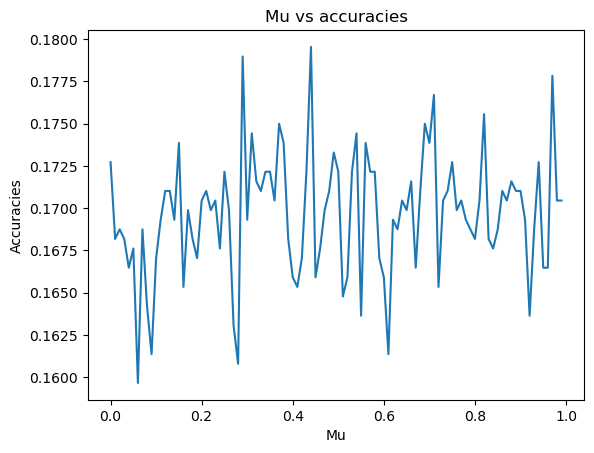

In [86]:
plt.title('Mu vs accuracies')
plt.xlabel('Mu')
plt.ylabel('Accuracies')
plt.plot(mus,accuracies)

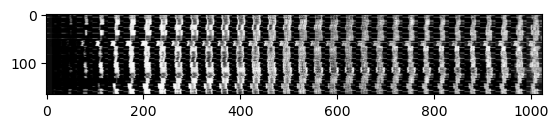

In [61]:
plt.imshow(img,cmap=plt.cm.gray_r)

<AxesSubplot:>

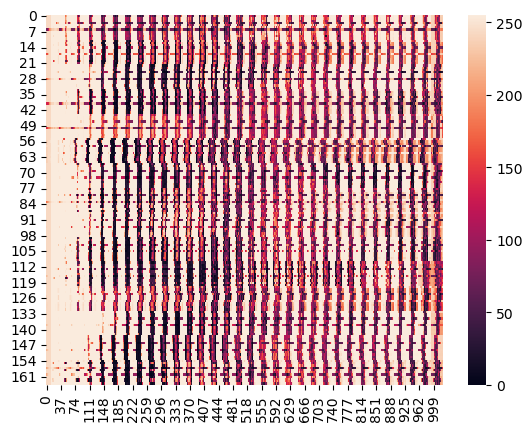

In [62]:
sns.heatmap(img)

(1024, 55)
(55, 55)
Step 1 Error 0.018315573332306028
Step 2 Error 0.006586496717144792
Step 3 Error 0.004053015910156514
Step 4 Error 0.002618991323971188
Step 5 Error 0.0018124440364555815
Step 6 Error 0.0013701592104371607
Step 7 Error 0.0011126904911064634
Error 0.0009434097024650705
-----END-----
Model: LDA
Choice: 1

new img shape (165, 55)


<AxesSubplot:>

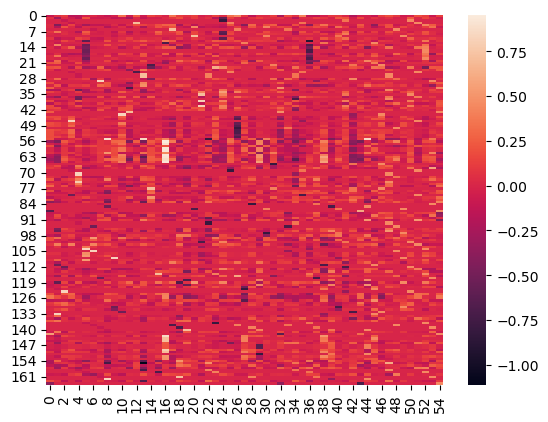

In [43]:
A=preprocessing(img,labels,method='FSSL_LDA',plot=False,choice=None,tsize=5)
new_img=img@A
print('new img shape',new_img.shape)
sns.heatmap(img@A)

In [44]:
# start=time.time()
# fssl_img=preprocessing(img,labels,method='FSSL_LPP')
# end=time.time()
# extra=end-start
create_table(img,labels,baseline,'base',train_sizes,0)

,5,6,7
Accuracy,0.168636,0.173737,0.169318
Time taken,3.778 ms,3.129 ms,2.83 ms


In [45]:
img.shape

(165, 1024)

In [46]:
img

array([[243, 243, 243, ..., 237, 237, 237],
       [243, 243, 243, ..., 234, 236, 236],
       [243, 243, 243, ..., 234, 236, 236],
       ...,
       [243, 243, 243, ..., 222, 222, 225],
       [243, 243, 243, ..., 217, 217, 216],
       [243, 243, 243, ..., 224, 225, 230]], dtype=uint8)

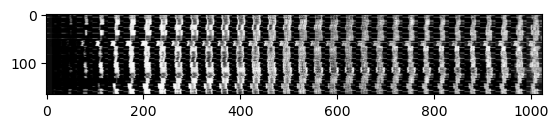

In [18]:
plt.imshow(img,cmap=plt.cm.gray_r)

## Trials
As we can see the above algorithm is not performing well. This is probably due to the small size of dataset and large number of labels. Now we attempt the same algorithm on the digits dataset

In [19]:

print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [20]:
mnist.data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
mnist.target.shape

(70000,)

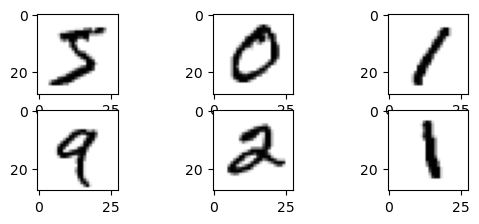

In [22]:
image= mnist.data.to_numpy()
plt.subplot(431)
plt.imshow(image[0].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(432)
plt.imshow(image[1].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(433)
plt.imshow(image[3].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(434)
plt.imshow(image[4].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(435)
plt.imshow(image[5].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(436)
plt.imshow(image[6].reshape(28,28), cmap=plt.cm.gray_r)

In [23]:
x=mnist.data
y=mnist.target

In [24]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [25]:
y=np.array(y)
x=np.array(x)
data_filter=np.where((y=='1')|(y=='9'))

In [26]:
x=x[data_filter]
y=y[data_filter]

In [27]:
x.shape

(14835, 784)

In [28]:
y.shape

(14835,)

In [29]:
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1)

In [30]:
train_sizes=[10,20,30]
create_table(x,y,baseline,'base',train_sizes)

,10,20,30
Accuracy,0.967013,0.976725,0.9818
Time taken,285.56 ms,290.478 ms,308.011 ms


In [31]:
# create_table(x,y,LDA,'base')

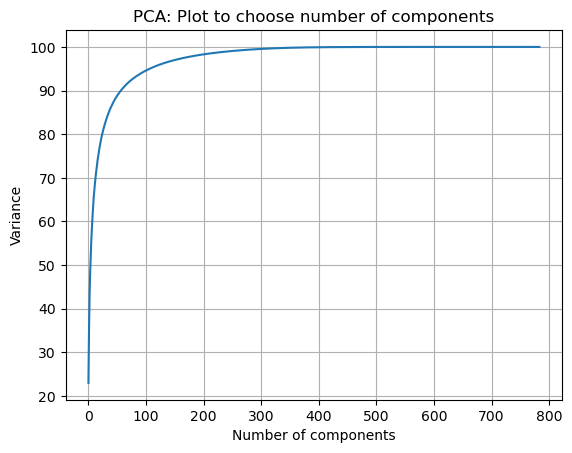

,10,20,30
Accuracy,0.967462,0.977138,0.982132
Time taken,250.267 ms,251.07 ms,254.449 ms


In [32]:
create_table(preprocessing(x,y),y,baseline,'base',train_sizes)

In [33]:
# start=time.time()
# fssl_img=preprocessing(x,y,method='FSSL_LDA')
# end=time.time()
# extra=end-start
create_table(x,y,baseline,'FSSL_LDA',train_sizes)

(784, 20)
(20, 20)
Step 1 Error 0.0052665038125286655
Step 2 Error 0.0015927057743874817
Step 3 Error 0.0010485332514087514
Error 0.0008243341372800015
-----END-----
Model: LDA
Choice: 1

(784, 20)
(20, 20)
Step 1 Error 0.005406451620117386
Step 2 Error 0.0016343551711465107
Error 0.0009690895390842359
-----END-----
Model: LDA
Choice: 1

(784, 20)
(20, 20)
Step 1 Error 0.005345566144280713
Step 2 Error 0.001942741623577153
Step 3 Error 0.0010454127092137024
Error 0.0006937207492153511
-----END-----
Model: LDA
Choice: 1

(784, 20)
(20, 20)
Step 1 Error 0.005329410365219856
Step 2 Error 0.0014486673353305347
Error 0.0009786102957693673
-----END-----
Model: LDA
Choice: 1

(784, 20)
(20, 20)
Step 1 Error 0.006458483747322931
Step 2 Error 0.0023391057687286144
Step 3 Error 0.0013613506619796346
Error 0.0009148615571011253
-----END-----
Model: LDA
Choice: 1

(784, 20)
(20, 20)
Step 1 Error 0.005268247156427068
Step 2 Error 0.0015653012053928172
Step 3 Error 0.001007052817163177
Error 0.00075

(784, 60)
(60, 60)
Step 1 Error 0.016517081301462108
Step 2 Error 0.004190334724290522
Step 3 Error 0.0019763635143575796
Step 4 Error 0.0011860272980711243
Error 0.0008369529623989167
-----END-----
Model: LDA
Choice: 1

(784, 60)
(60, 60)
Step 1 Error 0.0151699359592919
Step 2 Error 0.004156484818138689
Step 3 Error 0.002012675856699582
Step 4 Error 0.0011831805828538737
Error 0.0008230331959176614
-----END-----
Model: LDA
Choice: 1

(784, 60)
(60, 60)
Step 1 Error 0.01644541543519192
Step 2 Error 0.004485569132852511
Step 3 Error 0.0022146728477547752
Step 4 Error 0.001305870296666781
Error 0.0009012326525737167
-----END-----
Model: LDA
Choice: 1

(784, 60)
(60, 60)
Step 1 Error 0.015521382112229943
Step 2 Error 0.0040019616361695425
Step 3 Error 0.001967092602784179
Step 4 Error 0.0011628714422261472
Error 0.0008022999198419522
-----END-----
Model: LDA
Choice: 1

(784, 60)
(60, 60)
Step 1 Error 0.0141034551415635
Step 2 Error 0.003691103747402902
Step 3 Error 0.0018240717754866038
S

,10,20,30
Accuracy,0.970057,0.979753,0.983394
Time taken,271.701 ms,274.121 ms,283.842 ms


In [34]:
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

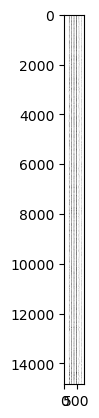

In [35]:
plt.imshow(x,cmap=plt.cm.gray_r)

In [ ]:
# start=time.time()
# fssl_img=preprocessing(x,y,method='FSSL_LPP')
# end=time.time()
# extra=end-start
# create_table(fssl_img,y,baseline,'base',train_sizes,extra)

In [ ]:
# def transform_to_img(x):
#     start=np.max(x)
#     end=np.min(x)
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             x[i,j]=255*(x[i,j]-end)/(start-end)
#             x[i,j]=int(x[i,j])
#     return x
# xx=transform_to_img(fssl_img)
# sns.heatmap(fssl_img)

In [ ]:
A=preprocessing(x,y,method='FSSL_LDA',plot=False,choice=None,tsize=20)
new_x=x@A
print('new img shape',new_x.shape)
sns.heatmap(x@A)

In [ ]:
sns.heatmap(A)

In [ ]:
sns.heatmap(x)

In [ ]:
# umist_cropped=fetch_openml('svhn')

In [ ]:
print(umist_cropped.DESCR)

In [ ]:
umist_cropped.data

In [ ]:
umist_cropped.target.shape

In [ ]:
x=umist_cropped.data
y=umist_cropped.target

In [ ]:
y

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
train_sizes=[1,2,3]
create_table(x,y,baseline,'base',train_sizes)

In [ ]:
create_table(preprocessing(x,y),y,baseline,'base',train_sizes)

In [ ]:
train_sizes=[3,4,5]
create_table(x,y,baseline,'FSSL_LDA',train_sizes)

In [ ]:
A=preprocessing(x,y,method='FSSL_LDA',plot=False,choice=None,tsize=20)
new_x=x@A
print('new img shape',new_x.shape)
sns.heatmap(x@A)

In [ ]:
sns.heatmap(x)